# HATE SPEECH DETECTION - Sentiment Analysis Project


Viggiano Martina (954603)

## 1. Data import and error removal
Hate speech dataset from a white supremacist forum:  https://github.com/Vicomtech/hate-speech-dataset

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm
import ntpath
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
tqdm.pandas()

C:\Users\marti\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
all_files_paths = glob.glob("hate-speech-dataset/all_files/*.txt")

In [3]:
all_files_paths = [f for f in all_files_paths if os.path.isfile(f)]

In [4]:
all_files_names = [str(ntpath.basename(f)).replace(".txt", "") for f in all_files_paths]

In [5]:
txt_content = {}
errors = []
for name, path in tqdm(list(zip(all_files_names, all_files_paths))):
    with open(path, "r") as txt:
        try:
            txt_content[name] = txt.readline()
        except Exception as ex:
            errors.append((name, str(ex)))

100%|██████████| 10944/10944 [00:02<00:00, 4198.02it/s]


In [6]:
errors[:5]

[('13491591_4',
  "'charmap' codec can't decode byte 0x81 in position 23: character maps to <undefined>"),
 ('13493456_1',
  "'charmap' codec can't decode byte 0x81 in position 169: character maps to <undefined>"),
 ('13500400_1',
  "'charmap' codec can't decode byte 0x81 in position 67: character maps to <undefined>"),
 ('13560796_1',
  "'charmap' codec can't decode byte 0x81 in position 5: character maps to <undefined>"),
 ('13572081_1',
  "'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>")]

In [7]:
errors_list = [err[0] for err in errors]

In [8]:
df = pd.DataFrame.from_dict(txt_content, orient='index').reset_index()
df.columns = ["file_id", "text"]

In [9]:
df.head()

,file_id,text
0,12834217_1,"As of March 13th , 2014 , the booklet had been..."
1,12834217_10,Thank you in advance. : ) Download the youtube...
2,12834217_2,In order to help increase the booklets downloa...
3,12834217_3,( Simply copy and paste the following text int...
4,12834217_4,Click below for a FREE download of a colorfull...


In [10]:
ann = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')

In [11]:
ann.head()

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate


In [12]:
ann = ann[~ann['file_id'].isin(errors_list)]

In [13]:
data = pd.merge(left=ann, right=df, left_on='file_id', right_on='file_id')
data.shape
data.head()

,file_id,user_id,subforum_id,num_contexts,label,text
0,12834217_1,572066,1346,0,noHate,"As of March 13th , 2014 , the booklet had been..."
1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...
2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...
3,12834217_4,572066,1346,0,hate,Click below for a FREE download of a colorfull...
4,12834217_5,572066,1346,0,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...


In [14]:
data['label'] = data.apply(lambda x: 0 if x['label'] == "noHate" else 1, axis=1)

### 2. Cleaning and tokenization

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string
import nltk.sentiment.vader as vd
from nltk import download
download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### 2.1 Removing links, tags, numbers and bias

In [16]:
#engl = []
#other = []
#for x in range(len(data['text'])):
#    try:
#        if detect(data['text'][x]) == 'en':
#            engl.append(data['text'][x], detect(data['text'][x])
#        else:
#            other,(data['text'][x], detect(data['text'][x]))
#    except:
#        None

In [17]:
import re
cList = {
    "n't": "not",
    "/TD": " ",
    "pm": "personal message",
    "PM": "personal message",
    "Donot": "do not",
    "MB" : "megabytes"}
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [18]:
data['text']= [expandContractions(x) for x in data['text']]

In [19]:
additional  = ['rt','rts','retweet']
swords = set().union(stopwords.words('english'), additional, string.punctuation)
data['text_clean'] = data['text'].str.lower()\
    .str.replace('(@[a-z0-9]+)\w+',' ')\
    .str.replace(r'http\S+', '')\
    .str.replace(r'www\S+',' ')\
    .str.replace(r'com/watch', ' ')\
    .str.replace(r'\S*[.,:;!?-]\S*[^\s\.,:;!?-]',' ')\
    .str.replace(r' ca ', ' cannot ')\
    .str.replace(r'\w*\d\w*',' ')\
    .str.replace(r'rlm',' ')\
    .str.replace(r'pttm',' ')\
    .str.replace(r'ghlight',' ')\
    .str.replace('[0-9]+(?:st| st|nd| nd|rd| rd|th| th)', '')\
    .str.replace('([^a-z \t])',' ')\
    .str.replace(' +',' ')\
    .apply(lambda x: " ".join([i for i in x.split() if not i in swords]))
#any alpha numeric after @ #http # any value except alpha numeric tab character ('\u0009')
#.str.replace(r'#\S+', ' ')\

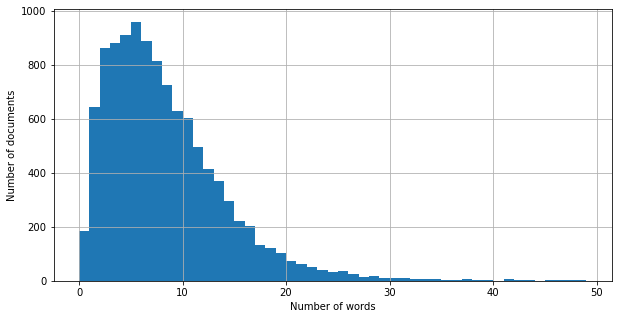

In [20]:
data['word_count'] = data['text_clean'].apply(lambda x: len(x.split())) # Number of words in the string
plt.figure(figsize=(10,5))
plt.hist(data.word_count.values, bins = range(0, 50))
plt.xlabel("Number of words")
plt.ylabel("Number of documents")
plt.grid(True)
plt.show()

In [21]:
data['text'][3156]

"Classic trucker songs YouTube - & #x202a ; Dave Dudley - Diesel Smoke ( 18WoS : PTTM ) & #x202c ; & rlm ; Diesel Smoke another of same song , different video , says the artist was Red Simpson YouTube - & #x202a ; Red Simpson - Diesel smoke , & #x202c ; & rlm ; YouTube - & #x202a ; Red Sovine-Truck Drivin ' Son Of A Gun & #x202c ; & rlm ; Truck Drivin ' Son of a Gun YouTube - & #x202a ; Terry Allen - Amarillo Highway & #x202c ; & rlm ; Amarillo Highway ( slow version , live , with violins ) YouTube - & #x202a ; Robert Earl Keen - Amarillo Highway & #x202c ; & rlm ; Fast rockin ' country version by Robert Earl Keene"

In [22]:
data['text_clean'][3156]

'classic trucker songs youtube dave dudley diesel smoke diesel smoke another song different video says artist red simpson youtube red simpson diesel smoke youtube red drivin son gun truck drivin son gun youtube terry allen amarillo highway amarillo highway slow version live violins youtube robert earl keen amarillo highway fast rockin country version robert earl keene'

In [23]:
data['text'][data['text_clean'].str.contains("#")]

Series([], Name: text, dtype: object)

In [24]:
# Stemming
ps = PorterStemmer()
data['stemmed'] = data['text_clean'].apply(lambda x: " ".join([ps.stem(i) for i in word_tokenize(x)]))

In [25]:
# Lemmatizer
lm = nltk.WordNetLemmatizer()
data['lemmatized'] = data['text_clean'].apply(lambda x: " ".join([lm.lemmatize(i) for i in word_tokenize(x)]))

In [26]:
data['tokens'] = data['lemmatized'].apply(word_tokenize)

In [27]:
from langdetect import detect
languages = []
for x in tqdm(range(len(data['text']))):
    try:
        languages.append(detect(data['text'][x]))
    except:
        None

100%|██████████| 10926/10926 [02:29<00:00, 73.11it/s] 


In [28]:
other = []
for x in tqdm(range(len(data['lemmatized']))):
    try:
        if detect(data['lemmatized'][x]) != 'en':
            print(data['lemmatized'][x], detect(data['lemmatized'][x]))
    except:
        None

  0%|          | 10/10926 [00:00<10:33, 17.24it/s]

booklet updated feb da
downloads pl


  0%|          | 22/10926 [00:00<08:01, 22.65it/s]

came across piece garbage ro
comment say sa fr


  0%|          | 28/10926 [00:01<06:34, 27.60it/s]

old tarzan movie zulu king kong many image tl


  0%|          | 39/10926 [00:01<06:23, 28.38it/s]

girl start talking guy middle lip start moving no
believe dog would like get far away possible af


  0%|          | 49/10926 [00:01<05:41, 31.81it/s]

watch hollywood movie en


  0%|          | 53/10926 [00:01<06:20, 28.54it/s]

v entire myron fagan video youtube es
v sk


  1%|          | 57/10926 [00:02<10:11, 17.76it/s]

note lv
wntube pl


  1%|          | 60/10926 [00:02<12:37, 14.35it/s]

please contribute donate ro
vid code es
jesus christ lord indeed

  1%|          | 69/10926 [00:02<09:36, 18.84it/s]

 nl
nice day pl


  1%|          | 79/10926 [00:03<08:44, 20.69it/s]

sooner better no


  1%|          | 86/10926 [00:03<08:44, 20.68it/s]

hard time believing da
hundred people black da


  1%|          | 100/10926 [00:03<05:56, 30.34it/s]

excellent article jail fr


  1%|          | 110/10926 [00:03<04:44, 38.00it/s]

good so


  1%|          | 116/10926 [00:04<07:54, 22.76it/s]

hope starve da
aragorn tl


  1%|          | 125/10926 [00:04<07:07, 25.26it/s]

respond armenian scum stop ro
see giving af
btl tr


  1%|          | 129/10926 [00:04<06:46, 26.59it/s]

apologize ignorance it


  1%|▏         | 140/10926 [00:05<07:00, 25.66it/s]

give example progress made skinhead klan sv
seems precipitous decline ca


  1%|▏         | 151/10926 [00:05<06:28, 27.72it/s]

pesticide fresh fruit veggie ca


  1%|▏         | 156/10926 [00:05<06:33, 27.39it/s]

negro holding camera laugh glee dailymotion agression raciste contre une jeune fille blanche france une vid news politics fr


  2%|▏         | 182/10926 [00:06<04:41, 38.15it/s]

pffffft cy


  2%|▏         | 202/10926 [00:06<04:16, 41.79it/s]

concerned zog controlling u russia it
kris roman jan kristel dr alfred vierling dr david duke thiery van roy frederik ranson andreas thierry stephanos gekas af


  2%|▏         | 208/10926 [00:07<07:36, 23.47it/s]

robert steuckers dr david duke gunther van den eynde en dr david duke nl
traitor lt


  2%|▏         | 219/10926 [00:07<06:20, 28.15it/s]

attaboy putin tl


  2%|▏         | 231/10926 [00:08<06:59, 25.51it/s]

keep telling people thing like never believe af
great ro
go work pl
lol es


  2%|▏         | 255/10926 [00:08<05:26, 32.65it/s]

swede hide best looking female af
gl delig jul da


  2%|▏         | 259/10926 [00:09<08:44, 20.32it/s]

interesting no
found pretty interesting hope g delig jul no


  2%|▏         | 264/10926 [00:09<07:39, 23.21it/s]

since really sture n horace engdahl can not say svenska akademins ordlista en
make damn angry swede can not see af


  2%|▏         | 268/10926 [00:09<10:33, 16.82it/s]

det er forresten en ting til rkneyjar vil si deg tack mycket no
say jotunheim fi
figure

  2%|▏         | 271/10926 [00:09<11:53, 14.94it/s]

 ro
much important estimation fr


  3%|▎         | 282/10926 [00:10<09:45, 18.17it/s]

let see get zero nl
aragorn cy
good news norge cy


  3%|▎         | 287/10926 [00:10<11:23, 15.57it/s]

possible fr
dare look so
see grandma hair looked like year ago af


  3%|▎         | 299/10926 [00:11<08:53, 19.91it/s]

jag har inte sj lv varit med n gon g ng men jag har stor respekt f r de som deltar no
damn finland closing sweden poll sv
suomalainen totta kai fi


  3%|▎         | 303/10926 [00:11<07:44, 22.86it/s]

reminds old joke da
cheer nl


  3%|▎         | 319/10926 [00:11<06:01, 29.36it/s]

feel mix intense hate depression let thing degenerate far nl


  3%|▎         | 340/10926 [00:12<06:01, 29.32it/s]

looking forward af
regard draiodoir cy
true vi


  3%|▎         | 344/10926 [00:12<05:56, 29.70it/s]

look jealousy cs
lie lie lie fr


  3%|▎         | 353/10926 [00:12<06:54, 25.51it/s]

love darker hair skin eye tr
stunning kiss fi
use personal message get touch fr


  3%|▎         | 367/10926 [00:13<07:13, 24.35it/s]

pig bladder used football made camel doings no


  3%|▎         | 375/10926 [00:13<06:44, 26.06it/s]

know en


  3%|▎         | 382/10926 [00:14<07:51, 22.35it/s]

happening school nl
donot ridiculous pt
indeed nl


  4%|▎         | 391/10926 [00:14<08:48, 19.92it/s]

buying gun bullet id
fault bnp run gangster no


  4%|▎         | 399/10926 [00:14<08:02, 21.83it/s]

hello friend forum no


  4%|▎         | 406/10926 [00:15<06:55, 25.30it/s]

sat minute took dog walk af


  4%|▍         | 424/10926 [00:15<05:24, 32.37it/s]

sugar bowl lemon side fr
pleasure make acquaintance madam fr
mean ro


  4%|▍         | 437/10926 [00:16<07:54, 22.12it/s]

better hated loved da
rule britannia ro


  4%|▍         | 441/10926 [00:16<11:34, 15.10it/s]

telling kid frankfurt foreigner da
jeeze worst uk pl


  4%|▍         | 451/10926 [00:17<07:46, 22.43it/s]

girl indeed amazing nl


  4%|▍         | 459/10926 [00:17<07:57, 21.93it/s]

ukraine russia poland romania fake ukrainian et


  4%|▍         | 466/10926 [00:17<08:33, 20.35it/s]

p someone else csabi according csabi romanian listen hungarian music it


  4%|▍         | 477/10926 [00:18<06:57, 25.01it/s]

ap ro g ant trois jeunes soup onn de viol fr
start sv
genius lt


  4%|▍         | 483/10926 [00:18<06:11, 28.10it/s]

liberia awaits id
tired da
hope negro beat negro af


  5%|▍         | 492/10926 [00:18<06:09, 28.20it/s]

stupid hr
indeed nl
dusty rhodes cy


  5%|▍         | 500/10926 [00:18<05:49, 29.83it/s]

name past tl
last time kissed yesterday et


  5%|▍         | 521/10926 [00:19<04:48, 36.11it/s]

use one part fr


  5%|▍         | 526/10926 [00:19<06:19, 27.40it/s]

kalamzoo u odinists town hr
like jager et
neofolk no


  5%|▍         | 535/10926 [00:20<06:46, 25.59it/s]

email personal message fr
would like talk af
jeremy wpww pl
dallas it


  5%|▌         | 555/10926 [00:20<06:03, 28.53it/s]

worker af
inch dark blonde hazel green eye lb babyface nl
well good cy


  5%|▌         | 586/10926 [00:21<05:47, 29.76it/s]

join nationalist coalition en
live san bernardino send personal message da


  5%|▌         | 596/10926 [00:21<06:01, 28.59it/s]

live san bernardino send personal message ontario mill eh it
like week ago got new doc maybe talk af
like wall idea af
next read ro


  6%|▌         | 608/10926 [00:22<04:52, 35.32it/s]

everyone keep spreading dr duke video around internet soon win war af


  6%|▌         | 613/10926 [00:22<06:50, 25.11it/s]

taken dance class various time enjoy fr
problem multiracial environment mean dance ca


  6%|▌         | 626/10926 [00:23<06:36, 26.01it/s]

eurocentric civ documentary europhobia ro
hahahahahaha so
kinda place tr


  6%|▌         | 639/10926 [00:23<07:19, 23.43it/s]

flyer home symbol look return home get info da
saw poll missippi said think lott step segregationist remark et


  6%|▌         | 645/10926 [00:23<08:39, 19.78it/s]

justifies policy fr
last paragraph essay talk sticker technique fr


  6%|▌         | 653/10926 [00:24<07:21, 23.28it/s]

awakening still print id


  6%|▌         | 673/10926 [00:24<04:16, 40.04it/s]

thank sieg heil ryan af
wonder nl


  6%|▋         | 691/10926 [00:24<03:42, 46.04it/s]

mention business jail among gang id
word deed declare staunchly favor genocide people nl


  6%|▋         | 704/10926 [00:25<03:34, 47.61it/s]

america beautiful rainbow ro


  7%|▋         | 715/10926 [00:25<04:31, 37.63it/s]

tell legalize drug pedophilia it
dear ro


  7%|▋         | 735/10926 [00:26<05:09, 32.94it/s]

upgraded black sv
asian id
light skin dark hair af


  7%|▋         | 739/10926 [00:26<08:17, 20.48it/s]

native american it
jew enemy good set brain pl


  7%|▋         | 749/10926 [00:26<07:29, 22.65it/s]

nope it
keep civil nl
peanut butter ro


  7%|▋         | 765/10926 [00:27<05:48, 29.12it/s]

link fi
pretty simple come come it


  7%|▋         | 769/10926 [00:27<05:52, 28.83it/s]

ya got virgin shooter af
hundred yard cy


  7%|▋         | 779/10926 [00:27<07:06, 23.81it/s]

paper plate ca
minute et
problem cs


  7%|▋         | 790/10926 [00:28<05:23, 31.32it/s]

youtube id
display id
good shape so


  7%|▋         | 800/10926 [00:28<06:01, 28.03it/s]

working splendidly af
another great meet weekend able meet new people en


  7%|▋         | 810/10926 [00:28<04:54, 34.37it/s]

stay away alberta so


  8%|▊         | 820/10926 [00:29<06:08, 27.42it/s]

lol tim it
yep tr
anyone ever asked da
say dont care fr


  8%|▊         | 831/10926 [00:29<08:16, 20.35it/s]

want mixed kid so
hate crime said en


  8%|▊         | 835/10926 [00:30<07:38, 22.03it/s]

facebook van page nl
lot old ambulance rescue van ripe modding live ca


  8%|▊         | 839/10926 [00:30<08:19, 20.19it/s]

predator xtreme august ro


  8%|▊         | 842/10926 [00:30<12:08, 13.83it/s]

ever gave hard knock better got no


  8%|▊         | 849/10926 [00:30<09:24, 17.86it/s]

taken together dark region suggest many shape running man en
yeah hay ride popular tl
gone corn maze well it
good memory cy
one

  8%|▊         | 861/10926 [00:31<06:08, 27.28it/s]

 fi
watch sw
need get done luck find idf general da


  8%|▊         | 870/10926 [00:31<06:01, 27.82it/s]

transfer uni ca
teach alot lie student ro


  8%|▊         | 881/10926 [00:31<04:39, 35.99it/s]

gone full retard it
ever wonder nl


  8%|▊         | 898/10926 [00:32<03:51, 43.26it/s]

basketball baseball no
pellet flattened quite nicely fr


  8%|▊         | 909/10926 [00:32<04:30, 36.97it/s]

even smaller pellet probably ideal buck perhaps no
always partial lully rameau jean baptiste lully l orchestre du roi soleil youtube jean philippe rameau orchestral suite youtube fr
except peanut butter ro


  8%|▊         | 914/10926 [00:32<05:51, 28.45it/s]

like french da
also like renoir sl
man idiot id
yuenglings tl


  8%|▊         | 928/10926 [00:33<06:41, 24.93it/s]

problem cs
kid come get nl


  9%|▊         | 942/10926 [00:33<04:50, 34.36it/s]

yamaha aerox p youtube yep cc aerox id
sister grey eye sister blue eye sister green eye brother blue eye

  9%|▊         | 946/10926 [00:33<06:52, 24.22it/s]

 no
hitler mein kampf de
slowly making way romanian bible got birthday july so


  9%|▊         | 955/10926 [00:34<05:42, 29.08it/s]

gon na suggest old marlin remembered mag da
week two one kid asks jewish af


  9%|▉         | 963/10926 [00:34<05:51, 28.33it/s]

pas kosher value kid despite sending public shools af
goy friend cy


  9%|▉         | 978/10926 [00:34<05:17, 31.38it/s]

ghost goblin etc cy
little kid decked costume en


  9%|▉         | 986/10926 [00:35<05:50, 28.33it/s]

went baofeng website chinese de
saw one palm spring tl


  9%|▉         | 999/10926 [00:35<05:17, 31.30it/s]

new word week somehow become word two week torpid tor pid adj dormant hibernating af


  9%|▉         | 1003/10926 [00:35<06:48, 24.30it/s]

great ro


  9%|▉         | 1013/10926 [00:36<06:35, 25.05it/s]

look nonsense tv af
wife post pl


  9%|▉         | 1016/10926 [00:36<08:51, 18.65it/s]

still great liberal experiment continues ca


  9%|▉         | 1027/10926 [00:36<07:08, 23.09it/s]

find inspiring da
bull tr


  9%|▉         | 1031/10926 [00:37<09:04, 18.17it/s]

son ever come home something like bet something say da
cent unit study store ro
cool site it


 10%|▉         | 1039/10926 [00:37<07:56, 20.75it/s]

yeah tr
describe sister es


 10%|▉         | 1047/10926 [00:37<07:09, 23.02it/s]

come pride stay love es
six remember dark id


 10%|▉         | 1053/10926 [00:37<07:44, 21.28it/s]

god one claim merciful like nature hr


 10%|▉         | 1071/10926 [00:38<06:01, 27.30it/s]

bet negro planning insanity defense may get no


 10%|▉         | 1082/10926 [00:39<06:55, 23.67it/s]

donot love double standard fr


 10%|▉         | 1085/10926 [00:39<08:44, 18.77it/s]

parent like no


 10%|▉         | 1092/10926 [00:39<07:35, 21.58it/s]

wulfi so


 10%|█         | 1113/10926 [00:40<04:41, 34.87it/s]

feel nl
keep simple et
well good hear cy
good so
knew kid street home schooled didnt act like kid age en


 10%|█         | 1122/10926 [00:40<05:18, 30.79it/s]

maybe so
hey everyone would like get together people state like af
freuer frei da


 10%|█         | 1133/10926 [00:40<04:14, 38.54it/s]

im roxbury pl
god save hr


 11%|█         | 1148/10926 [00:40<03:53, 41.89it/s]

robbie funny problem sk
typical afrikaans music af


 11%|█         | 1157/10926 [00:41<04:51, 33.50it/s]

seen interview seem trashy af
agreed af


 11%|█         | 1174/10926 [00:41<05:11, 31.26it/s]

absolutely hu
nope it


 11%|█         | 1182/10926 [00:42<05:02, 32.18it/s]

pastor saying truth tl
know en


 11%|█         | 1187/10926 [00:42<04:58, 32.66it/s]

bean potato yam id
seems nature taking trash et


 11%|█         | 1195/10926 [00:42<05:44, 28.27it/s]

certain cultural practice tell volume people ro
goody run so


 11%|█         | 1199/10926 [00:42<08:31, 19.03it/s]

absolute stupidity et


 11%|█         | 1216/10926 [00:43<06:03, 26.71it/s]

lenny pitt article one fr
make sw


 11%|█▏        | 1234/10926 [00:43<05:18, 30.47it/s]

embarassing id


 11%|█▏        | 1242/10926 [00:44<06:06, 26.45it/s]

doubt coming leprechaun chinese flavored uncle sam en


 11%|█▏        | 1246/10926 [00:44<06:05, 26.49it/s]

rumour fr
disgusting negro make u white people look bad af


 11%|█▏        | 1249/10926 [00:44<10:30, 15.34it/s]

flagged reported skyyjohn channel youtube sent blind date en
youtube sw


 12%|█▏        | 1257/10926 [00:45<07:52, 20.46it/s]

make tired hr
cologne seat it


 12%|█▏        | 1266/10926 [00:45<06:14, 25.76it/s]

put cursor american dissident voice tab click link menu drop ro
never ever grocery look like af


 12%|█▏        | 1276/10926 [00:45<05:46, 27.85it/s]

even like buying carton juice nl
seen young white girl boy acting like black baggy pant hip hop en


 12%|█▏        | 1285/10926 [00:46<05:55, 27.15it/s]

hate crime video posted pt


 12%|█▏        | 1298/10926 [00:46<04:12, 38.19it/s]

fa pageid cy
notice say kid jew hr


 12%|█▏        | 1303/10926 [00:46<06:23, 25.11it/s]

sad happens want take think want date one negro woman af
bid good night so


 12%|█▏        | 1312/10926 [00:46<05:52, 27.30it/s]

dmitriy hvorostovskiy prince yeletsky queen spade tchaikovsky hvorostovsky metropolitan opera youtube ya va lyublyu dmitri hvorostovsky renee fleming dmitri hvorostovsky perform final scene tchaikovsky yevgeny onegin part youtube yevgeny onegin final scene hvorostovsky fleming renee fleming dmitri hvorostovsky perform final scene tchaikovsky yevgeny onegin part ii youtube yevgeny onegin final scene hvorostovsky fleming ii renee fleming tatiana dmitri hvorostovsky eugene onegin first act aria tchaikovsky opera sk
youtube dmitri hvorostovsky eugene onegin onegin act aria renee fleming dmitri hvorostovsk lippen schweigen lehar die lustige witwe youtube lippen schweigen hvorostovsky fleming offtop bonus hvorostovsky troika youtube hvorostovsky troika dmitri hvorostovsky temnaya noch youtube temnaya noch dmitri hvorostovsky little bell youtube hvorostovsky little bell dmitri hvorostovsky moscow night youtube dmitri hvorostovsky moscow night sk


 12%|█▏        | 1321/10926 [00:47<05:58, 26.80it/s]

yes born svrljig sv
read million figure million figure estimate million figure compromised it


 12%|█▏        | 1332/10926 [00:47<05:45, 27.74it/s]

please excuse ignorance fr
gon na long post see konavle look better map small land important af


 12%|█▏        | 1336/10926 [00:47<06:25, 24.87it/s]

hope class future russia en
pray sk


 12%|█▏        | 1348/10926 [00:48<07:21, 21.67it/s]

peter drafted army said no
live forum day job da


 12%|█▏        | 1352/10926 [00:48<06:47, 23.52it/s]

size rarely matter hu
riga day so


 12%|█▏        | 1361/10926 [00:48<06:02, 26.41it/s]

anyone like meet drink love say hello personal message reply no


 12%|█▏        | 1365/10926 [00:49<08:08, 19.58it/s]

matter dress mud no
mud mud mud et
gypsie woman like black sabbath dont like gypsy af
sympathy cy


 13%|█▎        | 1372/10926 [00:49<11:54, 13.37it/s]

rensen r er f dt april kolding da
har taget en p handelsskolen nyborg da


 13%|█▎        | 1377/10926 [00:50<12:22, 12.86it/s]

medlem af dfu bestyrelse da
sin fritid g r karina rensen p jagt med sin far dyrker styrketr ning eller nyder tilv relsen med sin k reste no
valgt vejle amt som folketingets yngste medlem nogensinde da
karina rensen er medlem af kontaktudvalget da


 13%|█▎        | 1381/10926 [00:50<14:33, 10.93it/s]

rensen year old born april kolding da
member dfu directorate ro


 13%|█▎        | 1392/10926 [00:51<10:20, 15.37it/s]

met mr griffin found amiable well spoken en
anyway good luck so
homo tried fag pride parade serbia year ago beaten es
suggesting anything tl


 13%|█▎        | 1399/10926 [00:51<09:09, 17.34it/s]

aragorn tl
damn making tag along tl
good night europe af


 13%|█▎        | 1406/10926 [00:51<07:15, 21.87it/s]

susan tl
mistenkt krigsforbrytelser ker asyl norge en tsjetsjener etters kt terrorhandlinger og en libaneser mistenkt ha beg tt krigsforbrytelser bor p asylmottak norge med sine familier no


 13%|█▎        | 1415/10926 [00:51<07:13, 21.92it/s]

myndighetene vurderer n om de skal f permanent oppholdstillatelse da
government judging granted permanent residency da
lebanese one massacre sabra shattila direction israel en
may put away good tl
wolf pl
look like dennys list af


 13%|█▎        | 1419/10926 [00:52<09:08, 17.34it/s]

aoh legend de


 13%|█▎        | 1429/10926 [00:52<08:04, 19.61it/s]

likely moving belfast no


 13%|█▎        | 1441/10926 [00:53<06:28, 24.40it/s]

send personal message going da
e u soviet system much worse nl
well done cy


 13%|█▎        | 1455/10926 [00:53<05:00, 31.51it/s]

time drive traitor sq
perhaps proud indigenous inhabitant dublin want culture enriching ruining tripe like nl
scum ro
back ya came id


 13%|█▎        | 1465/10926 [00:53<04:20, 36.31it/s]

gone find it


 13%|█▎        | 1470/10926 [00:53<04:02, 39.01it/s]

go okay sshh so
wow pl
video etc welcome nl


 14%|█▎        | 1477/10926 [00:53<04:18, 36.61it/s]

get lead example fr
alot work done af


 14%|█▎        | 1497/10926 [00:54<03:53, 40.46it/s]

criminal scum ro
wisdom post pl


 14%|█▍        | 1503/10926 [00:54<04:50, 32.38it/s]

still prefer native every japanese korean no


 14%|█▍        | 1508/10926 [00:55<07:15, 21.60it/s]

get mine outlet even enemy one nl
good keep track enemy well see saying af
damn canada so


 14%|█▍        | 1524/10926 [00:55<05:53, 26.62it/s]

let get lad da
bad news cy
wait open door poor people tb capital europe romania ro


 14%|█▍        | 1552/10926 [00:56<03:40, 42.44it/s]

absolute madness et


 14%|█▍        | 1562/10926 [00:56<04:07, 37.78it/s]

london f ked da
oh irony cy
black muslim majority lt


 14%|█▍        | 1578/10926 [00:56<03:38, 42.76it/s]

perhaps would like comment link nl
got quote someone it


 15%|█▍        | 1585/10926 [00:57<03:48, 40.93it/s]

saw clip tl
mean warsaw uprising museum id
feel like et


 15%|█▍        | 1590/10926 [00:57<05:39, 27.50it/s]

let make clear like muslim still slav brother long keep religion problem no
thank video made u made ethnic son europe legacy youtube unity en


 15%|█▍        | 1604/10926 [00:57<04:58, 31.23it/s]

site day online tr


 15%|█▍        | 1615/10926 [00:58<04:38, 33.46it/s]

feel free join nl
groupid fr
got nothing slav slav no
part ethnic group fr
salute bulgaria comrade ro
wonder many mom would kill look good kid

 15%|█▍        | 1619/10926 [00:58<04:51, 31.92it/s]

 af
let alone fr
beautiful fr


 15%|█▍        | 1628/10926 [00:58<05:12, 29.74it/s]

address read enjoy no


 15%|█▌        | 1646/10926 [00:59<04:54, 31.49it/s]

link fi
maybe skip generation da


 15%|█▌        | 1655/10926 [00:59<04:35, 33.65it/s]

get ride see time summer cool need get someone nj name hal talk want meet go see stop see ok af
live peoria az it
normal pt


 15%|█▌        | 1669/10926 [00:59<04:58, 31.06it/s]

normal people left en
hehe de
damn cool so
would like help project nl


 15%|█▌        | 1684/10926 [01:00<05:39, 27.21it/s]

im irish skin id like hear skin nonskin girl around world af


 15%|█▌        | 1688/10926 [01:00<06:45, 22.79it/s]

tight referring slogan no
curious ro


 16%|█▌        | 1700/10926 [01:00<05:12, 29.49it/s]

lass fi
mod gone cy


 16%|█▌        | 1721/10926 [01:01<03:55, 39.03it/s]

make sense no
promote nordic superiority it


 16%|█▌        | 1730/10926 [01:01<03:15, 46.92it/s]

ty fi
rode bus since fr
plan making trip kalispell early august tl


 16%|█▌        | 1743/10926 [01:01<04:12, 36.40it/s]

passed devil lake nd flooding et
massive fi
good so
welcome ku klux klan knight party af


 16%|█▌        | 1762/10926 [01:02<04:13, 36.12it/s]

let keep fight one roof keep one fight free af
planet ape no
good so
little troll longer going nip pant leg let look platform no
need celebrate anyone birthday day anyway so


 16%|█▋        | 1777/10926 [01:02<03:51, 39.49it/s]

figure available none made public fr
yeah surprised en
guess keep et


 16%|█▋        | 1789/10926 [01:03<04:27, 34.14it/s]

good point hr
turn blocker zone alarm sv


 17%|█▋        | 1803/10926 [01:03<05:11, 29.33it/s]

philippine tl
jesus christ sk
tf care ro


 17%|█▋        | 1811/10926 [01:04<06:55, 21.94it/s]

get nl
extra concern care tibet ro
look talking af


 17%|█▋        | 1822/10926 [01:04<05:24, 28.03it/s]

hide behind link something da
moron sk
wow pl
hey negro genius cy
swim back jew arm pl


 17%|█▋        | 1835/10926 [01:04<03:56, 38.43it/s]

unreal ro
situation it
black gene always come dominant gene

 17%|█▋        | 1846/10926 [01:05<04:05, 36.97it/s]

 en
wrong cy


 17%|█▋        | 1855/10926 [01:05<05:13, 28.95it/s]

also genocide stop calling it
wow pl


 17%|█▋        | 1867/10926 [01:05<04:34, 32.96it/s]

putting meet feel free private message no
well wo stand af


 17%|█▋        | 1881/10926 [01:06<06:25, 23.48it/s]

visit today fi
see one et
also available line source ie ke l b fr


 17%|█▋        | 1894/10926 [01:06<04:51, 31.03it/s]

trudeau sneaking like et
could trudeau buddy set fire request fr


 17%|█▋        | 1902/10926 [01:06<05:12, 28.88it/s]

hiv aid killing fast enough sv
yes want way sw


 17%|█▋        | 1912/10926 [01:07<05:22, 27.97it/s]

enlightening nl
appreciate contribution fan long time it


 18%|█▊        | 1916/10926 [01:07<05:39, 26.56it/s]

call government appropriate name it
gotten fatter year no


 18%|█▊        | 1920/10926 [01:07<07:32, 19.91it/s]

used bikini model skinny sl


 18%|█▊        | 1933/10926 [01:08<05:49, 25.75it/s]

later went get beer opened door yep guessed blood geyser af


 18%|█▊        | 1942/10926 [01:08<06:58, 21.47it/s]

sport no
lying marxist tl
title like teach black kid et


 18%|█▊        | 1948/10926 [01:08<06:48, 22.00it/s]

people utter garbage get brain transplant no


 18%|█▊        | 1954/10926 [01:09<07:48, 19.17it/s]

make happen nl
told go said ar around ya lol cy
wo talk anymore wo go church anymore pl


 18%|█▊        | 1964/10926 [01:09<06:52, 21.74it/s]

listening no
minute gorgeous et
dresden remembrance last year year es


 18%|█▊        | 1974/10926 [01:09<05:47, 25.77it/s]

yep tr
law center prevent gun violence fr


 18%|█▊        | 1984/10926 [01:10<06:14, 23.86it/s]

period basket stamped full top flap holster no
best part fr
lisa grandpa department poker game back id
nobody nobody part basque made w hybrid cy


 18%|█▊        | 1992/10926 [01:10<05:48, 25.62it/s]

hope negro right ever af
mom blue eye dad green eye got eye af
matter quickly dropped

 18%|█▊        | 1995/10926 [01:10<06:03, 24.57it/s]

 sv
love video much sk


 18%|█▊        | 2001/10926 [01:11<07:50, 18.98it/s]

seen believe sf thank posting af
seem grasp fact jew stolen german identity first place blend nl
haha thinking thing vi


 18%|█▊        | 2006/10926 [01:11<06:34, 22.62it/s]

nah man enough id
like mauricio rua lt


 18%|█▊        | 2009/10926 [01:11<09:01, 16.48it/s]

like rony jason et


 18%|█▊        | 2014/10926 [01:11<09:43, 15.28it/s]

skin color race hope dont come picture blonde jew fr
ufc tuf rigged staged da


 19%|█▊        | 2025/10926 [01:12<07:12, 20.59it/s]

true vi
younger one say survivor sperm men egg woman no


 19%|█▊        | 2042/10926 [01:12<05:12, 28.43it/s]

unforgivable da
guess jew rabbi guy say must serve jew iraqi jew hr


 19%|█▉        | 2065/10926 [01:13<04:31, 32.69it/s]

grin bear keep getting respectable grade af
requirement circumcision found nt en


 19%|█▉        | 2083/10926 [01:13<04:17, 34.36it/s]

truth vi
virtually useless en
take look blog example no
ha so


 19%|█▉        | 2104/10926 [01:14<05:30, 26.70it/s]

problem jew destroyed one else da
usa also ca


 19%|█▉        | 2114/10926 [01:14<04:41, 31.28it/s]

laughable ca
intended nl


 19%|█▉        | 2125/10926 [01:14<04:20, 33.74it/s]

git happy as tl
iran war time so


 20%|█▉        | 2136/10926 [01:15<04:13, 34.73it/s]

solution simple fr
break no
please keep mind et


 20%|█▉        | 2155/10926 [01:15<03:53, 37.49it/s]

regard kyle sv
liberal care diversity it


 20%|█▉        | 2163/10926 [01:16<04:35, 31.80it/s]

let race continue fr
link fi


 20%|█▉        | 2171/10926 [01:16<04:42, 31.00it/s]

check de
jim sw
god cy


 20%|██        | 2186/10926 [01:16<04:20, 33.58it/s]

hell ill even give pic aim p ladieees p aim trilidon en
ya lazy cant get real job deal drug jump job job job ca


 20%|██        | 2190/10926 [01:17<08:01, 18.16it/s]

great ro
black wont kid nl


 20%|██        | 2206/10926 [01:17<05:29, 26.50it/s]

im grade im hr


 20%|██        | 2211/10926 [01:17<06:43, 21.62it/s]

havent put logins fr
great ro


 20%|██        | 2224/10926 [01:18<05:20, 27.11it/s]

jew insane literal demonic dna sl
feel nl
adrien holboth julia kovacs anita salata dora barkaszi zsofia buki beata frank eszter gulyas eniko halasz ramona kiss marta knoll szandra proksa hu


 20%|██        | 2233/10926 [01:18<05:29, 26.35it/s]

hungary justice id
never understand pain must felt no


 21%|██        | 2245/10926 [01:19<04:41, 30.83it/s]

lunch surreal ro
kid allowed talk so
silence fr
ready go cy


 21%|██        | 2258/10926 [01:19<03:33, 40.65it/s]

fun es


 21%|██        | 2272/10926 [01:19<03:48, 37.89it/s]

obama declare martial law freedom outpost pt


 21%|██        | 2278/10926 [01:19<04:25, 32.54it/s]

god rest man soul fr
perhaps get put bnp sticker sv


 21%|██        | 2283/10926 [01:20<04:52, 29.60it/s]

r student negro nl


 21%|██        | 2292/10926 [01:20<04:49, 29.82it/s]

barely rail cy


 21%|██        | 2300/10926 [01:20<06:39, 21.59it/s]

else da


 21%|██        | 2311/10926 [01:21<04:54, 29.24it/s]

thorongil get one twin get nl
oh god cy
good so


 21%|██        | 2319/10926 [01:21<05:16, 27.19it/s]

ai daddy new world order either like jew world order af


 21%|██▏       | 2329/10926 [01:21<06:02, 23.74it/s]

latest attack groid fr
impulsive negro stripping it


 21%|██▏       | 2347/10926 [01:22<04:05, 34.94it/s]

driving near usc darky sv


 22%|██▏       | 2360/10926 [01:22<03:22, 42.34it/s]

ca ro


 22%|██▏       | 2370/10926 [01:22<03:33, 40.09it/s]

homo neanderthalensis dumb negro subspecies negroid specie never en
source fr


 22%|██▏       | 2379/10926 [01:23<04:22, 32.59it/s]

dont get kid burden white people nl
say love god much like sk
get right af
go figure it


 22%|██▏       | 2386/10926 [01:23<03:52, 36.79it/s]

disgusting advertisement ever seen fact disgusting thing seen ever nl
image melvin wei

 22%|██▏       | 2391/10926 [01:23<05:27, 26.05it/s]

 de


 22%|██▏       | 2398/10926 [01:23<06:02, 23.53it/s]

wow beautiful wn like seig heil salute need woman like beautiful indeed af


 22%|██▏       | 2402/10926 [01:23<05:43, 24.85it/s]

look like quite picked lot aryan gene af
aragorn tl
struggle make self da


 22%|██▏       | 2411/10926 [01:24<05:09, 27.49it/s]

truth vi
msciwoj pl


 22%|██▏       | 2425/10926 [01:24<04:06, 34.44it/s]

soccer music it


 22%|██▏       | 2434/10926 [01:24<04:23, 32.19it/s]

google skill failed da


 22%|██▏       | 2438/10926 [01:25<07:06, 19.89it/s]

middle ground cy


 22%|██▏       | 2443/10926 [01:25<07:35, 18.64it/s]

live oslo huge problem sl
sad true es


 22%|██▏       | 2449/10926 [01:25<08:23, 16.82it/s]

downfall begun cy
kiss uncle samael et


 22%|██▏       | 2456/10926 [01:26<06:16, 22.49it/s]

look arabic anything tl


 23%|██▎       | 2459/10926 [01:26<07:48, 18.08it/s]

aragorn cy
far excelled anatoly karpov garry kasparov sv


 23%|██▎       | 2469/10926 [01:26<05:51, 24.04it/s]

adopting kid answer af
oh wait never happened en


 23%|██▎       | 2476/10926 [01:26<06:14, 22.57it/s]

ethnic crime ro


 23%|██▎       | 2484/10926 [01:27<07:54, 17.81it/s]

get nl
refuse believe af


 23%|██▎       | 2487/10926 [01:27<08:58, 15.68it/s]

fun way so
aragorn tl


 23%|██▎       | 2489/10926 [01:28<11:34, 12.15it/s]

matter time become hell hole like sweden uk da
god bless cy


 23%|██▎       | 2502/10926 [01:28<07:22, 19.04it/s]

good news happens european nation doubt pushed like jew like summer redstone mtv en
god bless cy


 23%|██▎       | 2511/10926 [01:28<05:30, 25.44it/s]

islamisation going europe object fr
agreed af
nice pl
bull tr


 23%|██▎       | 2538/10926 [01:29<03:21, 41.56it/s]

eu wonderful af
id cy
sure seen munster fan last weekend af


 23%|██▎       | 2554/10926 [01:29<02:35, 53.72it/s]

czynski pl


 23%|██▎       | 2561/10926 [01:29<03:35, 38.80it/s]

visited website facebook page like see af
bad bc so


 23%|██▎       | 2567/10926 [01:29<05:18, 26.24it/s]

would meet ya lot work lol en
maaaaany pinders asian tl
sound like sensible well plan af


 24%|██▎       | 2574/10926 [01:30<04:19, 32.15it/s]

dumb dumb dumb fr


 24%|██▎       | 2586/10926 [01:30<04:29, 30.97it/s]

government keep track suit vodka first loot kit brood nl
wonder happened nl


 24%|██▍       | 2605/10926 [01:30<03:00, 46.17it/s]

difference it
andr rieu beautiful blue danube youtube fr


 24%|██▍       | 2621/10926 [01:31<03:45, 36.82it/s]

kindest regard je sl
usa fi


 24%|██▍       | 2632/10926 [01:31<04:23, 31.45it/s]

many sw
indeed nl


 24%|██▍       | 2636/10926 [01:31<05:20, 25.87it/s]

c vi
well someone need set one asap af


 24%|██▍       | 2651/10926 [01:32<03:40, 37.51it/s]

situation australia canada it
indian stanis spit street af


 24%|██▍       | 2661/10926 [01:32<05:13, 26.36it/s]

disgusting af


 24%|██▍       | 2672/10926 [01:33<06:00, 22.88it/s]

glad realized hr
correct es
changing guard changing negro tl


 25%|██▍       | 2678/10926 [01:33<06:37, 20.77it/s]

lol es
npd demonstration hamburg attendant sv
said lv


 25%|██▍       | 2681/10926 [01:33<06:36, 20.78it/s]

demonstranten gegen au dem land kn kieler nachrichten kiel kurd pkk demostration today de


 25%|██▍       | 2688/10926 [01:33<06:32, 21.01it/s]

google translate google translate af
nice picture video ro


 25%|██▍       | 2705/10926 [01:34<04:19, 31.63it/s]

wait going people euro af


 25%|██▍       | 2716/10926 [01:34<04:14, 32.24it/s]

send u drmradio cy
call u message mon sat thank michael quinn en
john fi
vancouver fr


 25%|██▍       | 2726/10926 [01:35<04:36, 29.62it/s]

want female smart look like top model imporant ask deserve af
note self lose wombat af
seen happen nl


 25%|██▌       | 2748/10926 [01:35<06:03, 22.52it/s]

around hungarian anyone tl
get credit nl


 25%|██▌       | 2758/10926 [01:36<05:39, 24.07it/s]

place go deep foot nl
guess could fr


 25%|██▌       | 2765/10926 [01:36<05:33, 24.47it/s]

alot busier saturday sunday id
buddy boat cy


 25%|██▌       | 2775/10926 [01:36<05:24, 25.10it/s]

looking howe sound en


 25%|██▌       | 2784/10926 [01:37<05:51, 23.16it/s]

go near it
agreeance great place speak vent anger get living zogworld nl
wp wp wp wp pl


 26%|██▌       | 2787/10926 [01:37<09:03, 14.96it/s]

race skin color ro
like japanese really et
respect es


 26%|██▌       | 2795/10926 [01:37<06:24, 21.14it/s]

sweet af
bb hu
u wan na chat drop line rahowa pl


 26%|██▌       | 2805/10926 [01:38<06:14, 21.68it/s]

good luck so
black metal preserving european culture value ro


 26%|██▌       | 2818/10926 [01:38<05:18, 25.49it/s]

kc skin boy looking kc skin girl af


 26%|██▌       | 2821/10926 [01:39<06:47, 19.89it/s]

draco es
go school oregon nl
cheer edward cy


 26%|██▌       | 2849/10926 [01:39<03:48, 35.40it/s]

look like jjt taken lead et
defend boarder da


 26%|██▌       | 2855/10926 [01:39<04:43, 28.51it/s]

mrbadgersir id
dont doubt saying bnp hope well af


 26%|██▋       | 2869/10926 [01:40<03:32, 37.93it/s]

bless mr duke no
persecution ro


 26%|██▋       | 2880/10926 [01:40<04:14, 31.60it/s]

able elect mayor soon es
harsh punishment rapist sq
klansman refuse see real problem af


 26%|██▋       | 2889/10926 [01:41<06:09, 21.73it/s]

time perplexing ro
good work so
plan going work making money tl


 27%|██▋       | 2898/10926 [01:41<05:14, 25.49it/s]

sent email day last night handed leaflet made david duke talk duke lacrosse case st louis volksfront donated fr
idea page it


 27%|██▋       | 2907/10926 [01:41<04:54, 27.23it/s]

someone want make donation absolute last minute please see quote en
jim sw


 27%|██▋       | 2915/10926 [01:42<06:16, 21.29it/s]

calman ca


 27%|██▋       | 2918/10926 [01:42<08:24, 15.88it/s]

thank skingirl af
cf cy


 27%|██▋       | 2934/10926 [01:43<05:37, 23.70it/s]

evolve homo sapiens quite contrary retained intelligence spite fr
rotten core it


 27%|██▋       | 2940/10926 [01:43<05:24, 24.62it/s]

israel disagrees af
careful man people sf like asian bashing en
asian smart id


 27%|██▋       | 2959/10926 [01:43<04:27, 29.82it/s]

glad gay cy
contradicts statement race dont exist fr


 27%|██▋       | 2972/10926 [01:44<04:05, 32.38it/s]

play game day want so
must met point time fr


 27%|██▋       | 2984/10926 [01:44<03:25, 38.56it/s]

guess taste pt
elk hunter no
dr cy
nation desperate need immigration time zero tolerance policy illegally it


 28%|██▊       | 3005/10926 [01:44<02:56, 44.80it/s]

tactical pen ca
else new af
gay late party tl
saying sky blue grass green no
way so
tnb no

 28%|██▊       | 3016/10926 [01:45<02:59, 44.16it/s]


savage mag tl
scope it


 28%|██▊       | 3021/10926 [01:45<03:45, 35.12it/s]

anyone wonder white student avoid uc berkeley en


 28%|██▊       | 3034/10926 [01:45<03:55, 33.55it/s]

oh look al qaeda so


 28%|██▊       | 3052/10926 [01:46<03:14, 40.42it/s]

like et


 28%|██▊       | 3057/10926 [01:46<04:19, 30.37it/s]

people friend fr
doubt los angeles ce pool es
hearing wagner end video made want charge night sword nl


 28%|██▊       | 3070/10926 [01:47<05:16, 24.80it/s]

bookmarked website last night af
went miss state saw jew student nl


 28%|██▊       | 3079/10926 [01:47<05:12, 25.11it/s]

got ta represent coconut mango yo ca
start somewhere talk no


 28%|██▊       | 3113/10926 [01:48<02:46, 46.81it/s]

one hell system designed flood shaft da
saw episode soprano applauding tony tl


 29%|██▊       | 3119/10926 [01:48<04:13, 30.82it/s]

never liked working metal much wood af
steel casing harder gun en


 29%|██▊       | 3124/10926 [01:49<07:17, 17.84it/s]

steel harder brass nl


 29%|██▊       | 3137/10926 [01:49<05:58, 21.74it/s]

pull right push en
agreed af


 29%|██▉       | 3145/10926 [01:49<05:23, 24.03it/s]

worried well af
herp vet gone til middle april can not wait get checked nl


 29%|██▉       | 3153/10926 [01:50<05:27, 23.71it/s]

roll big mamma youtube tl


 29%|██▉       | 3156/10926 [01:50<06:02, 21.43it/s]

like legend vigger charlie crack da
go see tube video van af


 29%|██▉       | 3167/10926 [01:50<05:08, 25.16it/s]

fedor going like hurt lot no
anything tl


 29%|██▉       | 3183/10926 [01:51<03:52, 33.24it/s]

v vaezznw mjo sl
one talk real problem et


 30%|██▉       | 3226/10926 [01:51<02:33, 50.15it/s]

take little person no
pagan wedding man woman tl
amazing picture ro


 30%|██▉       | 3237/10926 [01:52<03:20, 38.33it/s]

always see enemy hole roof made mess en


 30%|██▉       | 3242/10926 [01:52<03:55, 32.69it/s]

jew demanding worst patient nl


 30%|██▉       | 3246/10926 [01:52<04:22, 29.23it/s]

seen happen many time explode nl
link document b moore put film ro


 30%|██▉       | 3255/10926 [01:52<04:30, 28.32it/s]

good site sign newsletter da
keep spread word af


 30%|██▉       | 3264/10926 [01:53<04:40, 27.35it/s]

love big dog sl
nice picture ro


 30%|██▉       | 3269/10926 [01:53<04:28, 28.50it/s]

david s sv


 30%|██▉       | 3273/10926 [01:53<05:17, 24.11it/s]

seems old proverb dog flea come mind da
course dog noble creature fr


 30%|███       | 3280/10926 [01:54<05:42, 22.29it/s]

allude et
well like said keep af


 30%|███       | 3298/10926 [01:54<03:45, 33.78it/s]

good luck so
make easier form no


 30%|███       | 3304/10926 [01:54<04:34, 27.78it/s]

im girl year old skin canada tr
judge color hip ro


 30%|███       | 3315/10926 [01:54<03:52, 32.80it/s]

girl bey fly cy
attack sv


 30%|███       | 3328/10926 [01:55<03:33, 35.51it/s]

fair enough cy
got message trying get across first post felt like messing no
haha so


 31%|███       | 3338/10926 [01:55<03:57, 32.00it/s]

earth getting bigger people da
please zuma good little kaffir take land et
send message plan come make arrangement meet nl


 31%|███       | 3343/10926 [01:55<04:18, 29.33it/s]

sixteen jones die antwoord daughter youtube af
keep hearing wonderful someone even likened christ nl


 31%|███       | 3359/10926 [01:56<04:33, 27.71it/s]

happening nl
zulu final attack youtube ro
rapist technique fr


 31%|███       | 3371/10926 [01:56<04:08, 30.38it/s]

think video talking earlier make grateful guy keep driving mile mile af
youtube tour detroit ghetto fr
uncalled unwhite uncivilized it
period it


 31%|███       | 3386/10926 [01:56<03:45, 33.50it/s]

picture headline detroit crap fr


 31%|███       | 3392/10926 [01:57<03:39, 34.28it/s]

dung stupid able tap market id


 31%|███       | 3397/10926 [01:57<05:49, 21.52it/s]

story like sad sk
reading article one get get impression comp sci department desperate grateful body regardless color department en


 31%|███       | 3408/10926 [01:57<04:41, 26.75it/s]

jack mclamb contacted ca
course fr
nancy grace news week pl


 31%|███▏      | 3418/10926 [01:57<03:44, 33.48it/s]

let shaniqua leave kid home burn house go da club en


 31%|███▏      | 3423/10926 [01:58<06:15, 20.00it/s]

string em da
bible jewish pl
always take something someone else make en


 31%|███▏      | 3430/10926 [01:58<06:43, 18.59it/s]

taken particular test like ten time no
people circle acquaintance bit obsessed iq fr


 31%|███▏      | 3436/10926 [01:59<07:08, 17.48it/s]

pretty sure troll it


 32%|███▏      | 3447/10926 [01:59<05:29, 22.68it/s]

interesting guy never seen derren brown nl
got kid got ta pay kid tl
youtube obama going pay gas mortgage tl
youtube id


 32%|███▏      | 3459/10926 [01:59<03:55, 31.72it/s]

crippin nigga tl
crippin nigga tl
cripppinnn it


 32%|███▏      | 3476/10926 [02:00<03:09, 39.31it/s]

going get bad come nl
hydradeck human youtube cy


 32%|███▏      | 3486/10926 [02:00<03:16, 37.80it/s]

imagine uproar black girl said ten ro
youtube id


 32%|███▏      | 3500/10926 [02:00<02:46, 44.56it/s]

study ago cy
tf no
love

 32%|███▏      | 3517/10926 [02:01<02:54, 42.40it/s]

 sl
azer syria georgia greece ro
mongol england tl


 32%|███▏      | 3522/10926 [02:01<03:22, 36.53it/s]

mean look photo dont get feeling nl
edin eko bosnian soccer player zvjezdan misimovi mismovic eko bosnian president zeljko komsic angela lejla damardzic bosnian special force ose bosnian street people sl


 32%|███▏      | 3527/10926 [02:01<05:15, 23.46it/s]

please put picture average people model ro
mate one would asking af
wow pl


 32%|███▏      | 3538/10926 [02:02<04:00, 30.72it/s]

slav black darker hair color sv


 33%|███▎      | 3551/10926 [02:02<03:18, 37.20it/s]

keep russia free dark skinned being thank please forgive mistake no
know gypises look like easten europe seen many lviv ukraine begging food af
opendocument pt


 33%|███▎      | 3557/10926 [02:02<02:56, 41.73it/s]

kkk ku klux klan time et
since eleventh letter alphabet k k ku klux klan da


 33%|███▎      | 3567/10926 [02:02<04:30, 27.21it/s]

skinhead racial prejudice skinheadsi protiv rasne diskriminacije arpovci debili hr
restaurant ca


 33%|███▎      | 3575/10926 [02:03<04:49, 25.41it/s]

restaurant skadarlija tri sesira restaurant summer skadarlija id
restaurant summer skadarlija ima dana restaurant id
download enjoy cy
anything swede honest good get rid en


 33%|███▎      | 3580/10926 [02:03<04:14, 28.87it/s]

aragorn tl


 33%|███▎      | 3584/10926 [02:03<07:30, 16.30it/s]

never forget heroism da
hello fi


 33%|███▎      | 3593/10926 [02:04<05:15, 23.26it/s]

swede cy
tell wo happen nl
father sweden watch daughter safety en


 33%|███▎      | 3620/10926 [02:04<03:26, 35.34it/s]

dream negress sd come riksdag pt
gone cy


 33%|███▎      | 3625/10926 [02:04<03:59, 30.53it/s]

taking advantage nature far long tl


 33%|███▎      | 3635/10926 [02:05<05:06, 23.76it/s]

ya gota fecken kiddin st patrick black sv
hope sort protest fr
never attacked son plus dont care problem fr


 33%|███▎      | 3654/10926 [02:05<03:16, 37.00it/s]

look zimbawee mugabe think ape gorilla en
hail cy


 33%|███▎      | 3659/10926 [02:06<04:34, 26.52it/s]

expert please explain never drug seizure linked even arrest en
nobody idolizes ira lv


 34%|███▎      | 3675/10926 [02:06<04:35, 26.34it/s]

id pt n af
say draiodoir cy
elizabeth es


 34%|███▍      | 3688/10926 [02:07<04:03, 29.72it/s]

like see video picture et
like new group like wo af


 34%|███▍      | 3702/10926 [02:07<03:39, 32.98it/s]

gon na soon tl
hoping meet n girl single one even exist lol no


 34%|███▍      | 3716/10926 [02:08<04:51, 24.70it/s]

male female ro
simple it


 34%|███▍      | 3731/10926 [02:08<05:17, 22.69it/s]

bad never lower self level self denial blindness da
hello typing see message no


 34%|███▍      | 3743/10926 [02:08<03:49, 31.24it/s]

indeed nl
slag anyone vote bnp nf tl


 34%|███▍      | 3747/10926 [02:09<03:49, 31.22it/s]

excuse pt


 34%|███▍      | 3751/10926 [02:09<05:53, 20.33it/s]

fact reflect actual essence person could fr
hello nl
asmodean pt


 34%|███▍      | 3754/10926 [02:09<06:02, 19.79it/s]

greeting af


 34%|███▍      | 3766/10926 [02:09<04:48, 24.86it/s]

supporting destruction future generation fr
beuthen gro stadt im oberschlesischen kohlenrevier youtube de
dunnes striker attend funeral let hope red mistaken usual white target jungle savage no


 35%|███▍      | 3770/10926 [02:10<05:16, 22.60it/s]

hi guy thinking going katowice weekend en
anything day two tl
id cy
wonder taste come europe couple decade

 35%|███▍      | 3776/10926 [02:10<05:21, 22.24it/s]

 fr


 35%|███▍      | 3785/10926 [02:10<05:11, 22.94it/s]

never met london no
jesli sa sie chowaja albo nie wiedza co stormfront pl
nigdy nie spotkalem zadnego w londynie pl
greeting af


 35%|███▍      | 3804/10926 [02:11<03:18, 35.89it/s]

must say younger guy sure keep gal young fit tl
eye linger no
said year old cy
im de


 35%|███▍      | 3811/10926 [02:11<02:51, 41.49it/s]

kelly hu
clue lol es


 35%|███▍      | 3816/10926 [02:11<03:45, 31.47it/s]

anyways wan na party respond tl
especially liberal area es


 35%|███▌      | 3826/10926 [02:12<05:02, 23.45it/s]

hundred skin esp area da


 35%|███▌      | 3833/10926 [02:12<05:09, 22.93it/s]

sent ya personal message ca
check local regional post it
gott mit un de


 35%|███▌      | 3839/10926 [02:12<04:46, 24.76it/s]

going tl
skin hr
ca ro
looking pen pal would like hear u

 35%|███▌      | 3848/10926 [02:12<04:20, 27.16it/s]

 af
wolf pl
anybody new york cy
sean gillespie attack it


 35%|███▌      | 3852/10926 [02:13<04:38, 25.40it/s]

cool dude fr


 35%|███▌      | 3855/10926 [02:13<08:01, 14.70it/s]

driving virtual adventure ca
youtube kalispell one favorite city en
butte montana promotional video youtube it
guess everyone glacier weekend nl


 35%|███▌      | 3866/10926 [02:13<05:54, 19.92it/s]

long day beautiful course fr
getting someone else dirty work got u mess today af


 35%|███▌      | 3874/10926 [02:14<06:04, 19.37it/s]

decided take debate personal message da
robert sk
perhaps retire ca


 36%|███▌      | 3886/10926 [02:14<04:24, 26.60it/s]

kind say coming tl


 36%|███▌      | 3900/10926 [02:14<03:04, 38.13it/s]

congrats ca
comment spot target fr


 36%|███▌      | 3906/10926 [02:15<03:26, 33.96it/s]

absolutely en
hoodies sweetshirts woman t men t af


 36%|███▌      | 3918/10926 [02:15<04:12, 27.75it/s]

crime particular problem live ro


 36%|███▌      | 3923/10926 [02:15<04:50, 24.13it/s]

let pollute body garbage da
maybe so
vouch cs
working af


 36%|███▌      | 3938/10926 [02:16<03:15, 35.67it/s]

w event id nl
big talk none ball tell skin face

 36%|███▌      | 3954/10926 [02:16<02:42, 42.88it/s]

 no
skin wore suit rally af
asked et
like idea et


 36%|███▋      | 3974/10926 [02:16<02:36, 44.36it/s]

never smile da
talk like gangster yo yo yo tl
smoke skinny cigar sv
avoid fi
never seen asian woman dating asian like white man wiggers detrimental towards af


 36%|███▋      | 3987/10926 [02:17<02:23, 48.33it/s]

seen happen many time site lurking day id
disgusting af
hi sw
welfare cy


 37%|███▋      | 4001/10926 [02:17<02:36, 44.24it/s]

dont move nebraska sl
minnesota fi


 37%|███▋      | 4014/10926 [02:17<02:24, 47.70it/s]

deal es
sexual reference ca
like groomed af


 37%|███▋      | 4024/10926 [02:18<04:26, 25.91it/s]

v index list de


 37%|███▋      | 4046/10926 [02:19<04:28, 25.64it/s]

never sl


 37%|███▋      | 4050/10926 [02:19<04:41, 24.41it/s]

v deiw v v v wtnfdpxtfek sk
man got listen pas fi


 37%|███▋      | 4057/10926 [02:19<04:19, 26.44it/s]

get trouble speaking no


 37%|███▋      | 4062/10926 [02:19<04:35, 24.91it/s]

alien de
look degree much used en


 37%|███▋      | 4075/10926 [02:20<05:13, 21.85it/s]

mr b anti gay message important tl
vital fi
total disgrace dollar go promoting degenerate filth it
expect homosexual muslim mayor es


 37%|███▋      | 4083/10926 [02:20<04:19, 26.36it/s]

say dont want take gun tl
say want mile apart tl
oh fi
easier explain fr


 38%|███▊      | 4104/10926 [02:21<03:49, 29.67it/s]

anything like market today id
op faggot da
hardly slav great great grandma serbian little slavic no


 38%|███▊      | 4117/10926 [02:21<04:06, 27.66it/s]

next week planning buy rifle af
suggestion get da
make suck jew run black play hr


 38%|███▊      | 4132/10926 [02:22<03:55, 28.82it/s]

warning lot naked skin boob hope forgive en
year ago cy


 38%|███▊      | 4141/10926 [02:22<03:34, 31.65it/s]

yup id


 38%|███▊      | 4149/10926 [02:22<05:15, 21.47it/s]

stay gel test af


 38%|███▊      | 4158/10926 [02:23<04:38, 24.34it/s]

fantastic idea ca
support it
gay dude so


 38%|███▊      | 4165/10926 [02:23<04:59, 22.58it/s]

disagree af
got deserved da


 38%|███▊      | 4183/10926 [02:24<03:51, 29.12it/s]

imagine got percent negro it
finally someone come tell portion truth en


 38%|███▊      | 4196/10926 [02:24<02:59, 37.52it/s]

never seen poster af
movie sk


 38%|███▊      | 4206/10926 [02:24<02:51, 39.24it/s]

like said rule change would destroy sport af
striking even dominated grappling rule minimal let alone no


 39%|███▊      | 4216/10926 [02:24<03:41, 30.28it/s]

ignorance sport pretty striking no
hope compete pt
evangel n af


 39%|███▊      | 4225/10926 [02:25<05:07, 21.81it/s]

good news especially gospel god spel good tidings one carry gospel news evangelist evangel archaic one four gospel gk euaggelion gospel eu well aggellos messenger nl
going play black sheep say nothing wrong tl
mechanism death question along remembrance people die fr


 39%|███▉      | 4239/10926 [02:25<03:45, 29.60it/s]

miss dr pierce much fr
music lesson fr


 39%|███▉      | 4243/10926 [02:26<06:16, 17.74it/s]

lord fredrik leighton no
monster no


 39%|███▉      | 4246/10926 [02:26<07:06, 15.65it/s]

compulsatory education school special pleader suspense girl dog la pensierosa es
marie spartali stillman it


 39%|███▉      | 4249/10926 [02:26<07:01, 15.83it/s]

mary gow so
lady dream cy


 39%|███▉      | 4259/10926 [02:27<05:49, 19.08it/s]

calmady child cy


 39%|███▉      | 4268/10926 [02:27<04:28, 24.79it/s]

maybe different cy


 39%|███▉      | 4273/10926 [02:27<04:05, 27.14it/s]

one nice doll it
youtube barbie doll test fr


 39%|███▉      | 4291/10926 [02:27<03:07, 35.42it/s]

bump id


 39%|███▉      | 4297/10926 [02:28<03:14, 34.03it/s]

hell maccabees anyway en
explain garbage son fr
comment appreciated it


 39%|███▉      | 4311/10926 [02:28<03:44, 29.42it/s]

jap total hoot center universe loud brash vain arrogant nl
like wiggers af


 39%|███▉      | 4315/10926 [02:28<04:30, 24.42it/s]

dress like black talk ike act stupid no
carry n r brush sag pant cy
thing go get skin dyed en
sad time et


 40%|███▉      | 4332/10926 [02:29<03:08, 34.96it/s]

voted likely take world first kill af


 40%|███▉      | 4340/10926 [02:29<03:43, 29.43it/s]

never ever gotten first base no


 40%|███▉      | 4348/10926 [02:29<04:20, 25.21it/s]

damn least sound plausable stupid sea maybe look ebay u sure none left en
better five buck hour da


 40%|███▉      | 4351/10926 [02:30<05:20, 20.51it/s]

look like black lost even one lol diablo no
maybe similar

 40%|███▉      | 4362/10926 [02:30<04:01, 27.20it/s]

 tl
peter great no


 40%|████      | 4372/10926 [02:30<03:43, 29.34it/s]

lived union truckstop truckstop milliken avenue exit sv
drink beer relaxe good luck so


 40%|████      | 4386/10926 [02:31<03:39, 29.81it/s]

school begin week answering question en
well done cy


 40%|████      | 4393/10926 [02:31<04:29, 24.25it/s]

disgusting perverted af
asset fi


 40%|████      | 4400/10926 [02:31<04:39, 23.36it/s]

true good point fr
putting u debt id


 40%|████      | 4411/10926 [02:32<03:44, 29.07it/s]

go post soon possible fr
none video play es
seem fake window trying get go hook site af


 41%|████      | 4426/10926 [02:32<03:06, 34.83it/s]

god bless cy
good video af
ple sayanim tl


 41%|████      | 4438/10926 [02:32<02:53, 37.35it/s]

wiki sw


 41%|████      | 4443/10926 [02:33<04:04, 26.54it/s]

close finnic estonian ro
liked music way sw
since die stem racist ro


 41%|████      | 4451/10926 [02:33<03:52, 27.85it/s]

saved site no
get vomit bag nl


 41%|████      | 4458/10926 [02:33<04:16, 25.26it/s]

oh ing god cy


 41%|████      | 4466/10926 [02:33<04:14, 25.42it/s]

negro sl
holding sign say god hate fag bit much en
sure negro coming it


 41%|████      | 4478/10926 [02:34<03:56, 27.21it/s]

youtube euclid square mall dead mall anyone report euclid ohio ca
yah guess id


 41%|████      | 4493/10926 [02:34<03:25, 31.27it/s]

black send back sv


 41%|████▏     | 4508/10926 [02:35<02:41, 39.63it/s]

wonder one victim opened door apartment reason en
open door anyone nl


 41%|████▏     | 4518/10926 [02:35<02:43, 39.08it/s]

assuming skinhead tattoo kill people fun et
ha ha true vi
yo crap es


 41%|████▏     | 4529/10926 [02:35<02:52, 37.11it/s]

sound like intelligent person say need remove race message message da
cant protest fr


 42%|████▏     | 4543/10926 [02:35<02:17, 46.28it/s]

youtube id
send afreaka sink farkin boat da


 42%|████▏     | 4549/10926 [02:36<03:20, 31.84it/s]

bernard goetz need nl
uk july fi
los angeles gone es


 42%|████▏     | 4554/10926 [02:36<03:08, 33.86it/s]

yes saw tl


 42%|████▏     | 4563/10926 [02:36<03:53, 27.24it/s]

uncomfortable es
like god telling u work af
week grocery look like around world fstoppers af


 42%|████▏     | 4575/10926 [02:37<03:42, 28.50it/s]

himmler bundesarchiv june sv
yes tr
ugly black always black en
sometimes european look alike af


 42%|████▏     | 4586/10926 [02:37<03:19, 31.75it/s]

likewise af
il kidnap sl


 42%|████▏     | 4590/10926 [02:37<04:57, 21.31it/s]

cia fsb team ca
need feel skin next time wont give land subhuman muslim dog af


 42%|████▏     | 4599/10926 [02:38<03:44, 28.15it/s]

good see back public display kremlin en
saying see tl


 42%|████▏     | 4603/10926 [02:38<04:50, 21.78it/s]

hate drama bull like id


 42%|████▏     | 4619/10926 [02:38<03:29, 30.17it/s]

ukraine matter no


 42%|████▏     | 4623/10926 [02:39<04:17, 24.44it/s]

bloody hell kondor rnu excellent mate no
appreciate it


 42%|████▏     | 4627/10926 [02:39<05:41, 18.42it/s]

lot pic godunov anyone ever care see en
muahaha id
learn ballet p zo nl


 42%|████▏     | 4633/10926 [02:39<04:30, 23.23it/s]

palatka fla id


 42%|████▏     | 4638/10926 [02:39<04:34, 22.88it/s]

getting heart matter work well en


 43%|████▎     | 4647/10926 [02:39<04:03, 25.76it/s]

hope line discussion die time it


 43%|████▎     | 4666/10926 [02:40<02:42, 38.59it/s]

shore sq
good day so
seen young latvian girl prague airport dark arab little girl dark id


 43%|████▎     | 4672/10926 [02:40<03:15, 31.99it/s]

get unreserved total support no
hail new king norway tl


 43%|████▎     | 4682/10926 [02:40<03:15, 31.91it/s]

meter tall pas norwegian danish guy id


 43%|████▎     | 4690/10926 [02:41<04:56, 21.02it/s]

massive fan skrewdriver like song no
sure guy red like song no


 43%|████▎     | 4707/10926 [02:41<03:09, 32.80it/s]

come support it
like blowing old lady little kid no


 43%|████▎     | 4713/10926 [02:41<03:35, 28.85it/s]

monday david irving political prisoner europe deny existence jesus christ go jail denying existence gas chamber en
went old friend day drink af


 43%|████▎     | 4729/10926 [02:42<03:29, 29.51it/s]

yeah tr
guy b h forum cy
meineehre heisst treue treue und ehre bi zum tod niemals aufgeben niemals reue da haben wir un einst geschworn class song de


 43%|████▎     | 4736/10926 [02:42<05:13, 19.72it/s]

still snooping eh tl
accident es


 43%|████▎     | 4744/10926 [02:43<05:14, 19.64it/s]

nonsense af
rosanna davison think name fi


 44%|████▎     | 4754/10926 [02:43<04:41, 21.92it/s]

ugly hag so
bye no


 44%|████▎     | 4762/10926 [02:43<04:06, 24.96it/s]

dave live frigin brampton da
hello joined fi


 44%|████▎     | 4766/10926 [02:44<04:24, 23.27it/s]

told immigrant like go home af
knew girl school went one nl


 44%|████▎     | 4772/10926 [02:44<05:43, 17.93it/s]

last week af
fantastic it
week ago af
gross af


 44%|████▍     | 4819/10926 [02:45<02:41, 37.89it/s]

hd download gb read episode cy
muslim sikh et
cultural threat ro


 44%|████▍     | 4828/10926 [02:46<03:14, 31.33it/s]

marxist america ca


 44%|████▍     | 4835/10926 [02:46<03:46, 26.89it/s]

running giving mud no
call lost cause call home it


 44%|████▍     | 4848/10926 [02:46<03:20, 30.38it/s]

related slav no
wow pl
live bad da
tell u it


 44%|████▍     | 4859/10926 [02:47<04:24, 22.97it/s]

karl tr
small dog like maltese thing call stoep kakkers good leaving turd stoop af
welcome greatest site meet like minded white folk like world af


 45%|████▍     | 4868/10926 [02:47<04:53, 20.65it/s]

wpww sw
sure someone come along it
patience virtue know fr
control medium it


 45%|████▍     | 4883/10926 [02:47<03:10, 31.64it/s]

wonder nl
good luck so
blut und ehre de
chris de


 45%|████▍     | 4889/10926 [02:48<03:41, 27.26it/s]

liquor store le half mile radius one stop selling beer midnight af
lol es


 45%|████▍     | 4902/10926 [02:48<02:48, 35.77it/s]

love speak sl


 45%|████▍     | 4911/10926 [02:48<03:50, 26.13it/s]

got personal message strange no
work way af
camie es
met cute florida girl logan pas today es
decided go road trip es


 45%|████▌     | 4926/10926 [02:49<02:52, 34.71it/s]

agreed af
nice pl
ouuuuuuu hate fi
hi age

 45%|████▌     | 4947/10926 [02:49<01:57, 50.97it/s]

 sw
done it


 45%|████▌     | 4953/10926 [02:49<02:20, 42.66it/s]

great work mjodr af


 45%|████▌     | 4959/10926 [02:50<03:33, 28.01it/s]

hard american get sa sv
never visa left continental usa it


 45%|████▌     | 4968/10926 [02:50<03:48, 26.03it/s]

owner bar dont even look bartender place bar nl
subtle message et
click enlarge save desktop use cb punet cbr punet can not punet made day ago using craig list europe fr


 46%|████▌     | 4976/10926 [02:50<03:47, 26.14it/s]

glad planning getting sv
people must eat stupid pill like candy en
arkan usa id


 46%|████▌     | 4988/10926 [02:51<04:55, 20.08it/s]

great ro


 46%|████▌     | 4997/10926 [02:51<04:20, 22.72it/s]

suggestion distribution collection fr
zip one big file share gnotella new movie it


 46%|████▌     | 5004/10926 [02:51<04:06, 24.01it/s]

wife kid would way en
quick fr
pop quiz pt
ready go cy


 46%|████▌     | 5010/10926 [02:52<04:44, 20.79it/s]

hate term black reference niggardly kind en


 46%|████▌     | 5027/10926 [02:52<03:41, 26.63it/s]

arenot u tired ur propaganda hr
mr cy


 46%|████▌     | 5035/10926 [02:53<04:42, 20.84it/s]

different manipulating jew en
lying tl


 46%|████▌     | 5047/10926 [02:53<03:37, 27.06it/s]

flint violent no


 46%|████▋     | 5065/10926 [02:54<03:33, 27.40it/s]

gee son obama matter sv
see af


 46%|████▋     | 5069/10926 [02:54<03:40, 26.54it/s]

unless conscience fr


 46%|████▋     | 5078/10926 [02:54<03:31, 27.59it/s]

youtube sa survival secret pt youtube sa survival secret pt youtube sa survival secret pt youtube sa survival secret pt youtube sa survival secret pt youtube sa survival secret pt fr
greeting af


 47%|████▋     | 5090/10926 [02:54<02:53, 33.68it/s]

next week thanksgiving af
still seeing pumpkin et


 47%|████▋     | 5102/10926 [02:55<03:21, 28.87it/s]

scum traitor ro
said like et


 47%|████▋     | 5110/10926 [02:55<04:05, 23.67it/s]

great job guy ca
hope help nl


 47%|████▋     | 5114/10926 [02:55<03:52, 25.04it/s]

yep junk fi


 47%|████▋     | 5120/10926 [02:56<06:48, 14.21it/s]

post sl
wonder one guy jew nl
graduate school seems like good place meet marry man intelligent obviously nl


 47%|████▋     | 5132/10926 [02:56<05:18, 18.19it/s]

german men sound sexy sv
oh song sv
hook nose af
enemy germany inside border time da


 47%|████▋     | 5137/10926 [02:57<04:29, 21.45it/s]

picture truly beautiful ro
youtube ukraine fi


 47%|████▋     | 5144/10926 [02:57<04:51, 19.84it/s]

would nice pl
didnot get government memo nl


 47%|████▋     | 5150/10926 [02:57<05:19, 18.05it/s]

even black pakistani somehow diverse sv
suggesting appreciate it
mam dad side irish so


 47%|████▋     | 5159/10926 [02:58<03:51, 24.86it/s]

kid get candy good bowl cy


 47%|████▋     | 5166/10926 [02:58<03:51, 24.89it/s]

even mention jest fr
form letter send german government behalf ernst zundel da
help keep case alive nl


 47%|████▋     | 5175/10926 [02:58<03:21, 28.48it/s]

would want die go heaven germany af
like made good money af


 47%|████▋     | 5189/10926 [02:58<02:35, 36.91it/s]

made sweet potato pie it
awesome af
please keep u updated result get et


 48%|████▊     | 5194/10926 [02:58<02:31, 37.87it/s]

want know ragnar time read ragnars saga lo br kar so
download pdf free en


 48%|████▊     | 5207/10926 [02:59<03:03, 31.16it/s]

fmj full metal jacket bullet sv
day age possible fr


 48%|████▊     | 5211/10926 [02:59<02:53, 32.91it/s]

german japanese italianos id
peeper getting old no
hard find video version song youtube delete

 48%|████▊     | 5220/10926 [02:59<03:23, 28.11it/s]

 da
let try fr
kettledrummer elo sambo prussian life guard hussar no


 48%|████▊     | 5229/10926 [03:00<03:00, 31.59it/s]

suggestion da
video demonstrating handle front tire da
slam brake hr
youtube id


 48%|████▊     | 5242/10926 [03:00<02:21, 40.06it/s]

part expensive exclusive fr
ammo expensive pt
list go fr
wont last jump nl


 48%|████▊     | 5256/10926 [03:00<02:31, 37.33it/s]

opinion lt
would love ancient greek pagan name nl


 48%|████▊     | 5261/10926 [03:00<02:57, 31.98it/s]

good time get af
get armor da
get armor every member family da


 48%|████▊     | 5266/10926 [03:01<03:54, 24.11it/s]

get ballistic helmet nl
get gas mask lv
get armor kid da


 48%|████▊     | 5275/10926 [03:01<03:39, 25.77it/s]

get armor dog da
buy regret bill like ever pass no


 48%|████▊     | 5284/10926 [03:01<03:34, 26.31it/s]

border fence border fence da
good crow duck squirell rabbit etecerta en


 48%|████▊     | 5288/10926 [03:02<03:44, 25.11it/s]

living well best revenge nl


 49%|████▊     | 5305/10926 [03:02<02:47, 33.57it/s]

yet black get friend jump da
youtube david irving part en
practice use lr learn ro


 49%|████▊     | 5318/10926 [03:03<03:26, 27.10it/s]

appropriate get informed response en
wp pl


 49%|████▉     | 5328/10926 [03:03<02:55, 31.92it/s]

never lesson no
funny cy
dragonball z hairstyle rage amongst yr old boy cy
concerned japanese culture insinuating american culture ro


 49%|████▉     | 5336/10926 [03:03<03:54, 23.84it/s]

adult situation indicate package it
doubt ask clerk no


 49%|████▉     | 5356/10926 [03:04<03:04, 30.12it/s]

vox romantic it
like many sw
hello rome it


 49%|████▉     | 5367/10926 [03:04<02:49, 32.84it/s]

post back cs
go defending jew nl
ok get dont like talk bad jew btw said kapo af


 49%|████▉     | 5377/10926 [03:04<02:38, 35.10it/s]

much doubt anybody else ask hardly anybody else go like en


 49%|████▉     | 5397/10926 [03:05<01:54, 48.25it/s]

hope go well cy
good so
ask let know no
ah old day so


 50%|████▉     | 5409/10926 [03:05<02:29, 36.96it/s]

sure result discrimination it


 50%|████▉     | 5421/10926 [03:05<02:15, 40.62it/s]

type museum zoo need museum animal nature et


 50%|████▉     | 5433/10926 [03:06<02:17, 40.07it/s]

good find cy


 50%|████▉     | 5438/10926 [03:06<02:48, 32.60it/s]

black strong sv


 50%|████▉     | 5446/10926 [03:06<03:08, 29.00it/s]

comment quite favorable fiercely favorable fr
negative it
honest long overdue no


 50%|████▉     | 5450/10926 [03:06<04:19, 21.07it/s]

like see iran wipe israel map af
would gook want look white af
proud race admire u want proud fr


 50%|████▉     | 5458/10926 [03:07<03:38, 25.06it/s]

kimora lee simmons fi
visit used book store riverside af


 50%|████▉     | 5461/10926 [03:07<04:08, 21.96it/s]

check stack pl
also national alliance local area contact riverside can not it
calvin college grand rapid mich en


 50%|█████     | 5469/10926 [03:07<03:43, 24.41it/s]

college claremont calif it
franciscan university steubenville steubenville ohio grove city college grove city pa fr


 50%|█████     | 5472/10926 [03:07<04:35, 19.82it/s]

college va it
st john college annapolis md en


 50%|█████     | 5481/10926 [03:08<04:54, 18.46it/s]

thomas aquinas college santa paula calif es
congratulation decision it


 50%|█████     | 5507/10926 [03:08<02:42, 33.39it/s]

good good friend cy


 51%|█████     | 5522/10926 [03:09<02:14, 40.13it/s]

well skin san diego however glad see back af
peter great no
enjoy classical music es


 51%|█████     | 5532/10926 [03:09<02:26, 36.78it/s]

peter great no
ya hey der so
seen initial fi


 51%|█████     | 5541/10926 [03:09<03:18, 27.08it/s]

so sv
jesus even said face son satan fr
yes tr
seen price beef nl


 51%|█████     | 5551/10926 [03:10<02:54, 30.79it/s]

nice day pl
zdrowie pl


 51%|█████     | 5562/10926 [03:10<02:29, 35.76it/s]

booklet updated dec nl
downloads pl
becs let napj vide nagyon tuti mindig amikor n zek felv teleket vagy ismer seim bar taim me lik hihetetlen sajn lom h tan v pont gy esik h nem tudok ott lenni hu


 51%|█████     | 5577/10926 [03:10<02:14, 39.81it/s]

u dollar please es
odds flag ordered half staff communist negro terrorist united state da
got wrong cy


 51%|█████     | 5582/10926 [03:10<02:09, 41.15it/s]

yeah de moines fr
one fi
going reah soon tl


 51%|█████     | 5591/10926 [03:11<02:31, 35.15it/s]

let ask stop federal reserve grab book long af
wow hope negro race pl
hope god blesses

 51%|█████     | 5595/10926 [03:11<03:28, 25.56it/s]

 en
patrioticmama it


 51%|█████▏    | 5602/10926 [03:11<03:26, 25.77it/s]

protesting funeral no
saying south africa die kop dom moet die lyf sukkel af


 51%|█████▏    | 5609/10926 [03:12<03:49, 23.15it/s]

feel sorry little sister maybe saved becoming wigger look older sister example en
seems like jewtube hour af


 51%|█████▏    | 5618/10926 [03:12<04:06, 21.53it/s]

update message cst fr
japan reactor rod melt ro


 51%|█████▏    | 5623/10926 [03:12<03:25, 25.81it/s]

japan reactor rod melt ro
idea accurate description could happen ro


 52%|█████▏    | 5627/10926 [03:12<04:29, 19.66it/s]

know say tl


 52%|█████▏    | 5639/10926 [03:13<03:16, 26.91it/s]

probably cs
yawn sw


 52%|█████▏    | 5643/10926 [03:13<03:11, 27.62it/s]

doesnt even look right af
get used looking like looked obviously fake af
came nonsense posting part it


 52%|█████▏    | 5660/10926 [03:14<02:56, 29.88it/s]

see symbol ware af
added treblinka carlo mattogno extermination camp transit camp it
plan add book today well cy
mitt fi


 52%|█████▏    | 5668/10926 [03:14<02:42, 32.40it/s]

pure ro
school system broken nl


 52%|█████▏    | 5681/10926 [03:14<02:49, 30.99it/s]

youtube detroit gang battle funeral fr
never date outside race someone site post fr


 52%|█████▏    | 5694/10926 [03:15<02:44, 31.88it/s]

noble effort cy


 52%|█████▏    | 5706/10926 [03:15<03:23, 25.64it/s]

wonder gobi nl
two element comment quite baffling fr
advocate n simultaneously declare core defining principle blasphemy en


 52%|█████▏    | 5720/10926 [03:16<03:32, 24.52it/s]

gon na see hell like af
nra may longer exist tl


 52%|█████▏    | 5732/10926 [03:16<03:48, 22.73it/s]

youtube kolovrat kosovski front lrm sl
pallada photo san francisco bay es
untrue ro


 53%|█████▎    | 5741/10926 [03:16<03:32, 24.42it/s]

sign time da
ukrainian lt


 53%|█████▎    | 5751/10926 [03:17<03:09, 27.31it/s]

hope filthy scumbags get deserve en
alba so


 53%|█████▎    | 5758/10926 [03:17<03:43, 23.16it/s]

good idea release video et
refusing register sex offender molesting year old girl da
get dog track say da


 53%|█████▎    | 5775/10926 [03:17<02:30, 34.13it/s]

croat fortunate reliable ally ro
barbarian id
leaf surprise fr
kill fast would kill enemy da
joy lynn aiken arrested tuesday louisiana state police en


 53%|█████▎    | 5788/10926 [03:18<02:07, 40.45it/s]

braun lv
style posting unique unappreciated fr
young man tl
age work every penny spent walk school kilometer day nl
tch tch tch vi


 53%|█████▎    | 5798/10926 [03:18<02:06, 40.47it/s]

wolf pl
hups sw


 53%|█████▎    | 5815/10926 [03:18<01:44, 48.69it/s]

mean muddy bay cy
sure fr


 53%|█████▎    | 5827/10926 [03:19<02:21, 35.93it/s]

sick de
wonder let keep extra euro say unwaged nl


 53%|█████▎    | 5835/10926 [03:19<02:40, 31.73it/s]

correct es


 53%|█████▎    | 5843/10926 [03:19<02:39, 31.77it/s]

meh id
mr correct es


 54%|█████▎    | 5853/10926 [03:19<02:31, 33.59it/s]

enjoy sq
would like hear af
damn fine job sure fr
israel arrest bet lentin co student looking see scum jew nl
mean ro


 54%|█████▎    | 5869/10926 [03:20<02:08, 39.46it/s]

agree af


 54%|█████▍    | 5884/10926 [03:20<01:39, 50.82it/s]

anyone go last night tl
looking website sell deliver flag ireland af


 54%|█████▍    | 5903/10926 [03:20<01:40, 50.05it/s]

uh oh bad move mr king sl
aragorn cy
feel like pull passport want walmart ing pakis en


 54%|█████▍    | 5917/10926 [03:21<01:33, 53.38it/s]

look like jew good broken car garage laugh saw af
sad true es


 54%|█████▍    | 5928/10926 [03:21<01:59, 41.77it/s]

double standard fr
even close es
stopped looked like wtf af


 54%|█████▍    | 5940/10926 [03:21<02:07, 39.04it/s]

gift keep giving da
n government view dangerous people would decide worthy unworthy would make king maker decide nl
parent need go home get one nl


 54%|█████▍    | 5953/10926 [03:22<01:58, 42.13it/s]

text table going destroy culture implement communist state fr


 55%|█████▍    | 5962/10926 [03:22<03:03, 27.02it/s]

lurker grandson royal marine green beret stormed normandy served pacific en
scumbag swine churchill de


 55%|█████▍    | 5966/10926 [03:22<03:16, 25.18it/s]

saying tl
manslaughter nl


 55%|█████▍    | 5976/10926 [03:23<02:54, 28.36it/s]

mate id
cheer nl
men saying id
multiple gang tl


 55%|█████▍    | 5983/10926 [03:23<02:24, 34.32it/s]

bang tl
hello fi


 55%|█████▍    | 5994/10926 [03:23<02:43, 30.26it/s]

someone kindly tell enter signature no


 55%|█████▍    | 6004/10926 [03:23<02:14, 36.65it/s]

imagine someone tell fault provoked russian similar idiotic bullcrap it


 55%|█████▌    | 6017/10926 [03:24<02:06, 38.66it/s]

plan new sf europe af
ugh so
god willing cy


 55%|█████▌    | 6023/10926 [03:24<02:02, 40.15it/s]

full name saylum tr
dragging blanket around went closet get warm sweater af


 55%|█████▌    | 6034/10926 [03:24<02:14, 36.38it/s]

yeah tr
haha doze gangstaas kno sheeeeiit bout pimpin tl
got ta surprise else get away af


 55%|█████▌    | 6039/10926 [03:24<03:39, 22.22it/s]

work af
pic taken summer fi
eeeeh great summer nl
friend mar nice cat ro


 55%|█████▌    | 6043/10926 [03:25<03:23, 23.98it/s]

pawel cy
lazy want digg two graf fallen soldier af
brutal war so


 55%|█████▌    | 6050/10926 [03:25<04:42, 17.25it/s]

sign like passop danger da
badly spelt like everything else holland no
comment fr
guess must forgotten engles lack use try espagnol

 55%|█████▌    | 6060/10926 [03:25<03:10, 25.60it/s]

 fr
later paid byjiffylube car good new cy


 56%|█████▌    | 6074/10926 [03:26<02:34, 31.36it/s]

live stevens point fr
wan na talk im personal message af


 56%|█████▌    | 6089/10926 [03:26<02:01, 39.66it/s]

single live elizabeth nj sq
want meet single girl alberta idea want meet old let know en


 56%|█████▌    | 6098/10926 [03:26<02:57, 27.16it/s]

may god goddess watch cy
tereasa en
wonder list hate jew nl


 56%|█████▌    | 6113/10926 [03:27<02:22, 33.80it/s]

see af


 56%|█████▌    | 6119/10926 [03:27<02:04, 38.60it/s]

la es


 56%|█████▌    | 6124/10926 [03:27<03:09, 25.36it/s]

eric it
event would made great tv nl


 56%|█████▌    | 6138/10926 [03:28<02:34, 31.04it/s]

dark hair dyed hair black looked odd cy
ask away redneck pl
saw post day ago tl


 56%|█████▌    | 6142/10926 [03:28<03:31, 22.65it/s]

place look job cs
utah id


 56%|█████▋    | 6150/10926 [03:28<03:14, 24.57it/s]

example local economy employment opportunity en
call it
fsicqgo agw cy


 56%|█████▋    | 6166/10926 [03:29<02:32, 31.24it/s]

time sq
wonder jackhammer vault foundation sv
last one night durn tired format jpeg pdf get flyering da
cf cy
give taste medicience

 56%|█████▋    | 6173/10926 [03:29<03:27, 22.86it/s]

 it
actually u killing killing u tl
make start copy pasting doj statistic hr
way say hi so


 57%|█████▋    | 6193/10926 [03:30<02:47, 28.28it/s]

like pas paper nationalist time looking et
check web site de
best paper movement no


 57%|█████▋    | 6207/10926 [03:30<02:08, 36.83it/s]

sound like paradise no
sad so


 57%|█████▋    | 6217/10926 [03:30<01:57, 40.18it/s]

african anyway en
falling laughing tl
understand post depressing de
trolling venting no


 57%|█████▋    | 6226/10926 [03:31<03:22, 23.16it/s]

problem black pride cs
even support it
contradicting es


 57%|█████▋    | 6249/10926 [03:31<02:10, 35.86it/s]

fbi da
discus ro
likelyhood jew painting road skank follow en


 57%|█████▋    | 6254/10926 [03:32<03:05, 25.20it/s]

get nl
hierarchy cy
ant tl


 57%|█████▋    | 6267/10926 [03:32<02:36, 29.79it/s]

like wolf fight die af
see ripped guy like wonder sexy type woman would go internet warrior nerd like af
check de
deadly cy
n tl


 57%|█████▋    | 6277/10926 [03:32<02:44, 28.31it/s]

let see say fr
moment situation dire it
crazy pl
keep eye open time fallen powerlines nl


 58%|█████▊    | 6298/10926 [03:33<02:23, 32.15it/s]

seen game store af
well done 

 58%|█████▊    | 6303/10926 [03:33<02:11, 35.10it/s]

cy
sub compact xdm ro


 58%|█████▊    | 6311/10926 [03:33<03:22, 22.80it/s]

get hand get one fit da
like keep cop af
simple lack judgement caused fr
sad so


 58%|█████▊    | 6317/10926 [03:34<04:05, 18.75it/s]

disgusting justin want live af
disturbing muslim refugee video ever see buzzpo af
come calgary good group drug drug culture ro


 58%|█████▊    | 6333/10926 [03:34<02:51, 26.72it/s]

least people u gun defend ro


 58%|█████▊    | 6340/10926 [03:35<03:13, 23.66it/s]

started reading mein kampf no
canada big so


 58%|█████▊    | 6347/10926 [03:35<03:38, 20.94it/s]

still bottle cage bike da
cindy pl
walked right af


 58%|█████▊    | 6353/10926 [03:35<04:23, 17.38it/s]

going get time da
kick piece pl
ask friend da


 58%|█████▊    | 6361/10926 [03:36<03:38, 20.90it/s]

make happy see familes give hope ever race live forever en
oh better believe da
black sv


 58%|█████▊    | 6369/10926 [03:36<03:29, 21.78it/s]

im gon na see get kobo damn nope af
norman conquest es
send u email fr


 58%|█████▊    | 6381/10926 [03:36<02:41, 28.07it/s]

defend de
look good so
love audio fr
evidence es


 59%|█████▊    | 6394/10926 [03:37<02:03, 36.74it/s]

need evidence nl


 59%|█████▊    | 6403/10926 [03:37<02:34, 29.34it/s]

v clav neck karel dr marta kubi ov dary nesem youtube cs
somebody know sk
young gun show tl


 59%|█████▊    | 6407/10926 [03:37<03:09, 23.81it/s]

black need black pas gene sv
hmmmm fan hydroshok round en


 59%|█████▊    | 6413/10926 [03:38<03:34, 21.00it/s]

let see find af
okay enjoy toast fi


 59%|█████▉    | 6422/10926 [03:38<02:53, 26.00it/s]

yeh yay so


 59%|█████▉    | 6428/10926 [03:38<04:39, 16.10it/s]

judge idiot prime example law get little respect day let anyone agenda connection become judge day fr
special spring snack kes sv
smell gone matter second it


 59%|█████▉    | 6441/10926 [03:39<02:57, 25.33it/s]

youtube id
x x so
solution walkie talkie take double battery af


 59%|█████▉    | 6481/10926 [03:39<02:06, 35.16it/s]

many master desire ca
dare give u evidence crime tape it
video like make go hmm sl


 59%|█████▉    | 6486/10926 [03:40<02:21, 31.34it/s]

brass super blackhawk dragoon grip frame sv
best cap ball revolver ever made no
period

 59%|█████▉    | 6495/10926 [03:40<02:34, 28.75it/s]

 it
rifle cy
best round mean grain pyrodex pellet grain fffg cap get job done fr


 60%|█████▉    | 6505/10926 [03:40<02:10, 33.76it/s]

need new stock ramrod nipple en
shame so


 60%|█████▉    | 6531/10926 [03:41<01:32, 47.38it/s]

student vote class nl
oh fawk cy
zoo nl


 60%|█████▉    | 6545/10926 [03:41<01:33, 46.98it/s]

hard either de
spanish language tl


 60%|█████▉    | 6551/10926 [03:41<02:06, 34.60it/s]

youtube jeremiah wright god damn america obama spiritual mentor pastor en


 60%|██████    | 6574/10926 [03:42<01:51, 39.10it/s]

little miss little miss muffet sat tuffet eating big mac fry along came spider sat beside yuck said prefer fly en


 60%|██████    | 6590/10926 [03:42<01:38, 44.06it/s]

get aid soon die af
hi michael sw


 60%|██████    | 6596/10926 [03:42<02:28, 29.13it/s]

personal message it
maybe know so


 61%|██████    | 6613/10926 [03:43<02:09, 33.26it/s]

im central nj pt
aim n lv


 61%|██████    | 6634/10926 [03:43<01:37, 43.89it/s]

holla cy
ebonics ca
wigger stage da
wpww eddie cy
couple get fr


 61%|██████    | 6647/10926 [03:44<01:59, 35.84it/s]

justin trudeau embarrassment canada youtube ca
sorry gay so


 61%|██████    | 6652/10926 [03:44<02:22, 29.89it/s]

true money leave seems like one helping ya en
van rensburg nostradamus etc sv


 61%|██████    | 6665/10926 [03:44<02:19, 30.64it/s]

handler joe slovo no
ai deaf yet cy
people still join militia

 61%|██████    | 6677/10926 [03:45<02:20, 30.28it/s]

 fi
militia risky fed sk
idiot hasten armageddon get free ride heaven nl
kidding af


 61%|██████    | 6688/10926 [03:45<02:06, 33.44it/s]

wierd pl
v maker video may jewish sure big nose hr


 61%|██████▏   | 6696/10926 [03:45<02:24, 29.28it/s]

hmm wonder get jump river put ad tv billion gold bottom river sv
david duke bruno gollnisch sl


 62%|██████▏   | 6722/10926 [03:46<01:52, 37.41it/s]

amen ca
sad so
good lion cy


 62%|██████▏   | 6727/10926 [03:46<02:19, 30.13it/s]

took test af
scored it


 62%|██████▏   | 6743/10926 [03:47<02:01, 34.55it/s]

like public board sl
matter time hit europe fr


 62%|██████▏   | 6754/10926 [03:47<02:08, 32.59it/s]

eu apology racist ad youtube en
favourite dr pierce fr


 62%|██████▏   | 6760/10926 [03:47<01:51, 37.48it/s]

amen ca
tamir hamilton sadistic rapist murder et


 62%|██████▏   | 6774/10926 [03:48<02:03, 33.69it/s]

get site click dark crime it
cause rage fr
anyone else see guinness black lager commercial ca


 62%|██████▏   | 6791/10926 [03:48<01:48, 38.04it/s]

source fr
making history none tl
mate britain ro


 62%|██████▏   | 6796/10926 [03:48<02:02, 33.62it/s]

yea tr
sound like smart idea no


 62%|██████▏   | 6805/10926 [03:49<02:22, 28.87it/s]

dull sometimes it
freehold da
listen radio fi


 62%|██████▏   | 6818/10926 [03:49<02:24, 28.41it/s]

hz hu
blog page tl
v sk


 63%|██████▎   | 6837/10926 [03:49<02:00, 34.04it/s]

already tell friend da
true friend serb people da
mod refused en
och nu har jag ocksa forlorad min svensk medborgarskap och far inte har en nya passport sv


 63%|██████▎   | 6849/10926 [03:50<02:16, 29.83it/s]

always campaign multikulti propaganda tl
ztv owner tv sk


 63%|██████▎   | 6853/10926 [03:50<02:33, 26.60it/s]

also swede least get mtv eurosport nl
sum situation sweden complete disaster it
even happened

 63%|██████▎   | 6862/10926 [03:50<02:21, 28.63it/s]

 nl
kokkepige stuepige barnepige tjenestepige tienestefolk huus jomfure no
politifuldm ro


 63%|██████▎   | 6870/10926 [03:51<02:18, 29.38it/s]

lodger da
also student underholdes af faderen student da


 63%|██████▎   | 6881/10926 [03:51<02:04, 32.48it/s]

beautiful glad went well cy
see hook nose af
see dark hair id
verdil se snakk af


 63%|██████▎   | 6889/10926 [03:51<02:13, 30.27it/s]

greit du er forn yd med din nasjonalitet det er ikke det er snakk om slapp av kamerat no
men det ser ut som om du er litt usikker deg selv n r du fr gar om nesen din no
seems little uncertain ask question nose fr
wolf pl


 63%|██████▎   | 6893/10926 [03:52<03:19, 20.19it/s]

arrest ca
id cy


 63%|██████▎   | 6898/10926 [03:52<03:04, 21.88it/s]

continue it
click video look happening sweden nl


 63%|██████▎   | 6910/10926 [03:52<02:30, 26.69it/s]

tall lassigie it
trying kill tl
odd cy
perfectly normal white name next try leida f kulla alma f ege rta f epp endla f arno tiiu f ikevald piibe f reet r nno ikevald meaning en


 63%|██████▎   | 6919/10926 [03:52<02:21, 28.33it/s]

forget ira da
brit everyone else da


 63%|██████▎   | 6930/10926 [03:53<03:22, 19.70it/s]

moral it


 64%|██████▎   | 6943/10926 [03:54<03:11, 20.79it/s]

see gardai grab deport none entitled fr
full version lightning sun en


 64%|██████▎   | 6956/10926 [03:54<02:05, 31.54it/s]

way so
onward cy


 64%|██████▍   | 6967/10926 [03:54<02:04, 31.73it/s]

hope hard feeling nl
yea tr
quick fr
like always said say till dying day beyond tl


 64%|██████▍   | 6973/10926 [03:54<02:05, 31.59it/s]

b tr
ever spent time outside vancouver area fr


 64%|██████▍   | 6981/10926 [03:55<02:26, 26.90it/s]

internet de


 64%|██████▍   | 6994/10926 [03:55<02:03, 31.83it/s]

mvi dead pig stop new mosque construction en
im also young probably young tl


 64%|██████▍   | 7005/10926 [03:55<01:37, 40.27it/s]

glad hanging tl
macc lad got gordons youtube ca


 64%|██████▍   | 7011/10926 [03:56<02:33, 25.57it/s]

asking tl
like suggested get get amongst folk good da


 64%|██████▍   | 7027/10926 [03:56<01:54, 34.16it/s]

like cat example ca
saying tl
dog pt
kinda place tr


 65%|██████▍   | 7048/10926 [03:56<01:37, 39.81it/s]

oberschlesien al die deutschen weg waren youtube de
kapela osp radawie pl


 65%|██████▍   | 7062/10926 [03:57<02:01, 31.91it/s]

parkelj companion christian st nicholaus miklav year celebrate jarilo every year name zeleni jurij sl
arrestants personal friend mean lot u en
funny language similar ca


 65%|██████▍   | 7071/10926 [03:57<01:57, 32.87it/s]

boleslav brave sk
google translate work kinda af


 65%|██████▍   | 7075/10926 [03:57<02:17, 27.95it/s]

see getting belted robbed sofia da
gentleman remember post english deleted da

 65%|██████▍   | 7079/10926 [03:58<03:35, 17.84it/s]


understood sf bulgaria da


 65%|██████▍   | 7093/10926 [03:58<02:37, 24.35it/s]

bg mk bg mk error see like average answares le change no
please quote implied said fr


 65%|██████▌   | 7104/10926 [03:58<02:02, 31.18it/s]

damn fine son sv


 65%|██████▌   | 7109/10926 [03:59<02:00, 31.67it/s]

rule britannia love ro
hello

 65%|██████▌   | 7118/10926 [03:59<02:01, 31.36it/s]

 nl
talk fi
edmonton it


 65%|██████▌   | 7129/10926 [03:59<01:54, 33.09it/s]

gott mit un de
yes action ruin image rest en
anything en


 65%|██████▌   | 7145/10926 [04:00<02:05, 30.14it/s]

new friend pembroke pine florida en
looking intelligent white man sense humor age en


 65%|██████▌   | 7149/10926 [04:00<02:24, 26.16it/s]

yr old live mn da
cowboy pl


 66%|██████▌   | 7159/10926 [04:00<02:22, 26.49it/s]

entertaining nl


 66%|██████▌   | 7163/10926 [04:00<02:20, 26.87it/s]

look forward seeing af
note mention part four fr
put last hour fr


 66%|██████▌   | 7181/10926 [04:01<02:04, 29.99it/s]

ghetto north it


 66%|██████▌   | 7188/10926 [04:01<02:38, 23.65it/s]

someone genius af
jim sw
win way lol so


 66%|██████▌   | 7203/10926 [04:02<01:53, 32.72it/s]

could get link nl
many tl


 66%|██████▌   | 7216/10926 [04:02<01:57, 31.63it/s]

name josh gilmore sq
saw girl tl
singing cute tl
hope continue fr
true essence divinity fr


 66%|██████▌   | 7224/10926 [04:02<02:04, 29.73it/s]

dresden got see well wonderful thing see af
extreme mini blizzard cookie dough dairy extremist en


 66%|██████▌   | 7228/10926 [04:03<02:04, 29.62it/s]

extreme paper move fr


 66%|██████▋   | 7239/10926 [04:03<01:56, 31.68it/s]

evidence support oppose it


 66%|██████▋   | 7252/10926 [04:03<01:43, 35.38it/s]

well done guy let keep sticking system af
david answer question activism ability acquire resource much better en


 66%|██████▋   | 7258/10926 [04:03<01:31, 40.02it/s]

saw tl


 66%|██████▋   | 7263/10926 [04:04<02:37, 23.29it/s]

need help nl
wondering anti forum like stormfront feel free personal message detail da


 67%|██████▋   | 7275/10926 [04:04<02:04, 29.25it/s]

cf cy
bump id


 67%|██████▋   | 7281/10926 [04:04<02:10, 27.96it/s]

close call es
loyal punk dead men would underbid labor slave negro race es


 67%|██████▋   | 7290/10926 [04:05<02:13, 27.29it/s]

quite farcical actually ca
youtube video guy fb page es


 67%|██████▋   | 7312/10926 [04:05<01:36, 37.44it/s]

disgusting af
course fr


 67%|██████▋   | 7317/10926 [04:05<01:55, 31.11it/s]

ignorant troll sadly even entertaining no
wolf dog wolf coyote cy
look alaskan malamute timber wolf two different specie look lot alike say congolese swede af


 67%|██████▋   | 7331/10926 [04:06<01:53, 31.75it/s]

link appears broken sv
good grief af


 67%|██████▋   | 7340/10926 [04:06<01:57, 30.48it/s]

david irving site offer hitler table talk no
letter david irving website af
give skype answer question fr
seems like message getting right people af


 67%|██████▋   | 7358/10926 [04:06<01:35, 37.40it/s]

god bless mr trump no
wow pl


 67%|██████▋   | 7369/10926 [04:07<01:38, 35.98it/s]

see injun feature ro
love sl


 67%|██████▋   | 7374/10926 [04:07<01:51, 31.79it/s]

also google chrome ie opera it
appalling it
adopt musical style hand gesture poison soul fr


 68%|██████▊   | 7383/10926 [04:07<02:55, 20.22it/s]

bernt anker hoffman pakkis no
olje p lerret x cm no
sysselmannen p svalbard fi
bernt anker hoffman da


 68%|██████▊   | 7394/10926 [04:08<02:34, 22.83it/s]

oil canvas x cm ca
governor svalbard hr
pakkis common slang nickname arab general original link pakistani immigrant tl
take dna test mountain salt fi


 68%|██████▊   | 7405/10926 [04:08<01:57, 29.97it/s]

returned home en
stupid hell happens time sv
sue racism

 68%|██████▊   | 7416/10926 [04:08<01:46, 32.90it/s]

 es
point bible verse support position fr
guess canada pt


 68%|██████▊   | 7421/10926 [04:09<02:12, 26.45it/s]

wonder like af
older folk interesting much offer da


 68%|██████▊   | 7429/10926 [04:09<02:58, 19.55it/s]

get strongest pepper spray find da
make practice hr


 68%|██████▊   | 7435/10926 [04:09<02:53, 20.12it/s]

lesson child fr
live near london it


 68%|██████▊   | 7438/10926 [04:10<02:57, 19.68it/s]

brother want meet send message start talking hang sometime af


 68%|██████▊   | 7446/10926 [04:10<02:24, 24.01it/s]

hitlerjugend quex der ewige jude jude sus movie nazi made good informative nl


 68%|██████▊   | 7467/10926 [04:10<01:30, 38.12it/s]

looked like going start slapping white guy af
going go old man cy


 68%|██████▊   | 7472/10926 [04:10<01:38, 35.16it/s]

week see whole day night per week drive take something af
say like idea ruger lcr da


 68%|██████▊   | 7481/10926 [04:11<02:14, 25.63it/s]

new ruger lcr truth gun cy
never seen anyone else mother en


 69%|██████▊   | 7495/10926 [04:11<02:01, 28.21it/s]

grade pt


 69%|██████▊   | 7506/10926 [04:12<01:33, 36.76it/s]

like said world gone freak af
parent girl nothing say tl
one greatest time one personal favorite portrait french artist eugene delacroix fr


 69%|██████▊   | 7511/10926 [04:12<02:09, 26.39it/s]

arab militia doubly pt
surprise anyone en


 69%|██████▉   | 7520/10926 [04:12<02:04, 27.34it/s]

go halloween en
else house block af


 69%|██████▉   | 7524/10926 [04:12<01:57, 28.90it/s]

arab so
asian id
mexican es
guy seems get otherwise sorry jig af
impressive site it


 69%|██████▉   | 7533/10926 [04:13<01:40, 33.67it/s]

shall see so
talk adult kid age et


 69%|██████▉   | 7548/10926 [04:13<01:26, 38.94it/s]

hidden message found da
time undo damage pt


 69%|██████▉   | 7553/10926 [04:13<01:44, 32.32it/s]

dog collar toddler cy
idea et


 69%|██████▉   | 7560/10926 [04:13<01:27, 38.28it/s]

aware event detail nl
brave brave man hr


 69%|██████▉   | 7570/10926 [04:14<01:33, 36.07it/s]

nigga tl
singer leaf eye da


 69%|██████▉   | 7579/10926 [04:14<01:59, 28.02it/s]

love voice sk
looked amazon et
may get one day nl


 69%|██████▉   | 7593/10926 [04:14<01:46, 31.32it/s]

time game sq


 70%|██████▉   | 7597/10926 [04:15<02:00, 27.66it/s]

although work freelance degree keep door open work firm choose nl
good luck so


 70%|██████▉   | 7609/10926 [04:15<01:39, 33.28it/s]

burger king next no
sabotaging system good idea tl
plan work donig year med school en


 70%|██████▉   | 7626/10926 [04:15<01:57, 28.09it/s]

yeah sad see people like id
board game germanic mythology cy


 70%|██████▉   | 7639/10926 [04:16<01:41, 32.54it/s]

run jap tonight fi


 70%|██████▉   | 7643/10926 [04:16<02:54, 18.85it/s]

lame es
struggle race culture ro


 70%|███████   | 7651/10926 [04:17<02:27, 22.27it/s]

see af


 70%|███████   | 7664/10926 [04:17<01:48, 30.13it/s]

dont even include face fr


 70%|███████   | 7676/10926 [04:17<01:21, 39.84it/s]

constant movement fr
need something else da


 70%|███████   | 7700/10926 [04:17<01:05, 49.07it/s]

cent pt
joined marine fi
well

 71%|███████   | 7708/10926 [04:18<01:06, 48.41it/s]

 cy
hello fi


 71%|███████   | 7715/10926 [04:18<01:18, 40.98it/s]

hope labrat get back liked site da
never mind post da
seig heil andrew de


 71%|███████   | 7726/10926 [04:18<01:26, 37.00it/s]

think would tighter grip zog would u nl
goal hr
travel usa it


 71%|███████   | 7736/10926 [04:18<01:17, 41.34it/s]

course none set stone fr
conclusion it


 71%|███████   | 7741/10926 [04:19<01:47, 29.64it/s]

new version available fr
please keep seeding af
best af
duke id
ya saw laughed sick cy


 71%|███████   | 7755/10926 [04:19<01:27, 36.34it/s]

praying rain id
seems like great idea promote cause et


 71%|███████   | 7762/10926 [04:19<01:20, 39.32it/s]

glad walk thing so
definition genocide es
rhodine van der walt shot killed home kempton park saturday night feb black nl


 71%|███████   | 7776/10926 [04:20<01:42, 30.66it/s]

good start one prodigal genius written john j neill nl
weku pl


 71%|███████▏  | 7791/10926 [04:20<01:22, 38.17it/s]

share prepare sq
youtube multicultural enrichment stop violence ro
time like present sq
maybe unionized it
good going libtards ruined rhodesia

 71%|███████▏  | 7812/10926 [04:20<00:56, 55.04it/s]

 cy


 72%|███████▏  | 7828/10926 [04:20<00:50, 61.52it/s]

article reinforce mind dealing ro
wow pl
p sl
wonder juden

 72%|███████▏  | 7836/10926 [04:21<00:48, 64.19it/s]

 nl


 72%|███████▏  | 7844/10926 [04:21<01:22, 37.30it/s]

lord planet solar system beyond no
hail imperium europae ro


 72%|███████▏  | 7857/10926 [04:21<01:12, 42.37it/s]

invictus press home page en
black girl take baseball bat carry baseball bat date id
dr duke really drive nerve center communism video clip it


 72%|███████▏  | 7868/10926 [04:22<01:28, 34.38it/s]

outstanding af
wow pl
vice guide travel liberia part youtube es


 72%|███████▏  | 7884/10926 [04:22<01:17, 39.28it/s]

oslo turning major criminal muslim mecca ro
dr william pierce pl
maybe mistaken et
say undeclared war so


 72%|███████▏  | 7896/10926 [04:22<01:03, 47.47it/s]

inhabitant village perhaps ethnic georgian nl


 72%|███████▏  | 7902/10926 [04:23<01:57, 25.64it/s]

galicia bukovina moldova romania balkan greece see many people look like hr
boy so


 72%|███████▏  | 7911/10926 [04:23<01:48, 27.86it/s]

know tatar look like see almost every day street en
call soul economical mean it
true vi


 73%|███████▎  | 7927/10926 [04:23<01:25, 35.16it/s]

elmira tr
serbian chetniks german soldier stop telling lie serbian chetniks nazi german soldier af


 73%|███████▎  | 7938/10926 [04:24<01:35, 31.19it/s]

slavic people make european population ro


 73%|███████▎  | 7948/10926 [04:24<01:45, 28.21it/s]

kid living apartment et
look partner steve hamilton no
consider ignored it


 73%|███████▎  | 7952/10926 [04:24<01:56, 25.63it/s]

agent bulldog sweden oi nl
norske legion norway oi no


 73%|███████▎  | 7961/10926 [04:25<01:53, 26.11it/s]

odium sweden oi one favourite en
contain song many ballbreaking band tl
take care en
rebel da


 73%|███████▎  | 7980/10926 [04:25<01:27, 33.61it/s]

tuleistu minu k rvale et
suitable singing talking singing tl
proven many time jew medium sk


 73%|███████▎  | 7989/10926 [04:25<01:43, 28.45it/s]

like img document settingsblueguardskrivebordny img sv


 73%|███████▎  | 8010/10926 [04:26<01:30, 32.28it/s]

dunham english name de
look like obama lived legacy sl


 74%|███████▎  | 8039/10926 [04:27<01:06, 43.59it/s]

dublin fr
one last place expect fr
quite opposite fact fr


 74%|███████▎  | 8056/10926 [04:27<00:54, 52.87it/s]

hail cy
people differ it
hail cy


 74%|███████▍  | 8076/10926 [04:27<00:50, 56.03it/s]

aragorn tl


 74%|███████▍  | 8093/10926 [04:27<00:44, 64.16it/s]

idea mississauga canada decided look pt
agree af
day so


 74%|███████▍  | 8109/10926 [04:28<00:46, 60.40it/s]

often rosy cheek well nl
fan cy
new supreme court justice lord dyson jc article fr


 74%|███████▍  | 8116/10926 [04:28<01:11, 39.41it/s]

lk so
people scum ro
think quite ironic want ban burkha look like dressed en
get one next time see asatru versand kein islam europa da christentum ist schlimm genug kein islam europa da christentum ist schlimm genug

 74%|███████▍  | 8122/10926 [04:28<01:15, 37.29it/s]

 de
like usa et


 74%|███████▍  | 8139/10926 [04:29<01:08, 40.49it/s]

code word max nl
never called nazi it
post much bnp supporter expert en


 75%|███████▍  | 8149/10926 [04:29<01:14, 37.19it/s]

worse benefit st af
gleiwitz oberschlesien youtube de
okay take word people use word say cymru wale polska poland pl


 75%|███████▍  | 8154/10926 [04:29<01:39, 27.99it/s]

must mossad cia ca
guess automaidan pt
read car participated ro
idea et
indeed look like strange thing

 75%|███████▍  | 8163/10926 [04:30<02:11, 21.02it/s]

 af
poster damn unsuccessful troll ro


 75%|███████▍  | 8188/10926 [04:30<01:08, 39.72it/s]

believe looking never find true love da
camie es
looking friend people

 75%|███████▍  | 8194/10926 [04:30<01:24, 32.39it/s]

 en
br tapio lt
let sit day reply even hanging en
alright send pic request personal message ca


 75%|███████▌  | 8206/10926 [04:31<01:10, 38.45it/s]

german fest da
hope see word af
beautiful place ro
part berserkergrrl no


 75%|███████▌  | 8211/10926 [04:31<01:14, 36.60it/s]

figured would get worst af
welcome erica en
later ro


 75%|███████▌  | 8220/10926 [04:31<02:08, 21.06it/s]

hope talk later af
aimee et
im sorry find talk talk someone trying get degree personal message sf im aol yahoo

 75%|███████▌  | 8232/10926 [04:32<01:38, 27.46it/s]

 no
welcome nl
hi glendale az it
like going gym anything athletic en


 76%|███████▌  | 8250/10926 [04:32<01:21, 32.88it/s]

even restaurant ca
google see mean af


 76%|███████▌  | 8265/10926 [04:33<01:13, 36.16it/s]

possible someone construe post way en
next read ro


 76%|███████▌  | 8277/10926 [04:33<01:06, 39.80it/s]

alabama so
birmingham even nicer suburban area getting darker darker id
needed af


 76%|███████▌  | 8291/10926 [04:33<00:52, 50.18it/s]

dont think would get nl


 76%|███████▌  | 8304/10926 [04:33<00:59, 44.00it/s]

let beaner da
good luck so
jim sw


 76%|███████▌  | 8310/10926 [04:34<01:26, 30.13it/s]

sveiks no


 76%|███████▌  | 8315/10926 [04:34<01:59, 21.93it/s]

dc pt
lemming hears duke awaken af


 76%|███████▋  | 8333/10926 [04:34<01:21, 31.62it/s]

seen couple chinese japanese tourist dont hate fr
allegiance mexico first america second it
leave fr
please save u buzz hr


 76%|███████▋  | 8338/10926 [04:35<01:21, 31.92it/s]

maybe so
guess fit

 76%|███████▋  | 8351/10926 [04:35<01:21, 31.65it/s]

 ca
race traitor ro
million can not

 77%|███████▋  | 8361/10926 [04:35<01:06, 38.53it/s]

 it
fit dna dna found ancient mummy ca
egyptian arab egyptian hu


 77%|███████▋  | 8366/10926 [04:35<01:34, 27.10it/s]

like see af
post vnn cs


 77%|███████▋  | 8374/10926 [04:36<01:25, 29.72it/s]

say black arab jew lie pl
nation fraud fr
never build da


 77%|███████▋  | 8378/10926 [04:36<01:23, 30.34it/s]

deal es
control medium proof pt


 77%|███████▋  | 8388/10926 [04:36<01:31, 27.88it/s]

gun n rose music es
skin color alone make race en


 77%|███████▋  | 8404/10926 [04:37<01:11, 35.11it/s]

folk melody no
cool texas good so


 77%|███████▋  | 8419/10926 [04:37<00:53, 46.48it/s]

knowledge skill trump gear everytime da
v sk
guy soooo annoying so
kkk sent shiver fear spine enemy like never know

 77%|███████▋  | 8436/10926 [04:37<00:42, 58.80it/s]

 no
vancouver fr
vancouver fr
like hongcouver no
mound misshapened aluminum et
reminds homer simpson angry art look like something made kid winner af
scottish mom side portuguese dad side live north portugal pt


 77%|███████▋  | 8467/10926 [04:38<00:50, 48.43it/s]

sound legit en
ugh so
apart decent video ca


 78%|███████▊  | 8473/10926 [04:38<00:56, 43.75it/s]

dealer messing da
look et
order beer ask af
okay fi
ta ra aye so
hubble view eris dysnomia image dwarf planet eris center satellite dysnomia clock position taken nasa hubble space telescope aug

 78%|███████▊  | 8484/10926 [04:38<01:03, 38.65it/s]

 en
credit nasa esa brown pt
valid

 78%|███████▊  | 8500/10926 [04:38<00:46, 52.07it/s]

 et
au n ft p cy
ca comment content yet fr


 78%|███████▊  | 8516/10926 [04:39<00:44, 54.19it/s]

fine shirt sq
never pin point eye color

 78%|███████▊  | 8523/10926 [04:39<00:51, 46.53it/s]

 en
truly vi
blue green grey different time no
anybody else experience ca
make wonder man built range anti gun zealot like neighbor together nl
boat extent ro


 78%|███████▊  | 8563/10926 [04:40<00:41, 56.84it/s]

like max et
weekend decoration go nl
youtube id


 78%|███████▊  | 8576/10926 [04:40<00:56, 41.56it/s]

nice see ro
say big brother tl


 79%|███████▊  | 8586/10926 [04:40<01:05, 35.57it/s]

green eye seem pretty rare af
great idea see go crime stats it
funny cy


 79%|███████▊  | 8603/10926 [04:41<00:54, 42.92it/s]

project hr
check sig idea de


 79%|███████▉  | 8609/10926 [04:41<00:50, 45.60it/s]

lambent adjective ca


 79%|███████▉  | 8619/10926 [04:41<01:03, 36.11it/s]

agree af
go non denominational private school it


 79%|███████▉  | 8624/10926 [04:41<01:26, 26.53it/s]

funny see guy make fun u call u dumb redneck spell grade level ca
going tl
ok get back picking school nl


 79%|███████▉  | 8634/10926 [04:42<01:21, 28.23it/s]

personal message address name get started no
wow pl
mean kill thread looooooooooooong post et
david s sv
double standard fr
raise kid one language et


 79%|███████▉  | 8649/10926 [04:42<00:56, 40.01it/s]

speak two pl
kid et


 79%|███████▉  | 8662/10926 [04:42<00:54, 41.27it/s]

stupidity punishment fi
living consequence punishment enough en


 79%|███████▉  | 8667/10926 [04:42<01:06, 33.96it/s]

capitalism it
agreed af


 80%|███████▉  | 8688/10926 [04:43<00:54, 41.28it/s]

look internet see af
big plan tl
ika klansman tl


 80%|███████▉  | 8702/10926 [04:43<00:47, 46.79it/s]

im lol sl


 80%|███████▉  | 8725/10926 [04:44<00:40, 54.03it/s]

time scarey alone it
mix like et
kamerad id


 80%|███████▉  | 8740/10926 [04:44<00:52, 41.83it/s]

wrs cy
hello fi


 80%|████████  | 8752/10926 [04:44<00:53, 40.36it/s]

hello wondering tripple flag stand nl


 80%|████████  | 8761/10926 [04:45<01:11, 30.47it/s]

canada sure mean american injun innuit ro


 80%|████████  | 8773/10926 [04:45<01:00, 35.73it/s]

especially cariboo es


 80%|████████  | 8786/10926 [04:45<00:52, 40.40it/s]

look like african blood maybe makeup af
wrong cy
lady gaga so
get support ever no


 80%|████████  | 8792/10926 [04:46<01:25, 25.04it/s]

bad move jew puppet sl
idea et


 81%|████████  | 8805/10926 [04:46<01:01, 34.37it/s]

spiritual awakening say stupid id
ten dollar would give entertainment nl
definitely act genocide es


 81%|████████  | 8814/10926 [04:46<01:29, 23.69it/s]

guess blind idiot overlooked nfl nba like leave one miss no


 81%|████████  | 8818/10926 [04:47<01:20, 26.35it/s]

black sv
justice emily fr


 81%|████████  | 8829/10926 [04:47<01:31, 22.81it/s]

let poor kid die vain still draw air af
poor kid swing folk also get good guard breed dog af


 81%|████████  | 8837/10926 [04:47<01:16, 27.32it/s]

negro dumb it


 81%|████████  | 8841/10926 [04:48<01:48, 19.25it/s]

planet x let stop talking start looking like crazy af
hell planet x nl
glimps docid hl ca


 81%|████████  | 8848/10926 [04:48<01:56, 17.79it/s]

great link no
rep later ro
africa epitome progress

 81%|████████  | 8853/10926 [04:48<01:35, 21.72it/s]

 it
good one cy
orture mode pf fr


 81%|████████  | 8867/10926 [04:49<01:17, 26.58it/s]

fun trying convince european unite one government eu collapse fr
wo one entrancing nl


 81%|████████▏ | 8880/10926 [04:49<01:16, 26.81it/s]

guess ghetto express it
word needed af
vie isobox rec sk


 81%|████████▏ | 8893/10926 [04:49<00:58, 34.73it/s]

seems none pinhead wanted get dirty af
last two time saw saw zero

 82%|████████▏ | 8905/10926 [04:50<00:47, 42.46it/s]

 pl


 82%|████████▏ | 8910/10926 [04:50<00:56, 35.76it/s]

wrong husband tl
god bless hell black cy
angela spain murdered home drifter negro da


 82%|████████▏ | 8919/10926 [04:51<01:38, 20.37it/s]

ran hr
indeed nl
give take good hr


 82%|████████▏ | 8928/10926 [04:51<01:31, 21.83it/s]

good pumped awesome knocking door asking surrender gun af
obama civilian defense force different name ca
see video af
fan german rock band rammstein sv


 82%|████████▏ | 8935/10926 [04:51<01:23, 23.92it/s]

seen picture soviet soldier berlin fall nl
ricearrives lithuania nato talk go home africa condoleeza rice it
want lithuania usa sw


 82%|████████▏ | 8953/10926 [04:51<00:54, 35.99it/s]

wellsburg de
twp pl


 82%|████████▏ | 8974/10926 [04:52<00:55, 35.31it/s]

absolutely hu


 82%|████████▏ | 8987/10926 [04:52<00:50, 38.05it/s]

awesome post af
much add said would like say welcome garmgormius cy
good see norwegian cy
suomalainen nest kansallismielisi koska nyt vied n viimeisi fi
say let let rant mouth mudslums fr


 82%|████████▏ | 8999/10926 [04:53<00:46, 41.17it/s]

far seen nl
look like friend krekar winning lot vote party norway upcoming election en
way go so


 82%|████████▏ | 9008/10926 [04:53<01:02, 30.68it/s]

message vanish af
anybody pointed finland part scandinavia yet hur gick det finnkampen vet ni det no
jag kollade inte et


 83%|████████▎ | 9022/10926 [04:53<00:50, 37.34it/s]

anyone else heard en
like said kevin myers always voice u ireland af


 83%|████████▎ | 9033/10926 [04:54<00:51, 36.62it/s]

could celt non celt verify true ro


 83%|████████▎ | 9045/10926 [04:54<00:50, 37.28it/s]

got b af


 83%|████████▎ | 9056/10926 [04:54<01:06, 28.12it/s]

id pt n af
bnp fill gap sv


 83%|████████▎ | 9063/10926 [04:55<01:43, 17.98it/s]

understand unfortunatly one else turn no
many child sw
especially brampton

 83%|████████▎ | 9068/10926 [04:55<01:29, 20.81it/s]

 es


 83%|████████▎ | 9072/10926 [04:55<01:25, 21.61it/s]

heil nl
best ignore individual like da


 83%|████████▎ | 9086/10926 [04:56<01:12, 25.39it/s]

wanted thank meeting weekend af
good meet decent conversation nl


 83%|████████▎ | 9098/10926 [04:56<00:53, 33.96it/s]

terrible da
please comment fr
obviously cs


 83%|████████▎ | 9114/10926 [04:56<00:49, 36.82it/s]

hello norfolk no
jerry springer attack kkk dad part youtube sv
burka bad enough hijab need ban burka so


 84%|████████▎ | 9124/10926 [04:57<00:49, 36.66it/s]

know pl


 84%|████████▎ | 9129/10926 [04:57<00:51, 34.69it/s]

p sl


 84%|████████▎ | 9142/10926 [04:57<01:04, 27.77it/s]

reader stand donetsk sv


 84%|████████▎ | 9147/10926 [04:57<00:59, 30.00it/s]

rest tatar ca


 84%|████████▍ | 9152/10926 [04:58<01:03, 27.72it/s]

ukrainian carpathians id


 84%|████████▍ | 9156/10926 [04:58<01:14, 23.61it/s]

try find stupid message forum da
tara bulba english subtitle tl


 84%|████████▍ | 9163/10926 [04:58<01:35, 18.47it/s]

youtube id
ok idiot see act nl


 84%|████████▍ | 9173/10926 [04:59<01:21, 21.46it/s]

adult late ro
luck driving sv


 84%|████████▍ | 9182/10926 [04:59<01:13, 23.77it/s]

second it


 84%|████████▍ | 9185/10926 [05:00<01:49, 15.96it/s]

also dont drink drive nl
finish drinking drive sv
better no
drive risk accident drunk walk certainly get murdered kaffir da
side country es


 84%|████████▍ | 9192/10926 [05:00<01:30, 19.14it/s]

ever ridden dirt bike florida da
mile bad so


 84%|████████▍ | 9205/10926 [05:00<01:09, 24.84it/s]

hi chandra cy
feel pain nl


 84%|████████▍ | 9216/10926 [05:00<00:57, 29.81it/s]

much nicer e mail sometime en


 84%|████████▍ | 9230/10926 [05:01<00:47, 35.88it/s]

hope respond pt
elizabeth sq
find glass stupid jump et
good so


 85%|████████▍ | 9245/10926 [05:01<00:40, 41.96it/s]

opening week af


 85%|████████▍ | 9255/10926 [05:02<01:05, 25.69it/s]

record es


 85%|████████▍ | 9267/10926 [05:02<00:55, 29.72it/s]

must favorite fr
job god given light perceive da
lol yes es
danny lol cy


 85%|████████▍ | 9279/10926 [05:02<00:41, 39.34it/s]

trouble landlord dot dot dot fr
tell service it
dot dot dot nl
nb haman fenris muaddib v zzsjrfozlfy hu


 85%|████████▌ | 9291/10926 [05:02<00:40, 40.24it/s]

go profile leave message fr
listed friend da
need get ahold everyone plan something weekend nl


 85%|████████▌ | 9297/10926 [05:03<00:42, 38.72it/s]

pov fire next time pb ro
get camp nl
spent quite bit time april driving around new van en


 85%|████████▌ | 9310/10926 [05:03<00:51, 31.25it/s]

frakkin awesome no
joke fi


 85%|████████▌ | 9331/10926 [05:04<00:50, 31.65it/s]

kind disturbing af


 86%|████████▌ | 9348/10926 [05:04<00:43, 36.50it/s]

wow awe pl
never seen asian woman dating asian like white man wiggers detrimental towards af


 86%|████████▌ | 9358/10926 [05:05<00:51, 30.69it/s]

gambit denied ca


 86%|████████▌ | 9366/10926 [05:05<00:45, 34.44it/s]

find like many time sq
want see fate win af
look et
going say sod say way f k f k tl


 86%|████████▌ | 9382/10926 [05:05<00:43, 35.85it/s]

suppose get loose end af
lol es
negro task master no


 86%|████████▌ | 9393/10926 [05:06<00:49, 31.06it/s]

dna test prove still mongrel no
also contradict ca
lol es
cite source fr
believe human different specie evolve point nl


 86%|████████▌ | 9413/10926 [05:06<00:42, 36.00it/s]

great list en
donot say abomination tl
see af
sa model world af


 86%|████████▌ | 9423/10926 [05:06<00:42, 34.97it/s]

dealt nonsense university no


 86%|████████▋ | 9435/10926 [05:07<00:43, 34.41it/s]

wpww sw
lite fast it


 87%|████████▋ | 9461/10926 [05:07<00:41, 34.97it/s]

r benach rodendorf family cy
meantime consider it


 87%|████████▋ | 9470/10926 [05:08<00:43, 33.66it/s]

tv sk
buy movie show like dvd af
magnum tl
encourage friend acquaintance see daily change bad habit en
hope help nl


 87%|████████▋ | 9481/10926 [05:08<00:41, 35.24it/s]

almost took dozen fighting street night en


 87%|████████▋ | 9497/10926 [05:08<00:37, 37.75it/s]

student went still young like no


 87%|████████▋ | 9520/10926 [05:09<00:26, 52.18it/s]

savage mark affordable accurate come adjustable accutrigger en
seen swedish building similar japanese style af
love edward hopper work af


 87%|████████▋ | 9533/10926 [05:09<00:35, 38.89it/s]

break period needed af
kaboom so
problem cs


 87%|████████▋ | 9545/10926 [05:09<00:32, 42.63it/s]

good time kid et
shin bone like glass sq
see pro con

 87%|████████▋ | 9554/10926 [05:09<00:28, 47.60it/s]

 it
idea et


 87%|████████▋ | 9560/10926 [05:10<00:45, 29.74it/s]

donot suck fr
read try add word learn well en


 88%|████████▊ | 9565/10926 [05:10<00:50, 27.21it/s]

like said bet liberal parent no
bet liberal men sure proud daughter fr


 88%|████████▊ | 9573/10926 [05:11<01:04, 21.13it/s]

erik no
glass boddington tap bar back tl


 88%|████████▊ | 9587/10926 [05:11<00:55, 24.01it/s]

live ar da
wondering get homeschooled nl
got great deal ca


 88%|████████▊ | 9599/10926 [05:11<00:40, 32.41it/s]

store went non night sight model paid night sight model new sale sigs af
work great simple use even kid af
grade question difficult fr
expecting question fr


 88%|████████▊ | 9604/10926 [05:11<00:43, 30.48it/s]

totally greek name en
list middle name son et


 88%|████████▊ | 9621/10926 [05:12<00:39, 33.06it/s]

saw movie sk
still matter sv


 88%|████████▊ | 9631/10926 [05:12<00:46, 28.08it/s]

like dressing amerindian kindergarden da
mmm da
savate basic technique youtube fr


 88%|████████▊ | 9639/10926 [05:13<00:45, 28.08it/s]

uniform ro


 88%|████████▊ | 9646/10926 [05:13<01:03, 20.27it/s]

uniform ro
student able express fr
gender segregated no
dance music fr


 88%|████████▊ | 9662/10926 [05:13<00:39, 32.26it/s]

seen wall cuzco nl
like far no


 89%|████████▊ | 9685/10926 [05:14<00:26, 46.54it/s]

like add medium reporting paper diabolical en
shame so
feel pretty alone alot time mine it


 89%|████████▉ | 9700/10926 [05:14<00:27, 44.22it/s]

congratulation it
applied technique one many occasion seen considerable success en
kr sk
try vi


 89%|████████▉ | 9706/10926 [05:14<00:34, 35.66it/s]

enjoy classroom es
quite bit white kid like keep underwraps cause trouble af
check de


 89%|████████▉ | 9717/10926 [05:15<00:33, 35.58it/s]

seems like along post belong general rant forum af
tell city lie europe it


 89%|████████▉ | 9731/10926 [05:15<00:27, 43.27it/s]

gripfasts shoe boot boot worn break shoe dressier af
letting fish pocket sv
originally good luck symbol cy


 89%|████████▉ | 9750/10926 [05:15<00:28, 41.11it/s]

lol es
nose broken time haha sq


 89%|████████▉ | 9766/10926 [05:16<00:22, 52.07it/s]

old tr


 89%|████████▉ | 9772/10926 [05:16<00:29, 39.21it/s]

make sure inside mall outside et
janice hr


 89%|████████▉ | 9777/10926 [05:16<00:35, 31.99it/s]

youtube id
trudeau senior got u mess fr


 90%|████████▉ | 9800/10926 [05:17<00:31, 35.39it/s]

welcome grab like af
egyet se ismerek hu
fogalmam sincs hogy mennyi lehet itt hu
itt legtobb kanadai aki meg nem az fel kimondani az erzelmeit mert ez sajnos multikulturalizmus oraszaga hu
feher embernek nincs jovoje kanadaba az biztos mert az orszag el van arasztva bevandorlokkal hu
persze majd egyutest alakitok e csinalunk jo hazafias bulikat hu
unfortunately country multiculturalism ro


 90%|████████▉ | 9820/10926 [05:17<00:28, 39.18it/s]

look like et
good guy so


 90%|█████████ | 9844/10926 [05:18<00:19, 56.39it/s]

jjt talking kid run house fi
see pattern it
agreed af


 90%|█████████ | 9858/10926 [05:18<00:20, 52.36it/s]

nasty tl
lighter skin negro af
pace retailer collapse accelerates larger mall begin go dark it


 90%|█████████ | 9864/10926 [05:18<00:26, 39.37it/s]

least retail job lost et
art id sv
ever ride l chicago pay attention color code it
true vi


 90%|█████████ | 9887/10926 [05:18<00:19, 53.30it/s]

saying go take ape jungle can not take jungle ape en
source quote fr
africa ro


 91%|█████████ | 9894/10926 [05:19<00:22, 45.35it/s]

mere coincidence liberal party color blue es
symbol demonstrating lack oxygen head member sv
wait see af


 91%|█████████ | 9910/10926 [05:19<00:23, 42.97it/s]

youtube id
one part video surprising it


 91%|█████████ | 9928/10926 [05:19<00:20, 48.57it/s]

ill post it
like dress lovely gorgeous no


 91%|█████████ | 9943/10926 [05:20<00:21, 46.01it/s]

like outfit dressed simian look regal et
b anyway sw
understand de


 91%|█████████ | 9956/10926 [05:20<00:20, 47.21it/s]

genocide es
patrick cassidy vide cor meum 

 91%|█████████ | 9962/10926 [05:20<00:25, 37.71it/s]

pt
youtube vide cor meum brilliant pt
true point fr


 91%|█████████▏| 9976/10926 [05:21<00:31, 30.06it/s]

laughing smilie misleading et
careful laugh ro


 91%|█████████▏| 9985/10926 [05:21<00:29, 32.16it/s]

name sunofsvarog hr
medium run ro


 91%|█████████▏| 9995/10926 [05:21<00:25, 36.32it/s]

jup grew saw black tv sv


 92%|█████████▏| 10004/10926 [05:21<00:23, 39.66it/s]

youtube macedonian fan croatia youtube izlezi momce macedonia v great britain ro
try book seller no
er r emc r da


 92%|█████████▏| 10015/10926 [05:22<00:28, 32.39it/s]

victim illegal alien crime report crime ca
small janj river una river novi grad tara river republic srpska sava river near town srpski brod vrbas river lake nevesinje neretva river republic srpska izvor sipovo hr


 92%|█████████▏| 10019/10926 [05:22<00:28, 31.46it/s]

nter ryssland sv
markus riikonen et


 92%|█████████▏| 10029/10926 [05:22<00:26, 34.09it/s]

let hope fr
aragorn cy


 92%|█████████▏| 10041/10926 [05:22<00:27, 32.57it/s]

anyone tell happened lake no
r tel sem staddur er h r landi opinberri heims kn samt eiginkonu sinni indgrid r tel sag ennfremur mikill tti hafi veri vi sov tr kin beittu landi hervaldi eftir sj lfsst isyfirl singuna no
r tel tala um hve erfi ir mar hef u veri egar sj lfst isyfirl singin var gefin no
var persafl astr og miklir umbrotat mar sov tr kjunum sv


 92%|█████████▏| 10056/10926 [05:23<00:30, 28.55it/s]

idiotic it
wow pl
sound like beginning immigration problem no


 92%|█████████▏| 10060/10926 [05:23<00:38, 22.24it/s]

excellent korefan da
starting happen riga sv
come moment must act regardless consequence fr


 92%|█████████▏| 10067/10926 [05:24<00:48, 17.83it/s]

however hope get butt nl
speak arabic id


 92%|█████████▏| 10074/10926 [05:24<00:41, 20.39it/s]

britain fr


 92%|█████████▏| 10080/10926 [05:24<00:43, 19.56it/s]

maybe try red harvest berzerker mistress da
would like get leaflet printed distribute sadly got fund da


 92%|█████████▏| 10100/10926 [05:25<00:25, 32.22it/s]

went dubious deed set museum alarm system af
would say tl
hail celtic dawn cy


 93%|█████████▎| 10117/10926 [05:25<00:20, 39.96it/s]

capital promotes multicultural dublin ro
excellent idea ca


 93%|█████████▎| 10131/10926 [05:25<00:16, 49.12it/s]

help anyway cy
latha math dhuibh agus tha dol agad fh ph druig hello pat cy
ii so
iii so


 93%|█████████▎| 10146/10926 [05:26<00:17, 45.41it/s]

make visit lad et
iv hr
pray vnto odin sk
gille tr
part europe fr


 93%|█████████▎| 10166/10926 [05:26<00:12, 59.94it/s]

vancouver fr
problem western elite feed look useless savage like malema et


 93%|█████████▎| 10184/10926 [05:26<00:11, 63.73it/s]

use run year ago use run around lad london es
go pollute pool disgusting paedophilia it


 93%|█████████▎| 10198/10926 [05:27<00:20, 34.93it/s]

kiss make kid real enemy street raping woman af


 93%|█████████▎| 10207/10926 [05:27<00:26, 26.67it/s]

nice individual it
wonder end people enough well nl
second pipe aboard it


 93%|█████████▎| 10211/10926 [05:27<00:32, 21.75it/s]

find video disturbing best da
juden never stop race mixing yet want nl
disgusting af


 94%|█████████▎| 10220/10926 [05:28<00:29, 24.32it/s]

honestly dont understand ukip sometimes look like labour hand like tory en
joke bnp sl
friendly da
similar event future sq


 94%|█████████▎| 10224/10926 [05:28<00:32, 21.55it/s]

lazy make proper rage comic it
fyromia encyclopedia dramatica greece encyclopedia dramatica bulgaria encyclopedia dramatica ca


 94%|█████████▎| 10228/10926 [05:28<00:29, 23.89it/s]

verl lebt b rgerlich verl neue westf lische nachrichten au bielefeld g tersloh herford paderborn h xter warburg news meldungen informationen neue westf lische verl day yule zionist controlled press antifa scum laying siege marco sleipnir family home en
evil get huh da


 94%|█████████▎| 10243/10926 [05:28<00:22, 30.90it/s]

freundschaft sleipnir nemesis mit english und deutsch lyric youtube de
oh god cy
yer side tr
bloddy side cy


 94%|█████████▍| 10264/10926 [05:29<00:17, 37.88it/s]

seen pole america see nl
russian fi
hungarian id
gyspsies lt
jew pl
dessert de
like take test drive no


 94%|█████████▍| 10269/10926 [05:29<00:21, 31.21it/s]

close left coast ro
got hr


 94%|█████████▍| 10279/10926 [05:29<00:21, 29.80it/s]

wv sw
drink vodka sound like ten year older even worse af


 94%|█████████▍| 10283/10926 [05:30<00:25, 25.63it/s]

happened left no
get hell soon possible no


 94%|█████████▍| 10286/10926 [05:30<00:30, 21.16it/s]

crazy one stay pl


 94%|█████████▍| 10289/10926 [05:30<00:49, 12.81it/s]

like talk send message et
get better da
nice know pl


 94%|█████████▍| 10295/10926 [05:30<00:37, 16.72it/s]

good luck so
oh see son mist fi
thanks kind word personal message

 94%|█████████▍| 10299/10926 [05:31<00:35, 17.77it/s]

 af
email profile ro


 94%|█████████▍| 10311/10926 [05:31<00:26, 22.80it/s]

looking make new friend west middle tn area af
moved wood work af
balt tr
noose af
swva af
email ericahoesch pt


 94%|█████████▍| 10323/10926 [05:31<00:20, 29.51it/s]

erica it


 95%|█████████▍| 10335/10926 [05:32<00:16, 34.93it/s]

ya wan na talk personal message id
ok bye no
cgg many taste tl
chicago u live it
u look like et


 95%|█████████▍| 10346/10926 [05:32<00:17, 32.35it/s]

drop line nl
went nl


 95%|█████████▍| 10356/10926 [05:32<00:16, 35.55it/s]

taking money oregon taxpayer mile away tl
look forward seeing ple soon af


 95%|█████████▍| 10369/10926 [05:33<00:13, 39.84it/s]

got ta green grass tree af
live music dancing it


 95%|█████████▌| 10393/10926 [05:33<00:12, 44.15it/s]

getting someone else dirty work got u mess today af
can not keep running suburb id
come stand together send em packing like u en


 95%|█████████▌| 10403/10926 [05:34<00:15, 33.09it/s]

criminal organization place criminal klan ro
camellia idea great it


 95%|█████████▌| 10415/10926 [05:34<00:14, 35.38it/s]

le talk activism fr
problem cs


 95%|█████████▌| 10424/10926 [05:34<00:17, 28.39it/s]

site list state believe af
never begin da
ok sk


 96%|█████████▌| 10436/10926 [05:35<00:14, 33.77it/s]

care le better it
went great korean guise japanese name af
said jew israel chart cy


 96%|█████████▌| 10451/10926 [05:35<00:11, 42.80it/s]

question time may mud blood fr
talking fi


 96%|█████████▌| 10456/10926 [05:35<00:13, 35.70it/s]

sweden sweden sweden sweden sweden sweden sweden god save nl
hell sweden ever anyone deserve kind treatment da


 96%|█████████▌| 10465/10926 [05:35<00:15, 30.63it/s]

huh sw
got say tl
day kill dem injun id
dids dey colononialize da new erffs it
daay getz dat junglef feeeaaver rr ape da slabve girl nl
build tr


 96%|█████████▌| 10486/10926 [05:36<00:11, 37.00it/s]

put crack pipe moron ro


 96%|█████████▌| 10493/10926 [05:36<00:11, 39.30it/s]

yep london ya id


 96%|█████████▋| 10521/10926 [05:37<00:08, 50.14it/s]

eye jew libtard race problem problem u cs
canada par worse germany day id
variety always better putting egg one basket no


 96%|█████████▋| 10534/10926 [05:37<00:09, 41.23it/s]

tube tube tube tube tube im sorry im joking funny en
aggressiveness massive reason success it
lucky bet careful next time ro


 97%|█████████▋| 10547/10926 [05:37<00:09, 38.30it/s]

went kid great af
line et
nigga wait line tl
stunk like refer black sweat

 97%|█████████▋| 10560/10926 [05:38<00:10, 36.60it/s]

 da
ha so
god hate canada cy
night got engaged stuff af


 97%|█████████▋| 10586/10926 [05:38<00:06, 49.47it/s]

would go range rifle pistol week af
yes libertarian birth tr
also day wanted so
yup

 97%|█████████▋| 10599/10926 [05:38<00:06, 52.66it/s]

 id
lose matter it
dark say modern iraqi so


 97%|█████████▋| 10610/10926 [05:39<00:07, 42.87it/s]

explain liberal liar tell crime statistic it
fact cosmic jellyfish part supernova remnant ic expanding debris cloud massive star exploded en


 97%|█████████▋| 10627/10926 [05:39<00:07, 40.40it/s]

jellyfish nebula away so
argued bit asked see list name et


 97%|█████████▋| 10632/10926 [05:39<00:07, 38.23it/s]

obama mean muslim id
blood many muslim hand tl
jewish puppet en
ask yes bite lip tr


 97%|█████████▋| 10637/10926 [05:39<00:08, 33.32it/s]

detest chap stick nl


 97%|█████████▋| 10643/10926 [05:40<00:09, 29.45it/s]

buck stop lazy cs
sami finn sv


 97%|█████████▋| 10651/10926 [05:40<00:11, 23.68it/s]

lager scale fr
far cy
anyway look similar sami finn tl


 98%|█████████▊| 10669/10926 [05:41<00:08, 30.53it/s]

video end lol es
cheer nl


 98%|█████████▊| 10682/10926 [05:41<00:08, 28.71it/s]

greeneville tn home land nl
k sw
free pdf e en


 98%|█████████▊| 10692/10926 [05:41<00:08, 28.26it/s]

teaching schedule like en
long per day go tl
take week vacation trip break nl
read saga since kid tl


 98%|█████████▊| 10701/10926 [05:42<00:07, 29.54it/s]

peter green book pretty good af
interesting appendix well well map etc nl
sorry unaware en
looked fashion magazine lately en
coward pl
atrabilious adj pt


 98%|█████████▊| 10705/10926 [05:42<00:07, 29.80it/s]

also atrabiliar origin l atra bili black bile ous ra bil iou ness n it


 98%|█████████▊| 10712/10926 [05:42<00:09, 21.80it/s]

erik no
reproducing ro


 98%|█████████▊| 10716/10926 [05:42<00:08, 24.37it/s]

happened late hong kong no
unfortunately ro


 98%|█████████▊| 10726/10926 [05:43<00:10, 19.10it/s]

custom carbine ar one mine ro
mossberg bayonet tl
folding stock sv
p vtac ca


 98%|█████████▊| 10732/10926 [05:43<00:11, 16.94it/s]

update list bit fr


 98%|█████████▊| 10743/10926 [05:44<00:09, 19.14it/s]

forgot da
opps no
viva la mayheeko fi
jpg sl
yes precisely es


 99%|█████████▊| 10783/10926 [05:45<00:03, 46.73it/s]

innocence gone it
kali yuga so
saw movie valkyrie tom cruise lead role af
news cy


 99%|█████████▉| 10805/10926 [05:45<00:02, 58.24it/s]

jew pl
susan tl


 99%|█████████▉| 10818/10926 [05:45<00:02, 44.71it/s]

time jew even talked bible king war tring kill god people hebrew af
jew god people tring kill hr
word jew even old text bible nl
jew today race since ad called jew en


 99%|█████████▉| 10832/10926 [05:45<00:01, 50.90it/s]

bible jesus god people ever called jew hr
time jesus called jew jew mocking trail en


 99%|█████████▉| 10851/10926 [05:46<00:01, 46.09it/s]

transparency fr
safe cy
break never talk no


 99%|█████████▉| 10862/10926 [05:46<00:01, 35.18it/s]

jim sw
kidding af


100%|█████████▉| 10878/10926 [05:47<00:01, 33.22it/s]

im gon na spring area soon want meet somehwere like indy nation lotsa skin af
got back new job pl


100%|█████████▉| 10886/10926 [05:47<00:01, 28.94it/s]

drive forklift docking bay da


100%|█████████▉| 10901/10926 [05:47<00:00, 39.33it/s]

may well think blood animal so
alot demonstration immigration confederate flag interracial stuff en
cant say tl


100%|█████████▉| 10907/10926 [05:48<00:00, 42.19it/s]

could stand let happen fr
listening new edition awakening audio book like far af


100%|█████████▉| 10920/10926 [05:48<00:00, 43.60it/s]

black forum happy sv
pierre trudeau gave canadian ro
famous incident former prime minister pierre trudeau gave finger group protester yelling saying da


100%|██████████| 10926/10926 [05:48<00:00, 31.34it/s]

get nl


In [29]:
data.head()

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,word_count,stemmed,lemmatized,tokens
0,12834217_1,572066,1346,0,0,"As of March 13th , 2014 , the booklet had been...",march booklet downloaded times counting,5,march booklet download time count,march booklet downloaded time counting,"[march, booklet, downloaded, time, counting]"
1,12834217_2,572066,1346,0,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,19,order help increas booklet download would grea...,order help increase booklet downloads would gr...,"[order, help, increase, booklet, downloads, wo..."
2,12834217_3,572066,1346,0,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,9,simpli copi past follow text youtub video desc...,simply copy paste following text youtube video...,"[simply, copy, paste, following, text, youtube..."
3,12834217_4,572066,1346,0,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,10,click free download color illustr page intent ...,click free download colorfully illustrated pag...,"[click, free, download, colorfully, illustrate..."
4,12834217_5,572066,1346,0,0,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,click download megabytes green banner link,6,click download megabyt green banner link,click download megabyte green banner link,"[click, download, megabyte, green, banner, link]"


#### 2.2 Bow and Tfidf

In [30]:
# Bow vectorizer
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(data['lemmatized'])
#print(bow_vectorizer.get_feature_names())

In [31]:
# Tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['lemmatized'])
#print(tfidf_vectorizer.get_feature_names())

In [32]:
Xa = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
dictionary = ['white', 'black', 'kill', 'kid', 'school','student']
A = Xa[dictionary]
A[10:25]

,white,black,kill,kid,school,student
10,0.117607,0.149276,0.243694,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17,0.300627,0.000000,0.000000,0.000000,0.000000,0.000000
18,0.137151,0.000000,0.000000,0.000000,0.000000,0.000000
19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
#pd.DataFrame(X_tfidf[20:50, 58:70].toarray(), columns=list(tfidf_vectorizer.vocabulary_.keys())[58:70])

### 3 Top words

In [34]:
# https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [35]:
common_words = get_top_n_words(data['lemmatized'], 50)
cmw = {word: freq for word, freq in common_words}

In [36]:
mcw = pd.DataFrame.from_dict(cmw, orient='index').reset_index()
mcw.columns = ["words", "freq"]
mcw[:20] # Most common words between lemmatized words and frequencies

,words,freq
0,white,1477
1,like,796
2,people,626
3,black,612
4,one,561
5,get,520
6,would,515
7,youtube,469
8,time,395
9,year,387


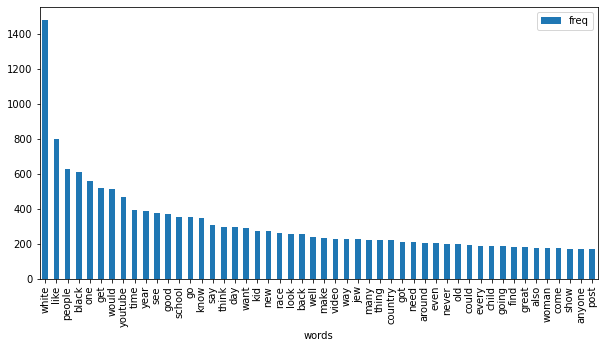

In [37]:
mcw.plot(x="words", y="freq", kind="bar", figsize=(10,5))
plt.show()

#### 3.1 Part of speech (POS)

In [38]:
from textblob import TextBlob
def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

In [39]:
print(TextBlob(data.iloc[4]["text_clean"]).tags)
print(TextBlob(data.iloc[4]["stemmed"]).tags)

[('click', 'NN'), ('download', 'NN'), ('megabytes', 'VBZ'), ('green', 'JJ'), ('banner', 'NN'), ('link', 'NN')]
[('click', 'NN'), ('download', 'NN'), ('megabyt', 'NN'), ('green', 'JJ'), ('banner', 'NN'), ('link', 'NN')]


In [40]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [41]:
data['POS_spacy'] = data['lemmatized'].progress_apply(lambda x: [(token.text, token.pos_) for token in nlp(x)])

100%|██████████| 10926/10926 [02:14<00:00, 81.23it/s] 


In [42]:
all_pos = data['POS_spacy'].sum()

In [43]:
all_adjs = [x[0] for x in all_pos if x[1] == "ADJ"]
all_nouns = [x[0] for x in all_pos if x[1] == "NOUN"]

In [44]:
hate = data.loc[data["label"] == 1]

In [45]:
hate.shape[0], data.shape[0] # 1428 over 10926 rows

(1428, 10926)

In [46]:
data.label.value_counts()

0    9498
1    1428
Name: label, dtype: int64

In [47]:
all_pos_hate = hate['POS_spacy'].sum()

In [48]:
all_adjs_hate = [x[0] for x in all_pos_hate if x[1] == "ADJ"]
all_nouns_hate = [x[0] for x in all_pos_hate if x[1] == "NOUN"]

In [49]:
adj_counter = {}
for word in all_adjs:
    if word in adj_counter:
        adj_counter[word] += 1
    else:
        adj_counter[word] = 1

top_20_adj = {k: v for k, v in sorted(adj_counter.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_adj, orient="index", columns=["Freq"]).reset_index()

In [50]:
noun_counter = {}
for word in all_nouns:
    if word in noun_counter:
        noun_counter[word] += 1
    else:
        noun_counter[word] = 1
            
top_20_noun = {k: v for k, v in sorted(noun_counter.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_noun, orient="index", columns=["Freq"]).reset_index()

In [51]:
adj_counter1 = {}
for word in all_adjs_hate:
    if word in adj_counter1:
        adj_counter1[word] += 1
    else:
        adj_counter1[word] = 1
            
top_20_adj1 = {k: v for k, v in sorted(adj_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_adj1, orient="index", columns=["Freq"]).reset_index()

In [52]:
noun_counter1 = {}
for word in all_nouns_hate:
    if word in noun_counter1:
        noun_counter1[word] += 1
    else:
        noun_counter1[word] = 1
            
top_20_noun1 = {k: v for k, v in sorted(noun_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_noun1, orient="index", columns=["Freq"]).reset_index()

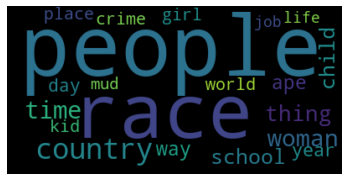

In [53]:
from wordcloud import WordCloud
wc = WordCloud().generate_from_frequencies(top_20_noun1)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

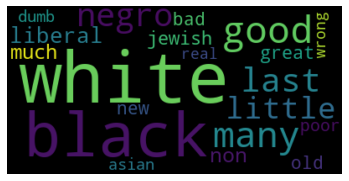

In [54]:
wc = WordCloud().generate_from_frequencies(top_20_adj1)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [55]:
top_noun = {"Total": top_20_noun.keys(), "Freq_Total": top_20_noun.values(), "Hate_Speech": top_20_noun1.keys(), "Freq_Hate": top_20_noun1.values()}
top_noun = pd.DataFrame(top_noun)
top_noun["R_Freq_Total"] = top_noun.apply(lambda x: np.round(x.Freq_Total / top_noun.Freq_Total.sum(), 3), axis=1)
top_noun["R_Freq_Hate"] = top_noun.apply(lambda x: np.round(x.Freq_Hate / top_noun.Freq_Hate.sum(), 3), axis=1)
top_noun = top_noun.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_noun

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,people,0.146,people,0.138
1,time,0.086,race,0.111
2,year,0.085,country,0.087
3,school,0.064,time,0.063
4,race,0.059,woman,0.058
5,day,0.054,thing,0.054
6,thing,0.049,child,0.051
7,country,0.048,school,0.051
8,video,0.044,way,0.043
9,child,0.044,ape,0.043


In [56]:
common_nouns = list(set(top_noun["Hate_Speech"].values).union(set(top_noun["Total"].values)))

In [57]:
freq_common_tot = [noun_counter[x] for x in common_nouns]
freq_common_hate = [noun_counter1[x] for x in common_nouns]

In [58]:
common_noun_df = pd.DataFrame({"Nouns" : common_nouns, "Freq_tot": freq_common_tot, "Freq_Hate_Speech": freq_common_hate })

In [59]:
common_noun_df.sort_values(by=["Freq_Hate_Speech"], ascending= False, inplace=True)

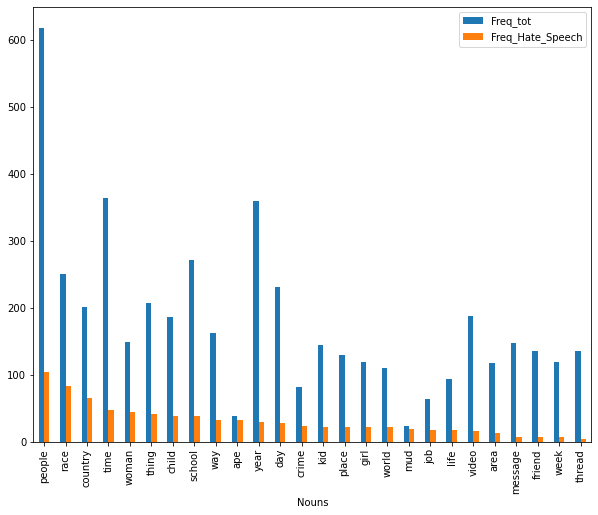

In [60]:
common_noun_df.plot('Nouns', y=['Freq_tot', 'Freq_Hate_Speech'], kind='bar', figsize=(10,8))
plt.show()

In [61]:
top_adj = {"Total": top_20_adj.keys(), "Freq_Total": top_20_adj.values(), "Hate_Speech": top_20_adj1.keys(), "Freq_Hate": top_20_adj1.values()}
top_adj = pd.DataFrame(top_adj)
top_adj["R_Freq_Total"] = top_adj.apply(lambda x: np.round(x.Freq_Total / top_adj.Freq_Total.sum(), 3), axis=1)
top_adj["R_Freq_Hate"] = top_adj.apply(lambda x: np.round(x.Freq_Hate / top_adj.Freq_Hate.sum(), 3), axis=1)
top_adj = top_adj.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_adj

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,white,0.244,white,0.290
1,black,0.128,black,0.211
2,good,0.096,good,0.051
3,many,0.064,many,0.046
4,new,0.052,last,0.040
5,old,0.051,negro,0.038
6,last,0.045,little,0.033
7,great,0.042,liberal,0.029
8,little,0.033,non,0.028
9,much,0.032,much,0.027


In [62]:
common_adj = list(set(top_adj["Hate_Speech"].values).union(set(top_adj["Total"].values)))

In [63]:
freq_common_tot_adj = [adj_counter[x] for x in common_adj]
freq_common_hate_adj = [adj_counter1[x] for x in common_adj]

In [64]:
common_adj_df = pd.DataFrame({"Adj" : common_adj, "Freq_tot": freq_common_tot_adj, "Freq_Hate_Speech": freq_common_hate_adj })

In [65]:
common_adj_df.sort_values(by=["Freq_Hate_Speech"], ascending= False, inplace=True)

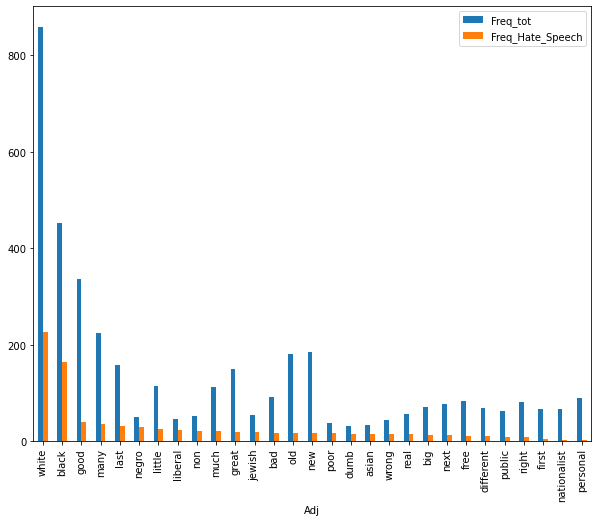

In [66]:
common_adj_df.plot(x='Adj', y=['Freq_tot', 'Freq_Hate_Speech'], kind='bar', figsize=(10,8))
plt.show()

In [67]:
pos_counter = {}
for x in all_pos:
    if x[1] in pos_counter:
        pos_counter[x[1]] += 1
    else:
        pos_counter[x[1]] = 1
        
top_pos = {k: v for k, v in sorted(pos_counter.items(), key=lambda item: item[1], reverse=True)}

In [68]:
freq_pos = pd.DataFrame.from_dict(top_pos, orient="index", columns=["Freq"]).reset_index()
freq_pos["R_Freq"] = freq_pos.apply(lambda x: np.round(x.Freq / freq_pos.Freq.sum(), 2), axis=1)

In [69]:
pos_counter_hate = {}
for x in all_pos_hate:
    if x[1] in pos_counter_hate:
        pos_counter_hate[x[1]] += 1
    else:
        pos_counter_hate[x[1]] = 1
        
top_pos_hate = {k: v for k, v in sorted(pos_counter_hate.items(), key=lambda item: item[1], reverse=True)}

In [70]:
freq_pos_hate = pd.DataFrame.from_dict(top_pos_hate, orient="index", columns=["Freq"]).reset_index()
freq_pos_hate["R_Freq"] = freq_pos_hate.apply(lambda x: np.round(x.Freq / freq_pos_hate.Freq.sum(), 2), axis=1)

In [71]:
compared_pos = {"Total": top_pos.keys(), "Freq_Total": top_pos.values(), "Hate_Speech": top_pos_hate.keys(), "Freq_Hate": top_pos_hate.values()}
compared_pos = pd.DataFrame(compared_pos)
compared_pos["R_Freq_Total"] = compared_pos.apply(lambda x: np.round(x.Freq_Total / compared_pos.Freq_Total.sum(), 3), axis=1)
compared_pos["R_Freq_Hate"] = compared_pos.apply(lambda x: np.round(x.Freq_Hate / compared_pos.Freq_Hate.sum(), 3), axis=1)
compared_pos = compared_pos.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
compared_pos[:7]

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,NOUN,0.291,NOUN,0.284
1,PROPN,0.236,PROPN,0.228
2,VERB,0.205,VERB,0.211
3,ADJ,0.133,ADJ,0.149
4,ADV,0.059,ADV,0.060
5,PRON,0.013,SCONJ,0.012
6,INTJ,0.012,PRON,0.011


# SPELLING

In [72]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [73]:
def unusual_words(text):
    text_vocab = set(w.lower() for w in text if w.isalpha())
    english_vocab = set(w.lower() for w in nltk.corpus.words.words())
    unusual = text_vocab.difference(english_vocab)
    return sorted(unusual)

In [74]:
crt = unusual_words(data['lemmatized'])
print(crt)

['africa', 'aragorn', 'asked', 'asking', 'asmodean', 'bb', 'braun', 'btl', 'calman', 'camie', 'cf', 'cheaper', 'congrats', 'contradicting', 'cripppinnn', 'czynski', 'dallas', 'dc', 'downloads', 'dr', 'dublin', 'ebonics', 'edmonton', 'elmira', 'embarassing', 'fbi', 'gille', 'groupid', 'gyspsies', 'haha', 'hahahahahaha', 'heil', 'hups', 'hz', 'ii', 'iii', 'im', 'internet', 'iv', 'jpg', 'kaboom', 'kid', 'kidding', 'kr', 'lk', 'located', 'lol', 'meh', 'minnesota', 'mmm', 'motivated', 'mrbadgersir', 'msciwoj', 'muahaha', 'needed', 'neofolk', 'nigga', 'okay', 'opendocument', 'opps', 'patrioticmama', 'pawel', 'pffffft', 'politifuldm', 'reproducing', 'rumour', 'stormfront', 'studying', 'sveiks', 'swva', 'tereasa', 'tf', 'threadid', 'tnb', 'topix', 'tv', 'twp', 'ty', 'usa', 'vancouver', 'weku', 'wellsburg', 'whiteutopian', 'wierd', 'wiki', 'wntube', 'wp', 'wpww', 'wrs', 'wulfi', 'wv', 'youtube', 'yuenglings', 'yup', 'zdrowie']


In [75]:
corrected_w =[TextBlob(word).correct().words[0] for word in crt]
corrected_w

['africa',
 'dragoon',
 'asked',
 'asking',
 'asmodean',
 'by',
 'brain',
 'bal',
 'cabman',
 'came',
 'cf',
 'cheaper',
 'congress',
 'contradicting',
 'cripppinnn',
 'czynski',
 'dallas',
 'do',
 'download',
 'dr',
 'dublin',
 'tonics',
 'edmonton',
 'eliza',
 'embarrassing',
 'foi',
 'ville',
 'grouped',
 'gypsies',
 'hata',
 'hahahahahaha',
 'heal',
 'huts',
 'he',
 'ii',
 'iii',
 'in',
 'internet',
 'iv',
 'pg',
 'boom',
 'kid',
 'bidding',
 'or',
 'll',
 'located',
 'll',
 'me',
 'minnesota',
 'mmm',
 'motivate',
 'mrbadgersir',
 'msciwoj',
 'muahaha',
 'needed',
 'norfolk',
 'night',
 'okay',
 'opendocument',
 'open',
 'patrioticmama',
 'panel',
 'pffffft',
 'politifuldm',
 'reproducing',
 'rumour',
 'stormfront',
 'studying',
 'veins',
 'saw',
 'theresa',
 'of',
 'thread',
 'tub',
 'topic',
 'to',
 'two',
 'ty',
 'us',
 'vancouver',
 'wetu',
 'wellsburg',
 'whiteutopian',
 'wired',
 'wiki',
 'tube',
 'up',
 'www',
 'was',
 'wolf',
 'we',
 'couture',
 'yuenglings',
 'up',
 'zdro

In [76]:
from autocorrect import Speller
def autocorr(text):
    crt = unusual_words(text)
    for t in crt:
        auto = Speller(lang='en')
        corr = auto(t)
        if t != corr:
            print(t, corr)

In [77]:
autocorr(data['lemmatized']) ##

aragorn dragon
btl bl
calman salman
camie came
congrats contrast
elmira lira
embarassing embarrassing
gille ville
groupid grouped
heil heir
hups ups
kaboom boom
neofolk norfolk
nigga nigra
opps apps
pawel panel
pffffft ffffff
stormfront storefront
sveiks speaks
swva swa
tereasa teresa
threadid threaded
tnb nb
topix topic
weku wek
wierd weird
wntube tube
wpww www
wulfi multi


In [78]:
# sentiment polarity TEXTBLOB https://textblob.readthedocs.io/en/dev/quickstart.html

# 4. MODELS

In [160]:
tfidf_vectorizer = TfidfVectorizer()
X_class = tfidf_vectorizer.fit_transform(data['lemmatized'])
y_class = data["label"]
X_class.shape

(10926, 12731)

In [161]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42, stratify=y_class)

In [162]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn as sk
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
random_state = np.random.RandomState(0)


Multinomial Naive Bayes - Original dataset

              precision    recall  f1-score   support

           0       0.69      0.57      0.62       429
           1       0.63      0.74      0.68       428

    accuracy                           0.65       857
   macro avg       0.66      0.65      0.65       857
weighted avg       0.66      0.65      0.65       857

0.6546091015169195


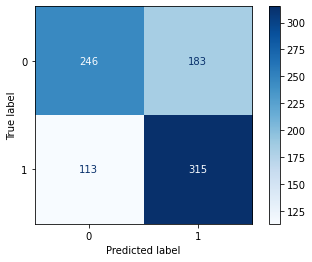

In [197]:
# Multinomial Naive Bayes
mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train, y_train)
y_mnb = mnb.predict(X_test)
as_mnb = accuracy_score(y_test, y_mnb)
f1s_mnb = f1_score(y_test, y_mnb, average= "macro")
prec_mnb = precision_score(y_test, y_mnb)
rec_mnb = recall_score(y_test, y_mnb, average='macro')
print("\nMultinomial Naive Bayes - Original dataset\n")
plot_confusion_matrix(mnb, X_test,y_test, cmap= "Blues")
#print(confusion_matrix(y_test,y_mnb))
print(classification_report(y_test,y_mnb))
print(accuracy_score(y_test, y_mnb))

[LibSVM]
Support Vector Machine - Original dataset

              precision    recall  f1-score   support

           0       0.69      0.76      0.73       429
           1       0.74      0.66      0.70       428

    accuracy                           0.71       857
   macro avg       0.72      0.71      0.71       857
weighted avg       0.71      0.71      0.71       857

0.7129521586931156


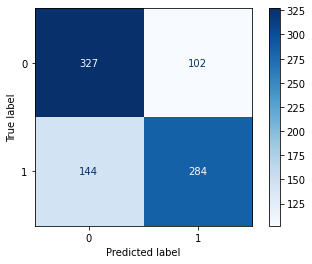

In [198]:
# Support Vector Machine
svc = SVC(verbose=10, random_state=42)
svc.fit(X_train, y_train)
y_svc = svc.predict(X_test)
as_svc = accuracy_score(y_test, y_svc)
f1s_svc = f1_score(y_test, y_svc, average="macro")
prec_svc = precision_score(y_test, y_svc)
rec_svc = recall_score(y_test, y_svc, average='macro')
print("\nSupport Vector Machine - Original dataset\n")
plot_confusion_matrix(svc, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc))
print(classification_report(y_test,y_svc))
print(accuracy_score(y_test, y_svc))


Logistic Regression - Original dataset

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       429
           1       0.76      0.67      0.71       428

    accuracy                           0.73       857
   macro avg       0.73      0.73      0.73       857
weighted avg       0.73      0.73      0.73       857

0.7269544924154026


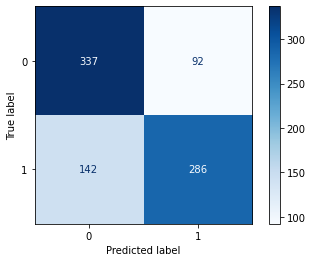

In [199]:
# Logistic
log_fit = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log = log_fit.predict(X_test)
as_log = accuracy_score(y_test, y_log)
f1s_log = f1_score(y_test, y_log, average= "macro")
prec_log = precision_score(y_test, y_log)
rec_log = recall_score(y_test, y_log, average='macro')
print("\nLogistic Regression - Original dataset\n")
plot_confusion_matrix(log_fit, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log))
print(classification_report(y_test,y_log))
print(accuracy_score(y_test, y_log))


Random Forest - Original dataset

              precision    recall  f1-score   support

           0       0.66      0.79      0.72       429
           1       0.73      0.59      0.65       428

    accuracy                           0.69       857
   macro avg       0.70      0.69      0.69       857
weighted avg       0.70      0.69      0.69       857

0.6884480746791132


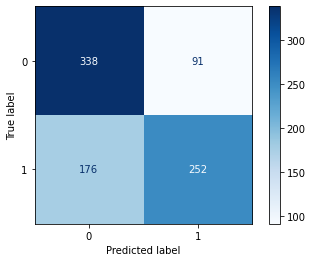

In [200]:
# Random Forest
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train) 
y_rf = rf.predict(X_test)
as_rf = accuracy_score(y_test, y_rf)
f1s_rf = f1_score(y_test, y_rf, average= "macro")
prec_rf = precision_score(y_test, y_rf)
rec_rf = recall_score(y_test, y_rf, average='macro')
print("\nRandom Forest - Original dataset\n")
plot_confusion_matrix(rf, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf))
print(classification_report(y_test,y_rf))
print(accuracy_score(y_test, y_rf))

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Networks - Original dataset

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       429
           1       0.71      0.67      0.69       428

    accuracy                           0.70       857
   macro avg       0.70      0.70      0.70       857
weighted avg       0.70      0.70      0.70       857

0.7001166861143524


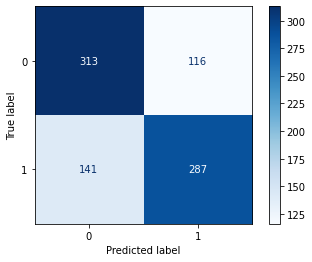

In [201]:
# Neural Networks
NN = MLPClassifier(random_state=42, max_iter=30)
NN.fit(X_train, y_train)
y_NN = NN.predict(X_test)
as_NN = accuracy_score(y_test, y_NN)
f1s_NN = f1_score(y_test, y_NN, average= "macro")
prec_NN = precision_score(y_test, y_NN)
rec_NN = recall_score(y_test, y_NN, average='macro')
print("\nNeural Networks - Original dataset\n")
plot_confusion_matrix(NN, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_NN))
print(classification_report(y_test,y_NN))
print(accuracy_score(y_test, y_NN))


Decision Tree - Original dataset

              precision    recall  f1-score   support

           0       0.67      0.70      0.69       429
           1       0.69      0.66      0.67       428

    accuracy                           0.68       857
   macro avg       0.68      0.68      0.68       857
weighted avg       0.68      0.68      0.68       857

0.6814469078179697


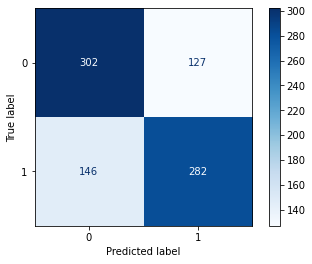

In [202]:
# Decision Tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)
as_tree = accuracy_score(y_test, y_tree)
f1s_tree = f1_score(y_test, y_tree, average= "macro")
prec_tree = precision_score(y_test, y_tree)
rec_tree = recall_score(y_test, y_tree, average='macro')
print("\nDecision Tree - Original dataset\n")
plot_confusion_matrix(tree, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree))
print(classification_report(y_test,y_tree))
print(accuracy_score(y_test, y_tree))


K-Nearest Neighbors - Original dataset

              precision    recall  f1-score   support

           0       0.51      0.99      0.67       429
           1       0.81      0.03      0.06       428

    accuracy                           0.51       857
   macro avg       0.66      0.51      0.36       857
weighted avg       0.66      0.51      0.37       857

0.5122520420070011


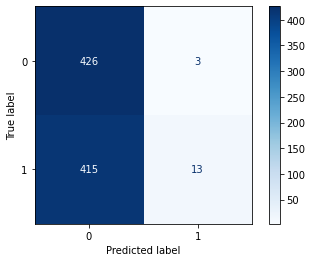

In [203]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)
as_knn = accuracy_score(y_test, y_knn)
f1s_knn = f1_score(y_test, y_knn, average= "macro")
prec_knn = precision_score(y_test, y_knn)
rec_knn = recall_score(y_test, y_knn, average='macro')
print("\nK-Nearest Neighbors - Original dataset\n")
plot_confusion_matrix(knn, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_knn))
print(classification_report(y_test,y_knn))
print(accuracy_score(y_test, y_knn))

In [89]:
s1 = pd.Series([as_mnb, as_svc, as_log, as_rf, as_NN, as_tree, as_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2 = pd.Series([f1s_mnb, f1s_svc, f1s_log, f1s_rf, f1s_NN, f1s_tree, f1s_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3 = pd.Series([prec_mnb, prec_svc, prec_log, prec_rf, prec_NN, prec_tree, prec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4 = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d = {'Accuracy Score' : s1, 'Precision Score': s3, 'Recall Score' : s4, 'F1 Score' : s2 }
dfm = pd.DataFrame(d)
print("\nOriginal dataset\n")
dfm.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


Original dataset



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.854484,0.405405,0.595646,0.612201
Support Vector Machine,0.874924,0.875000,0.524006,0.512876
Logistic Regression,0.874619,0.717949,0.530780,0.526208
Random Forest,0.875839,0.636364,0.552331,0.563399
Neural Networks,0.859365,0.437736,0.609374,0.628074
Decision Tree,0.848688,0.410526,0.642945,0.649924
K-Nearest Neighbors,0.872178,1.000000,0.510514,0.486357


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.88')

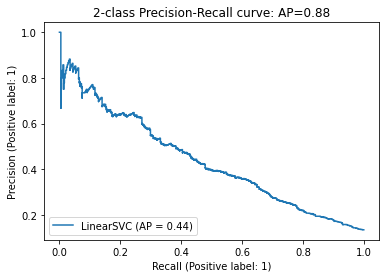

In [90]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(X_train, y_train)

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prec_svc))

# 4.1 Imbalanced

In [181]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler 
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)

In [182]:
X_over, y_over = undersample.fit_resample(X_class, y_class)

In [183]:
from collections import Counter
print(Counter(y_over))

Counter({0: 1428, 1: 1428})


In [184]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42, stratify=y_over)


Multinomoial Naive Bayes - Balanced dataset

              precision    recall  f1-score   support

           0       0.69      0.57      0.62       429
           1       0.63      0.74      0.68       428

    accuracy                           0.65       857
   macro avg       0.66      0.65      0.65       857
weighted avg       0.66      0.65      0.65       857

0.6546091015169195


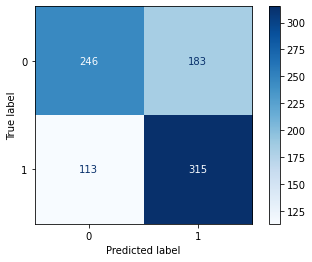

In [196]:
# Multinomial Naive Bayes
mnb_i = MultinomialNB(alpha=0.01)
mnb_i.fit(X_train, y_train)
y_mnb_i = mnb_i.predict(X_test)
as_mnb_i = accuracy_score(y_test, y_mnb_i)
f1s_mnb_i = f1_score(y_test, y_mnb_i, average= "macro")
prec_mnb_i = precision_score(y_test, y_mnb_i)
rec_mnb_i = recall_score(y_test, y_mnb_i, average='macro')
print("\nMultinomoial Naive Bayes - Balanced dataset\n")
plot_confusion_matrix(mnb_i, X_test,y_test, cmap = "Blues")
#print(confusion_matrix(y_test,y_mnb_i))
print(classification_report(y_test,y_mnb_i))
print(accuracy_score(y_test, y_mnb_i))

[LibSVM]
Support Vector Machine - Balanced dataset

              precision    recall  f1-score   support

           0       0.69      0.76      0.73       429
           1       0.74      0.66      0.70       428

    accuracy                           0.71       857
   macro avg       0.72      0.71      0.71       857
weighted avg       0.71      0.71      0.71       857

0.7129521586931156


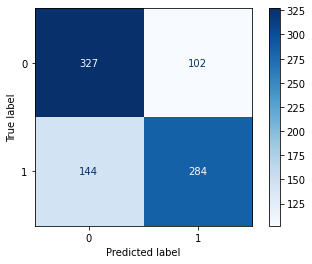

In [190]:
# Support Vector Machine
svc_i = SVC(verbose=10, random_state=42)
svc_i.fit(X_train, y_train)
y_svc_i = svc_i.predict(X_test)
as_svc_i = accuracy_score(y_test, y_svc_i)
f1s_svc_i = f1_score(y_test, y_svc_i, average="macro")
prec_svc_i = precision_score(y_test, y_svc_i)
rec_svc_i = recall_score(y_test, y_svc_i, average='macro')
print("\nSupport Vector Machine - Balanced dataset\n")
plot_confusion_matrix(svc_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc_i))
print(classification_report(y_test,y_svc_i))
print(accuracy_score(y_test, y_svc_i))


Logistic Regression - Balanced dataset

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       429
           1       0.76      0.67      0.71       428

    accuracy                           0.73       857
   macro avg       0.73      0.73      0.73       857
weighted avg       0.73      0.73      0.73       857

0.7269544924154026


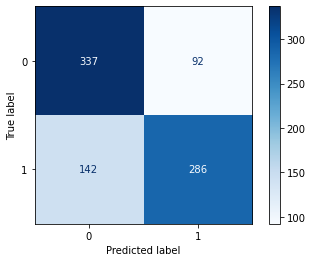

In [191]:
# Logistic
log_fit_i = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_i = log_fit_i.predict(X_test)
as_log_i = accuracy_score(y_test, y_log_i)
f1s_log_i = f1_score(y_test, y_log_i, average= "macro")
prec_log_i = precision_score(y_test, y_log_i)
rec_log_i = recall_score(y_test, y_log_i, average='macro')
print("\nLogistic Regression - Balanced dataset\n")
plot_confusion_matrix(log_fit_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log_i))
print(classification_report(y_test,y_log_i))
print(accuracy_score(y_test, y_log_i))


Random Forest - Balanced dataset

              precision    recall  f1-score   support

           0       0.66      0.79      0.72       429
           1       0.73      0.59      0.65       428

    accuracy                           0.69       857
   macro avg       0.70      0.69      0.69       857
weighted avg       0.70      0.69      0.69       857

0.6884480746791132


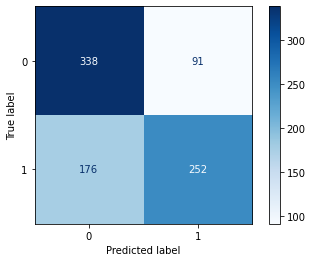

In [192]:
# Random Forest
rf_i = RandomForestClassifier(n_estimators=10, random_state=42)
rf_i.fit(X_train, y_train) 
y_rf_i = rf_i.predict(X_test)
as_rf_i = accuracy_score(y_test, y_rf_i)
f1s_rf_i = f1_score(y_test, y_rf_i, average= "macro")
prec_rf_i = precision_score(y_test, y_rf_i)
rec_rf_i = recall_score(y_test, y_rf_i, average='macro')
print("\nRandom Forest - Balanced dataset\n")
plot_confusion_matrix(rf_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf_i))
print(classification_report(y_test,y_rf_i))
print(accuracy_score(y_test, y_rf_i))

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Networks - Balanced dataset

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       429
           1       0.71      0.67      0.69       428

    accuracy                           0.70       857
   macro avg       0.70      0.70      0.70       857
weighted avg       0.70      0.70      0.70       857

0.7001166861143524


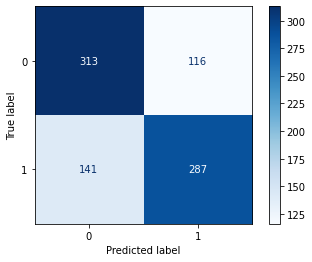

In [193]:
# Neural Networks
NN_i = MLPClassifier(random_state=42, max_iter=30)
NN_i.fit(X_train, y_train)
#NN.score(X_test, y_test)
y_NN_i = NN_i.predict(X_test)
as_NN_i = accuracy_score(y_test, y_NN_i)
f1s_NN_i = f1_score(y_test, y_NN_i, average= "macro")
prec_NN_i = precision_score(y_test, y_NN_i)
rec_NN_i = recall_score(y_test, y_NN_i, average='macro')
print("\nNeural Networks - Balanced dataset\n")
plot_confusion_matrix(NN_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_NN_i))
print(classification_report(y_test,y_NN_i))
print(accuracy_score(y_test, y_NN_i))


Decision Tree - Balanced dataset

              precision    recall  f1-score   support

           0       0.67      0.70      0.69       429
           1       0.69      0.66      0.67       428

    accuracy                           0.68       857
   macro avg       0.68      0.68      0.68       857
weighted avg       0.68      0.68      0.68       857

0.6814469078179697


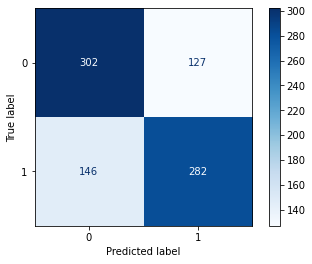

In [194]:
# Decision Tree
tree_i = DecisionTreeClassifier(random_state=42)
tree_i.fit(X_train, y_train)
y_tree_i = tree_i.predict(X_test)
as_tree_i = accuracy_score(y_test, y_tree_i)
f1s_tree_i = f1_score(y_test, y_tree_i, average= "macro")
prec_tree_i = precision_score(y_test, y_tree_i)
rec_tree_i = recall_score(y_test, y_tree_i, average='macro')
print("\nDecision Tree - Balanced dataset\n")
plot_confusion_matrix(tree_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree_i))
print(classification_report(y_test,y_tree_i))
print(accuracy_score(y_test, y_tree_i))


K-Nearest Neighbors - Balanced dataset

              precision    recall  f1-score   support

           0       0.51      0.99      0.67       429
           1       0.81      0.03      0.06       428

    accuracy                           0.51       857
   macro avg       0.66      0.51      0.36       857
weighted avg       0.66      0.51      0.37       857

0.5122520420070011


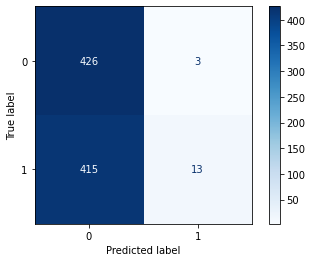

In [195]:
# K-Nearest Neighbors
knn_i = KNeighborsClassifier()
knn_i.fit(X_train, y_train)
y_knn_i = knn_i.predict(X_test)
as_knn_i = accuracy_score(y_test, y_knn_i)
f1s_knn_i = f1_score(y_test, y_knn_i, average= "macro")
prec_knn_i = precision_score(y_test, y_knn_i)
rec_knn_i = recall_score(y_test, y_knn_i, average='macro')
print("\nK-Nearest Neighbors - Balanced dataset\n")
plot_confusion_matrix(knn_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_knn_i))
print(classification_report(y_test,y_knn_i))
print(accuracy_score(y_test, y_knn_i))

In [102]:
s1_i = pd.Series([as_mnb_i, as_svc_i, as_log_i, as_rf_i, as_NN_i, as_tree_i, as_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_i = pd.Series([f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_NN_i, f1s_tree_i, f1s_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_i = pd.Series([prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_NN_i, prec_tree_i, prec_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_i = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_i = {'Accuracy Score' : s1_i, 'Precision Score': s3_i, 'Recall Score' : s4_i, 'F1 Score' : s2_i}
dfm_i = pd.DataFrame(d_i)
print("\nBalanced dataset\n")
dfm_i.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


Balanced dataset



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.654609,0.632530,0.595646,0.652356
Support Vector Machine,0.712952,0.735751,0.524006,0.712228
Logistic Regression,0.726954,0.756614,0.530780,0.725984
Random Forest,0.688448,0.734694,0.552331,0.685279
Neural Networks,0.700117,0.712159,0.609374,0.699840
Decision Tree,0.681447,0.689487,0.642945,0.681273
K-Nearest Neighbors,0.512252,0.812500,0.510514,0.364712


## 4.2 Models on POS

In [103]:
def filter_text_pos(x):
    final_pos_text = []
    for elem in x:
        for pos in pos_list:
            if elem[1] == pos:
                final_pos_text.append(elem[0])
    
    return " ".join(final_pos_text)

### 4.2.1 Proper Nouns

In [212]:
pos_list = ["PROPN"]

In [213]:
data["PROPN"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [214]:
tfidf_vectorizer = TfidfVectorizer()
X_Propn = tfidf_vectorizer.fit_transform(data["PROPN"])
y_Propn = data["label"]
X_Propn.shape

(10926, 6632)

In [215]:
X_over_p, y_over_p = undersample.fit_resample(X_Propn, y_Propn)

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X_over_p, y_over_p, test_size=0.3, random_state=42, stratify=y_over_p)


Multinomoial Naive Bayes - PROPN

              precision    recall  f1-score   support

           0       0.59      0.36      0.45       429
           1       0.54      0.75      0.63       428

    accuracy                           0.55       857
   macro avg       0.56      0.55      0.54       857
weighted avg       0.56      0.55      0.54       857

0.5542590431738623


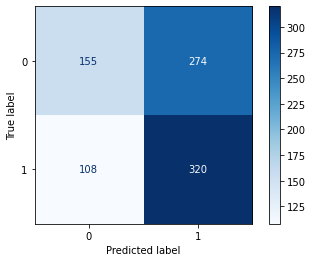

In [218]:
# Multinomial Naive Bayes
mnb_p = MultinomialNB(alpha=0.01)
mnb_p.fit(X_train, y_train)
y_mnb_p = mnb_p.predict(X_test)
as_mnb_p = accuracy_score(y_test, y_mnb_p)
f1s_mnb_p = f1_score(y_test, y_mnb_p, average= "macro")
prec_mnb_p = precision_score(y_test, y_mnb_p)
rec_mnb_p = recall_score(y_test, y_mnb_p, average='macro')
print("\nMultinomoial Naive Bayes - PROPN\n")
plot_confusion_matrix(mnb_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_mnb_p))
print(classification_report(y_test,y_mnb_p))
print(accuracy_score(y_test, y_mnb_p))

[LibSVM]
Support Vector Machine - PROPN

              precision    recall  f1-score   support

           0       0.62      0.66      0.64       429
           1       0.64      0.60      0.62       428

    accuracy                           0.63       857
   macro avg       0.63      0.63      0.63       857
weighted avg       0.63      0.63      0.63       857

0.6312718786464411


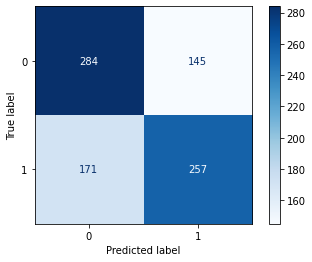

In [220]:
# Support Vector Machine
svc_p = SVC(verbose=10, random_state=42)
svc_p.fit(X_train, y_train)
y_svc_p = svc_p.predict(X_test)
as_svc_p = accuracy_score(y_test, y_svc_p)
f1s_svc_p = f1_score(y_test, y_svc_p, average="macro")
prec_svc_p = precision_score(y_test, y_svc_p)
rec_svc_p = recall_score(y_test, y_svc_p, average='macro')
print("\nSupport Vector Machine - PROPN\n")
plot_confusion_matrix(svc_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc_p))
print(classification_report(y_test,y_svc_p))
print(accuracy_score(y_test, y_svc_p))


Logistic Regression - PROPN

              precision    recall  f1-score   support

           0       0.61      0.87      0.71       429
           1       0.77      0.43      0.55       428

    accuracy                           0.65       857
   macro avg       0.69      0.65      0.63       857
weighted avg       0.69      0.65      0.63       857

0.6511085180863477


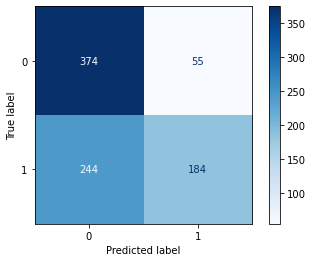

In [221]:
# Logistic
log_fit_p = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_p = log_fit_p.predict(X_test)
as_log_p = accuracy_score(y_test, y_log_p)
f1s_log_p = f1_score(y_test, y_log_p, average= "macro")
prec_log_p = precision_score(y_test, y_log_p)
rec_log_p = recall_score(y_test, y_log_p, average='macro')
print("\nLogistic Regression - PROPN\n")
plot_confusion_matrix(log_fit_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log_p))
print(classification_report(y_test,y_log_p))
print(accuracy_score(y_test, y_log_p))


Random Forest - PROPN

              precision    recall  f1-score   support

           0       0.59      0.84      0.70       429
           1       0.73      0.42      0.53       428

    accuracy                           0.63       857
   macro avg       0.66      0.63      0.61       857
weighted avg       0.66      0.63      0.61       857

0.6312718786464411


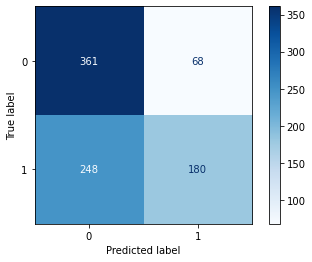

In [222]:
# Random Forest
rf_p = RandomForestClassifier(n_estimators=10, random_state=42)
rf_p.fit(X_train, y_train) 
y_rf_p = rf_p.predict(X_test)
as_rf_p = accuracy_score(y_test, y_rf_p)
f1s_rf_p = f1_score(y_test, y_rf_p, average= "macro")
prec_rf_p = precision_score(y_test, y_rf_p)
rec_rf_p = recall_score(y_test, y_rf_p, average='macro')
print("\nRandom Forest - PROPN\n")
plot_confusion_matrix(rf_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf_p))
print(classification_report(y_test,y_rf_p))
print(accuracy_score(y_test, y_rf_p))

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Networks - PROPN

              precision    recall  f1-score   support

           0       0.60      0.82      0.69       429
           1       0.71      0.45      0.55       428

    accuracy                           0.63       857
   macro avg       0.66      0.63      0.62       857
weighted avg       0.66      0.63      0.62       857

0.6347724620770129


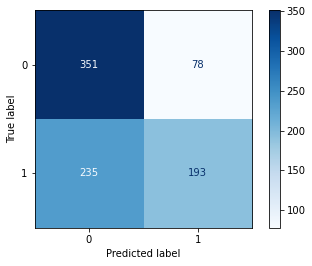

In [223]:
# Neural Networks
NN_p = MLPClassifier(random_state=42, max_iter=30)
NN_p.fit(X_train, y_train)
y_NN_p = NN_p.predict(X_test)
as_NN_p = accuracy_score(y_test, y_NN_p)
f1s_NN_p = f1_score(y_test, y_NN_p, average= "macro")
prec_NN_p = precision_score(y_test, y_NN_p)
rec_NN_p = recall_score(y_test, y_NN_p, average='macro')
print("\nNeural Networks - PROPN\n")
plot_confusion_matrix(NN_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_NN_p))
print(classification_report(y_test,y_NN_p))
print(accuracy_score(y_test, y_NN_p))


Decision Tree - PROPN

              precision    recall  f1-score   support

           0       0.60      0.88      0.71       429
           1       0.77      0.41      0.53       428

    accuracy                           0.64       857
   macro avg       0.69      0.64      0.62       857
weighted avg       0.69      0.64      0.62       857

0.6441073512252042


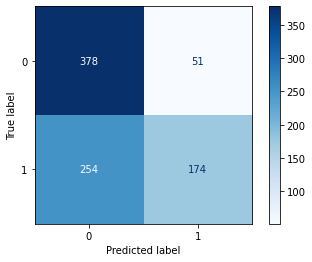

In [224]:
# Decision Tree
tree_p = DecisionTreeClassifier(random_state=42)
tree_p.fit(X_train, y_train)
y_tree_p = tree_p.predict(X_test)
as_tree_p = accuracy_score(y_test, y_tree_p)
f1s_tree_p = f1_score(y_test, y_tree_p, average= "macro")
prec_tree_p = precision_score(y_test, y_tree_p)
rec_tree_p = recall_score(y_test, y_tree_p, average='macro')
print("\nDecision Tree - PROPN\n")
plot_confusion_matrix(tree_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree_p))
print(classification_report(y_test,y_tree_p))
print(accuracy_score(y_test, y_tree_p))


K-Nearest Neighbors - PROPN

              precision    recall  f1-score   support

           0       0.56      0.86      0.68       429
           1       0.70      0.32      0.44       428

    accuracy                           0.59       857
   macro avg       0.63      0.59      0.56       857
weighted avg       0.63      0.59      0.56       857

0.5927654609101517


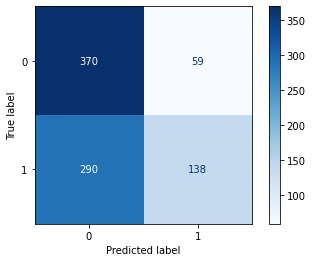

In [225]:
# K-Nearest Neighbors
knn_p = KNeighborsClassifier()
knn_p.fit(X_train, y_train)
y_knn_p = knn_p.predict(X_test)
as_knn_p = accuracy_score(y_test, y_knn_p)
f1s_knn_p = f1_score(y_test, y_knn_p, average= "macro")
prec_knn_p = precision_score(y_test, y_knn_p)
rec_knn_p = recall_score(y_test, y_knn_p, average='macro')
print("\nK-Nearest Neighbors - PROPN\n")
plot_confusion_matrix(knn_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_knn_p))
print(classification_report(y_test,y_knn_p))
print(accuracy_score(y_test, y_knn_p))

In [116]:
s1_i = pd.Series([as_mnb_i, as_svc_i, as_log_i, as_rf_i, as_NN_i, as_tree_i, as_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_i = pd.Series([f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_NN_i, f1s_tree_i, f1s_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_i = pd.Series([prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_NN_i, prec_tree_i, prec_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_i = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_i = {'Accuracy Score' : s1_i, 'Precision Score': s3_i, 'Recall Score' : s4_i, 'F1 Score' : s2_i}
dfm_i = pd.DataFrame(d_i)
print("\nPROPN\n")
dfm_i.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


PROPN



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.554259,0.538721,0.595646,0.537100
Support Vector Machine,0.631272,0.639303,0.524006,0.630906
Logistic Regression,0.651109,0.769874,0.530780,0.633073
Random Forest,0.631272,0.725806,0.552331,0.614056
Neural Networks,0.634772,0.712177,0.609374,0.621922
Decision Tree,0.644107,0.773333,0.642945,0.622730
K-Nearest Neighbors,0.592765,0.700508,0.510514,0.560561


In [117]:
# Considering only PROPN in tfidf and models, the results for "hate speech" (label = 1) have higher levels of precision, both wrt "no hate" (except Mnb) and also to other POS (ex: NOUN has Precision Score below 0.668).

### 4.2.2 Nouns + Proper Nouns + Verbs

In [226]:
pos_list = ["NOUN","PROPN", "VERB"]

In [227]:
data["NOUN_PROPN_VERB"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [228]:
tfidf_vectorizer = TfidfVectorizer()
X_NounPropnVerb = tfidf_vectorizer.fit_transform(data["NOUN_PROPN_VERB"])
y_NounPropnVerb = data["label"]
X_NounPropnVerb.shape

(10926, 11066)

In [229]:
X_over_n, y_over_n = undersample.fit_resample(X_NounPropnVerb, y_NounPropnVerb)

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X_over_n, y_over_n, test_size=0.3, random_state=42, stratify=y_over_n)


Multinomoial Naive Bayes - NOUN_PROPN_VERB

              precision    recall  f1-score   support

           0       0.68      0.56      0.61       429
           1       0.62      0.73      0.67       428

    accuracy                           0.65       857
   macro avg       0.65      0.65      0.64       857
weighted avg       0.65      0.65      0.64       857

0.6452742123687282


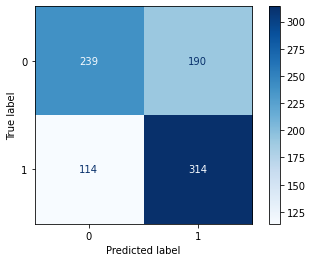

In [231]:
# Multinomial Naive Bayes
mnb_n = MultinomialNB(alpha=0.01)
mnb_n.fit(X_train, y_train)
y_mnb_n = mnb_n.predict(X_test)
as_mnb_n = accuracy_score(y_test, y_mnb_n)
f1s_mnb_n = f1_score(y_test, y_mnb_n, average= "macro")
prec_mnb_n = precision_score(y_test, y_mnb_n)
rec_mnb_n = recall_score(y_test, y_mnb_n, average='macro')
print("\nMultinomoial Naive Bayes - NOUN_PROPN_VERB\n")
plot_confusion_matrix(mnb_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_mnb_n))
print(classification_report(y_test,y_mnb_n))
print(accuracy_score(y_test, y_mnb_n))

[LibSVM]
Support Vector Machine - NOUN_PROPN_VERB

              precision    recall  f1-score   support

           0       0.68      0.75      0.71       429
           1       0.72      0.64      0.68       428

    accuracy                           0.70       857
   macro avg       0.70      0.70      0.70       857
weighted avg       0.70      0.70      0.70       857

0.6966161026837806


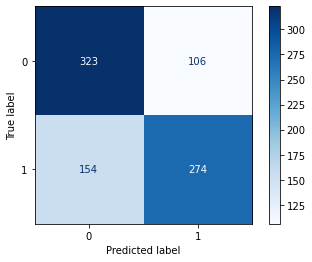

In [233]:
# Support Vector Machine
svc_n = SVC(verbose=10, random_state=42)
svc_n.fit(X_train, y_train)
y_svc_n = svc_n.predict(X_test)
as_svc_n = accuracy_score(y_test, y_svc_n)
f1s_svc_n = f1_score(y_test, y_svc_n, average="macro")
prec_svc_n = precision_score(y_test, y_svc_n)
rec_svc_n = recall_score(y_test, y_svc_n, average='macro')
print("\nSupport Vector Machine - NOUN_PROPN_VERB\n")
plot_confusion_matrix(svc_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc_n)
print(classification_report(y_test,y_svc_n))
print(accuracy_score(y_test, y_svc_n))


Logistic Regression - NOUN_PROPN_VERB

              precision    recall  f1-score   support

           0       0.68      0.78      0.72       429
           1       0.74      0.63      0.68       428

    accuracy                           0.70       857
   macro avg       0.71      0.70      0.70       857
weighted avg       0.71      0.70      0.70       857

0.7036172695449242


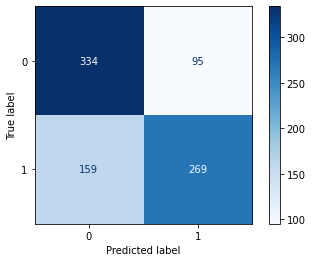

In [235]:
# Logistic
log_fit_n = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_n = log_fit_n.predict(X_test)
as_log_n = accuracy_score(y_test, y_log_n)
f1s_log_n = f1_score(y_test, y_log_n, average= "macro")
prec_log_n = precision_score(y_test, y_log_n)
rec_log_n = recall_score(y_test, y_log_n, average='macro')
print("\nLogistic Regression - NOUN_PROPN_VERB\n")
plot_confusion_matrix(log_fit_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log_n))
print(classification_report(y_test,y_log_n))
print(accuracy_score(y_test, y_log_n))


Random Forest - NOUN_PROPN_VERB

              precision    recall  f1-score   support

           0       0.64      0.77      0.70       429
           1       0.71      0.56      0.63       428

    accuracy                           0.67       857
   macro avg       0.67      0.67      0.66       857
weighted avg       0.67      0.67      0.66       857

0.6662777129521587


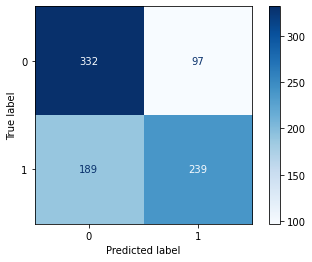

In [236]:
# Random Forest
rf_n = RandomForestClassifier(n_estimators=10, random_state=42)
rf_n.fit(X_train, y_train) 
y_rf_n = rf_n.predict(X_test)
as_rf_n = accuracy_score(y_test, y_rf_n)
f1s_rf_n = f1_score(y_test, y_rf_n, average= "macro")
prec_rf_n = precision_score(y_test, y_rf_n)
rec_rf_n = recall_score(y_test, y_rf_n, average='macro')
print("\nRandom Forest - NOUN_PROPN_VERB\n")
plot_confusion_matrix(rf_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf_n))
print(classification_report(y_test,y_rf_n))
print(accuracy_score(y_test, y_rf_n))

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Networks - NOUN_PROPN_VERB

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       429
           1       0.72      0.68      0.70       428

    accuracy                           0.71       857
   macro avg       0.71      0.71      0.71       857
weighted avg       0.71      0.71      0.71       857

0.7071178529754959


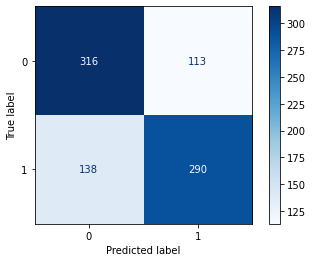

In [237]:
# Neural Networks
NN_n = MLPClassifier(random_state=42, max_iter=30)
NN_n.fit(X_train, y_train)
y_NN_n = NN_n.predict(X_test)
as_NN_n = accuracy_score(y_test, y_NN_n)
f1s_NN_n = f1_score(y_test, y_NN_n, average= "macro")
prec_NN_n = precision_score(y_test, y_NN_n)
rec_NN_n = recall_score(y_test, y_NN_n, average='macro')
print("\nNeural Networks - NOUN_PROPN_VERB\n")
plot_confusion_matrix(NN_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_NN_n))
print(classification_report(y_test,y_NN_n))
print(accuracy_score(y_test, y_NN_n))


Decision Tree - NOUN_PROPN_VERB

              precision    recall  f1-score   support

           0       0.62      0.69      0.66       429
           1       0.65      0.58      0.62       428

    accuracy                           0.64       857
   macro avg       0.64      0.64      0.64       857
weighted avg       0.64      0.64      0.64       857

0.6371061843640606


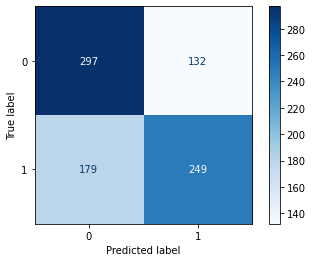

In [239]:
# Decision Tree
tree_n = DecisionTreeClassifier(random_state=42)
tree_n.fit(X_train, y_train)
y_tree_n = tree_n.predict(X_test)
as_tree_n = accuracy_score(y_test, y_tree_n)
f1s_tree_n = f1_score(y_test, y_tree_n, average= "macro")
prec_tree_n = precision_score(y_test, y_tree_n)
rec_tree_n = recall_score(y_test, y_tree_n, average='macro')
print("\nDecision Tree - NOUN_PROPN_VERB\n")
plot_confusion_matrix(tree_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree_n))
print(classification_report(y_test,y_tree_n))
print(accuracy_score(y_test, y_tree_n))


K-Nearest Neighbors - NOUN_PROPN_VERB

              precision    recall  f1-score   support

           0       0.50      0.88      0.64       429
           1       0.49      0.11      0.19       428

    accuracy                           0.50       857
   macro avg       0.50      0.50      0.41       857
weighted avg       0.50      0.50      0.41       857

0.49941656942823803


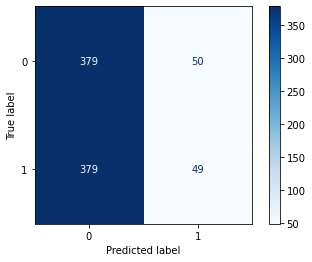

In [240]:
# K-Nearest Neighbors
knn_n = KNeighborsClassifier()
knn_n.fit(X_train, y_train)
y_knn_n = knn_n.predict(X_test)
as_knn_n = accuracy_score(y_test, y_knn_n)
f1s_knn_n = f1_score(y_test, y_knn_n, average= "macro")
prec_knn_n = precision_score(y_test, y_knn_n)
rec_knn_n = recall_score(y_test, y_knn_n, average='macro')
print("\nK-Nearest Neighbors - NOUN_PROPN_VERB\n")
plot_confusion_matrix(knn_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_knn_n))
print(classification_report(y_test,y_knn_n))
print(accuracy_score(y_test, y_knn_n))

In [130]:
s1_i = pd.Series([as_mnb_i, as_svc_i, as_log_i, as_rf_i, as_NN_i, as_tree_i, as_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_i = pd.Series([f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_NN_i, f1s_tree_i, f1s_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_i = pd.Series([prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_NN_i, prec_tree_i, prec_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_i = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_i = {'Accuracy Score' : s1_i, 'Precision Score': s3_i, 'Recall Score' : s4_i, 'F1 Score' : s2_i}
dfm_i = pd.DataFrame(d_i)
print("\nNOUN_PROPN_VERB\n")
dfm_i.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


NOUN_PROPN_VERB



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.645274,0.623016,0.595646,0.642536
Support Vector Machine,0.696616,0.721053,0.524006,0.695621
Logistic Regression,0.703617,0.739011,0.530780,0.701902
Random Forest,0.666278,0.711310,0.552331,0.662301
Neural Networks,0.707118,0.719603,0.609374,0.706848
Decision Tree,0.637106,0.653543,0.642945,0.635964
K-Nearest Neighbors,0.499417,0.494949,0.510514,0.412271


### Sentiment Analysis by nltk VEDER 

In [131]:
sia = vd.SentimentIntensityAnalyzer()
data['sentiment_text'] = data["lemmatized"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_text']
correl_text = col1.corr(col2)
print(correl_text)

-0.1143327140569865


In [132]:
data['sentiment_NPV'] = data["NOUN_PROPN_VERB"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPV']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.09807079431437497


In [133]:
pos_list = ["ADJ"]
data["ADJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_ADJ'] = data["ADJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADJ']
correl_ADJ = col1.corr(col2)
print(correl_ADJ)

-0.08791668104919677


In [134]:
pos_list = ["NOUN"]
data["NOUN"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN'] = data["NOUN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN']
correl_NOUN = col1.corr(col2)
print(correl_NOUN)

-0.07076059713818643


In [135]:
pos_list = ["VERB"]
data["VERB"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_VERB'] = data["VERB"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_VERB']
correl_VERB = col1.corr(col2)
print(correl_VERB)

-0.06372538235181831


In [136]:
data['sentiment_PROPN'] = data["PROPN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_PROPN']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

-0.045808163551427854


### Polarity by TextBlob

In [137]:
data['polarity'] = data['lemmatized'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity'].unique()

array([ 0.        ,  0.4       ,  0.23333333, ...,  0.19242424,
       -0.23472222,  0.003125  ])

Text(0, 0.5, 'Number of texts')

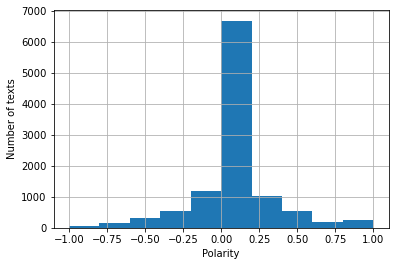

In [138]:
data['polarity'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of texts")

Text(0, 0.5, 'Number of Adjectives')

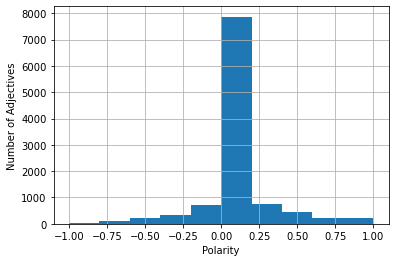

In [139]:
data['polarity_ADJ'] = data['ADJ'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_ADJ'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Adjectives")

Text(0, 0.5, 'Number of Nouns')

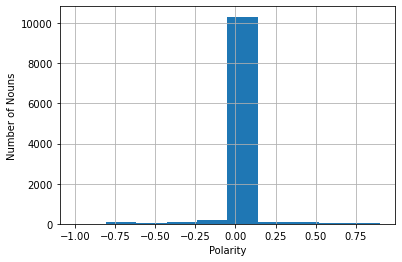

In [140]:
data['polarity_NOUN'] = data['NOUN'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_NOUN'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Nouns")

Text(0, 0.5, 'Number of Proper Nouns')

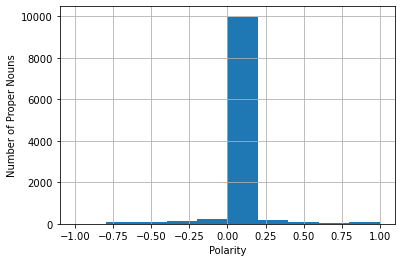

In [141]:
data['polarity_PROPN'] = data['PROPN'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_PROPN'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Proper Nouns")

Text(0, 0.5, 'Number of Verbs')

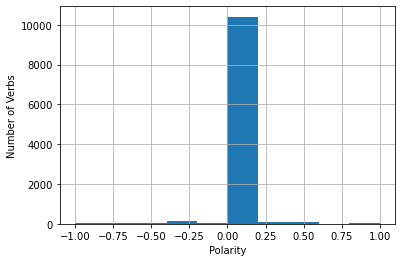

In [142]:
data['polarity_VERB'] = data['VERB'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_VERB'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Verbs")

#### Check for punctuation (POS=PUNCT)

In [143]:
pos_list = ["PUNCT"]

In [144]:
data["PUNCT"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [145]:
data[data['PUNCT'].str.contains(".")].head()

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,word_count,stemmed,lemmatized,...,sentiment_NOUN,VERB,sentiment_VERB,sentiment_PROPN,polarity,polarity_ADJ,polarity_NOUN,polarity_PROPN,polarity_VERB,PUNCT
1184,13052957_1,579087,1345,1,0,I bet all the Ted Pike stuff is on the ADL hit...,bet ted pike stuff adl hit list look start dis...,12,bet ted pike stuff adl hit list look start dis...,bet ted pike stuff adl hit list look start dis...,...,0.0,hit look start disappearing,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,adl
1220,13350432_1,576002,1345,1,0,:hide And if you 're around Knights of Columbu...,around knights columbus roman catholic brether...,13,around knight columbu roman cathol brethern ke...,around knight columbus roman catholic brethern...,...,0.0,keep,0.0,0.0,0.088889,0.1000,0.0,0.0,0.0,boy
1495,14014774_2,579541,1388,0,0,The French N.B communities near Quebec especia...,french communities near quebec especially woul...,7,french commun near quebec especi would white,french community near quebec especially would ...,...,0.0,would,0.0,0.0,0.025000,0.0000,0.0,0.0,0.0,white
1624,14095095_2,598702,1381,0,0,"For example , almost all the 12 year olds last...",example almost year olds last year dressed wig...,11,exampl almost year old last year dress wigger ...,example almost year old last year dressed wigg...,...,0.0,dressed pimp,0.0,0.0,0.050000,0.0500,0.0,0.0,0.0,halloween
1901,30462409_2,576093,1362,4,0,Dumb goyim are a good revenue source .,dumb goyim good revenue source,5,dumb goyim good revenu sourc,dumb goy good revenue source,...,0.0,,0.0,0.0,0.162500,0.1625,0.0,0.0,0.0,goy


In [146]:
pos_list = ["X_POS"]

In [147]:
data["X_POS"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [148]:
data[data['X_POS'].str.contains(".")]

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,word_count,stemmed,lemmatized,...,VERB,sentiment_VERB,sentiment_PROPN,polarity,polarity_ADJ,polarity_NOUN,polarity_PROPN,polarity_VERB,PUNCT,X_POS


# N-grams

### Bi-grams

In [149]:
bi = [list(nltk.bigrams(x)) for x in data['tokens']]

In [150]:
from collections import Counter
lista = []
for x in bi:
    if x not in lista:
        lista.append(x)

In [151]:
bi_count = {}
for item in lista:
    for x in item:
        if x in bi_count:
            bi_count[x] +=1
        else:
            bi_count[x] = 1

In [152]:
top_bi = {k: v for k, v in sorted(bi_count.items(), key=lambda item: item[1], reverse=True)[:20]}
top_bi

{('can', 'not'): 114,
 ('personal', 'message'): 75,
 ('white', 'people'): 73,
 ('look', 'like'): 71,
 ('year', 'old'): 65,
 ('white', 'nationalist'): 63,
 ('would', 'like'): 60,
 ('year', 'ago'): 60,
 ('white', 'woman'): 55,
 ('non', 'white'): 48,
 ('high', 'school'): 39,
 ('white', 'race'): 36,
 ('white', 'girl'): 33,
 ('new', 'york'): 32,
 ('last', 'year'): 31,
 ('sound', 'like'): 31,
 ('white', 'man'): 30,
 ('public', 'school'): 29,
 ('south', 'africa'): 29,
 ('one', 'day'): 28}

### Tri-grams

In [153]:
tri = [list(nltk.trigrams(x)) for x in data['tokens']]

In [154]:
lista_tri = []
for x in tri:
    if x not in lista_tri:
        lista_tri.append(x)

In [155]:
tri_count = {}
for item in lista_tri:
    for x in item:
        if x in tri_count:
            tri_count[x] +=1
        else:
            tri_count[x] = 1

In [156]:
top_tri = {k: v for k, v in sorted(tri_count.items(), key=lambda item: item[1], reverse=True)[:20]}
top_tri

{('send', 'personal', 'message'): 10,
 ('hair', 'blue', 'eye'): 9,
 ('can', 'not', 'wait'): 9,
 ('new', 'york', 'city'): 8,
 ('dr', 'william', 'pierce'): 8,
 ('like', 'minded', 'people'): 7,
 ('ku', 'klux', 'klan'): 7,
 ('would', 'like', 'say'): 7,
 ('hair', 'brown', 'eye'): 6,
 ('please', 'personal', 'message'): 6,
 ('youtube', 'sa', 'survival'): 6,
 ('sa', 'survival', 'secret'): 6,
 ('survival', 'secret', 'pt'): 6,
 ('update', 'message', 'cst'): 6,
 ('would', 'like', 'get'): 5,
 ('can', 'not', 'get'): 5,
 ('every', 'time', 'see'): 5,
 ('black', 'history', 'month'): 5,
 ('nnn', 'reporter', 'newsroom'): 5,
 ('reporter', 'newsroom', 'forum'): 5}

In [157]:
data['text'][3781]

'Jesli sa , to sie chowaja , albo nie wiedza co to Stormfront .'